In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm
from time import sleep
import os
from os import listdir
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation as FA
import random

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)


In [ ]:
# Set Parameters for Training
mpl.rcParams['font.family'] = 'serif'  # Use serif font for better readability
mpl.rcParams['font.size'] = 12  # Consistent font size
mpl.rcParams['axes.linewidth'] = 1  # Thicker axes lines
mpl.rcParams['xtick.major.size'] = 5  # Ticks adjustments
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.major.pad'] = 5
mpl.rcParams['ytick.major.pad'] = 5
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['figure.dpi'] = 300  # High DPI for publication quality
mpl.rcParams['savefig.bbox'] = 'tight'  # Tight bounding box
mpl.rcParams['axes.grid'] = True  # Enable grid by default
mpl.rcParams['grid.alpha'] = 0.5 # Grid alpha
mpl.rcParams['lines.linewidth'] = 1.5 # Line width
mpl.rcParams['scatter.marker'] = 'o' # Marker

Setting seeds for ensuring reproducibility

In [3]:
# import time

# # Generate a random seed based on the current time
# seed = int(time.time())
# print("Selected seed:", seed)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

📌 Loading the data:

There are 100 trajectories of engine degradation in EACH of the datasets (train and test).  
For the train data, each engine is run from a certain normal condition till failure.  
For the test data, each engine is NOT run until failure (or we have data until a specific point of the engine's state). The amount of time cycles left for this engine to still be 'normal' is what we call RUL, or Remaining Useful Lifetime.
> **Predicting what the RUL is for the last state of each machine in the test set will be our prediction task.**

In [4]:
folder_path = './CMAPSSData/'

listdir(folder_path)

file_name = 'FD001.txt'

df_train = pd.read_csv(folder_path + 'train_' + file_name, header = None, sep = ' ')
df_test = pd.read_csv(folder_path + 'test_'+file_name, header = None, sep = ' ')
rul_test = pd.read_csv(folder_path + 'RUL_'+file_name, header = None)

for df in [df_train, df_test, rul_test]:
    display(df.head())

0   1       2       3      4       5       6        7        8      9   \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

      10      11       12       13   14     15      16       17       18  \
0  21.61  554.36  2388.06  9046.19  1.3  47.47  521.66  2388.02  8138.62   
1  21.61  553.75  2388.04  9044.07  1.3  47.49  522.28  2388.07  8131.49   
2  21.61  554.26  2388.08  9052.94  1.3  47.27  522.42  2388.03  8133.23   
3  21.61  554.45  2388.11  9049.48  1.3  47.13  522.86  2388.08  8133.83   
4  21.61  554.00  2388.06  9055.15  1.3  47.28  522.19  2388.04  8133.80   

       19    20   21    22     23     24       25  26  27  
0  8.4195  0.03  392  2388  100.0  39.06  23.4190 NaN NaN  
1  8.4318  0.03  392  2388  100.0  39.00  23.4236 NaN NaN  
2  8.4178  0.03  390  2388  100.0  38.95  23.3442 NaN NaN  
3  8.3682  0.03  392  2388  100.0  38.88  23.3739 NaN NaN  
4  8.4294  0.03  393  2388  100.0  38.90  23.4044 NaN NaN

0   1       2       3      4       5       6        7        8      9   \
0   1   1  0.0023  0.0003  100.0  518.67  643.02  1585.29  1398.21  14.62   
1   1   2 -0.0027 -0.0003  100.0  518.67  641.71  1588.45  1395.42  14.62   
2   1   3  0.0003  0.0001  100.0  518.67  642.46  1586.94  1401.34  14.62   
3   1   4  0.0042  0.0000  100.0  518.67  642.44  1584.12  1406.42  14.62   
4   1   5  0.0014  0.0000  100.0  518.67  642.51  1587.19  1401.92  14.62   

      10      11       12       13   14     15      16       17       18  \
0  21.61  553.90  2388.04  9050.17  1.3  47.20  521.72  2388.03  8125.55   
1  21.61  554.85  2388.01  9054.42  1.3  47.50  522.16  2388.06  8139.62   
2  21.61  554.11  2388.05  9056.96  1.3  47.50  521.97  2388.03  8130.10   
3  21.61  554.07  2388.03  9045.29  1.3  47.28  521.38  2388.05  8132.90   
4  21.61  554.16  2388.01  9044.55  1.3  47.31  522.15  2388.03  8129.54   

       19    20   21    22     23     24       25  26  27  
0  8.4052  0.03  392  2388  100.0  38.86  23.3735 NaN NaN  
1  8.3803  0.03  393  2388  100.0  39.02  23.3916 NaN NaN  
2  8.4441  0.03  393  2388  100.0  39.08  23.4166 NaN NaN  
3  8.3917  0.03  391  2388  100.0  39.00  23.3737 NaN NaN  
4  8.4031  0.03  390  2388  100.0  38.99  23.4130 NaN NaN

0
0  112
1   98
2   69
3   82
4   91

📌 Attaching column names: We have three operational setting columns (**os + number**), and 21 sensor columns (**s + number**). We have dropped the last two columns containing NaNs.

In [5]:
col_names = []

col_names.append('unit')
col_names.append('time')

for i in range(1,4):
    col_names.append('os'+str(i))
for i in range(1,22):
    col_names.append('s'+str(i))

df_train = df_train.iloc[:,:-2].copy()
df_train.columns = col_names
display(df_train.head())

df_test = df_test.iloc[:,:-2].copy()
df_test.columns = col_names
display(df_test.head())

unit  time     os1     os2    os3      s1      s2       s3       s4     s5  \
0     1     1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1     1     2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2     1     3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3     1     4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4     1     5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

      s6      s7       s8       s9  s10    s11     s12      s13      s14  \
0  21.61  554.36  2388.06  9046.19  1.3  47.47  521.66  2388.02  8138.62   
1  21.61  553.75  2388.04  9044.07  1.3  47.49  522.28  2388.07  8131.49   
2  21.61  554.26  2388.08  9052.94  1.3  47.27  522.42  2388.03  8133.23   
3  21.61  554.45  2388.11  9049.48  1.3  47.13  522.86  2388.08  8133.83   
4  21.61  554.00  2388.06  9055.15  1.3  47.28  522.19  2388.04  8133.80   

      s15   s16  s17   s18    s19    s20      s21  
0  8.4195  0.03  392  2388  100.0  39.06  23.4190  
1  8.4318  0.03  392  2388  100.0  39.00  23.4236  
2  8.4178  0.03  390  2388  100.0  38.95  23.3442  
3  8.3682  0.03  392  2388  100.0  38.88  23.3739  
4  8.4294  0.03  393  2388  100.0  38.90  23.4044

unit  time     os1     os2    os3      s1      s2       s3       s4     s5  \
0     1     1  0.0023  0.0003  100.0  518.67  643.02  1585.29  1398.21  14.62   
1     1     2 -0.0027 -0.0003  100.0  518.67  641.71  1588.45  1395.42  14.62   
2     1     3  0.0003  0.0001  100.0  518.67  642.46  1586.94  1401.34  14.62   
3     1     4  0.0042  0.0000  100.0  518.67  642.44  1584.12  1406.42  14.62   
4     1     5  0.0014  0.0000  100.0  518.67  642.51  1587.19  1401.92  14.62   

      s6      s7       s8       s9  s10    s11     s12      s13      s14  \
0  21.61  553.90  2388.04  9050.17  1.3  47.20  521.72  2388.03  8125.55   
1  21.61  554.85  2388.01  9054.42  1.3  47.50  522.16  2388.06  8139.62   
2  21.61  554.11  2388.05  9056.96  1.3  47.50  521.97  2388.03  8130.10   
3  21.61  554.07  2388.03  9045.29  1.3  47.28  521.38  2388.05  8132.90   
4  21.61  554.16  2388.01  9044.55  1.3  47.31  522.15  2388.03  8129.54   

      s15   s16  s17   s18    s19    s20      s21  
0  8.4052  0.03  392  2388  100.0  38.86  23.3735  
1  8.3803  0.03  393  2388  100.0  39.02  23.3916  
2  8.4441  0.03  393  2388  100.0  39.08  23.4166  
3  8.3917  0.03  391  2388  100.0  39.00  23.3737  
4  8.4031  0.03  390  2388  100.0  38.99  23.4130

📌 Attaching RUL(remaining useful lifetime) values to the datasets.

For the train data, the RUL values are not specified, but the document regarding this dataset specifies that for the training data, all the engines were run to failure. Thus, for example, if we had five rows for a specific unit, say unit 7:

|unit|time cycle|
|--|--|
|7|1|
|7|2|
|7|3|
|7|4|
|7|5|

Then we know that the last row is when the RUL value becomes 0 (failure), so the RUL for this unit would be attached in this way:

|unit|time cycle|RUL|
|--|--|--|
|7|1|**4**|
|7|2|**3**|
|7|3|**2**|
|7|4|**1**|
|7|5|**0**|

For the test data, we have the 'solutions' for the test engines in a separate file called rul_test (the name that I used for dataframe). I will use that to attach the RUL values for the test as well.

In [6]:
units_training = max(df_train['unit'])
units_testing = max(df_test['unit'])
print(f'Units in the training dataset: {units_training}')
print(f'Units in the testing dataset: {units_testing}')
df_train = df_train[df_train['unit'] != 260]
if units_training > units_testing:
    df_train = df_train[df_train['unit'] <= units_testing]
elif units_training < units_testing:
    df_test = df_test[df_test['unit']  <= units_training]

assert max(df_train['unit']) == max(df_test['unit'])
no_units = max(df_train['unit'])
print(f'No of units in training and testing dataset after: {no_units}')


Units in the training dataset: 100
Units in the testing dataset: 100
No of units in training and testing dataset after: 100


In [7]:
MAX_RUL = 125
no_units = min(rul_test.shape[0],max(df_train['unit']))
print(f'units :{no_units}')

units :100


In [8]:
rul_list = []
engine_numbers = no_units
for n in np.arange(1,engine_numbers+1):
    
    time_list = np.array(df_train[df_train['unit'] == n]['time'])
    length = len(time_list)
    rul = list(length - time_list)
    rul = [min(MAX_RUL,x) for x in rul]
    rul_list += rul
    
df_train['rul'] = rul_list

rul_list = []

for n in np.arange(1,engine_numbers+1):
    
    time_list = np.array(df_test[df_test['unit'] == n]['time'])
    length = len(time_list)
    rul_val = rul_test.iloc[n-1].item()
    rul = list(length - time_list + rul_val)
    rul = [min(MAX_RUL,x) for x in rul]
    rul_list += rul

df_test['rul'] = rul_list

for df in [df_train, df_test]:
    display(df.head())

unit  time     os1     os2    os3      s1      s2       s3       s4     s5  \
0     1     1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1     1     2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2     1     3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3     1     4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4     1     5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

      s6      s7       s8       s9  s10    s11     s12      s13      s14  \
0  21.61  554.36  2388.06  9046.19  1.3  47.47  521.66  2388.02  8138.62   
1  21.61  553.75  2388.04  9044.07  1.3  47.49  522.28  2388.07  8131.49   
2  21.61  554.26  2388.08  9052.94  1.3  47.27  522.42  2388.03  8133.23   
3  21.61  554.45  2388.11  9049.48  1.3  47.13  522.86  2388.08  8133.83   
4  21.61  554.00  2388.06  9055.15  1.3  47.28  522.19  2388.04  8133.80   

      s15   s16  s17   s18    s19    s20      s21  rul  
0  8.4195  0.03  392  2388  100.0  39.06  23.4190  125  
1  8.4318  0.03  392  2388  100.0  39.00  23.4236  125  
2  8.4178  0.03  390  2388  100.0  38.95  23.3442  125  
3  8.3682  0.03  392  2388  100.0  38.88  23.3739  125  
4  8.4294  0.03  393  2388  100.0  38.90  23.4044  125

unit  time     os1     os2    os3      s1      s2       s3       s4     s5  \
0     1     1  0.0023  0.0003  100.0  518.67  643.02  1585.29  1398.21  14.62   
1     1     2 -0.0027 -0.0003  100.0  518.67  641.71  1588.45  1395.42  14.62   
2     1     3  0.0003  0.0001  100.0  518.67  642.46  1586.94  1401.34  14.62   
3     1     4  0.0042  0.0000  100.0  518.67  642.44  1584.12  1406.42  14.62   
4     1     5  0.0014  0.0000  100.0  518.67  642.51  1587.19  1401.92  14.62   

      s6      s7       s8       s9  s10    s11     s12      s13      s14  \
0  21.61  553.90  2388.04  9050.17  1.3  47.20  521.72  2388.03  8125.55   
1  21.61  554.85  2388.01  9054.42  1.3  47.50  522.16  2388.06  8139.62   
2  21.61  554.11  2388.05  9056.96  1.3  47.50  521.97  2388.03  8130.10   
3  21.61  554.07  2388.03  9045.29  1.3  47.28  521.38  2388.05  8132.90   
4  21.61  554.16  2388.01  9044.55  1.3  47.31  522.15  2388.03  8129.54   

      s15   s16  s17   s18    s19    s20      s21  rul  
0  8.4052  0.03  392  2388  100.0  38.86  23.3735  125  
1  8.3803  0.03  393  2388  100.0  39.02  23.3916  125  
2  8.4441  0.03  393  2388  100.0  39.08  23.4166  125  
3  8.3917  0.03  391  2388  100.0  39.00  23.3737  125  
4  8.4031  0.03  390  2388  100.0  38.99  23.4130  125

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Initialize KMeans and StandardScaler
kmeans = KMeans(n_clusters=6, random_state=42)
scaler = StandardScaler()

# Apply clustering for specific datasets
if file_name in ['FD002.txt', 'FD004.txt']:
    # Ensure required columns are present
    if {'os1', 'os2', 'os3'}.issubset(df_train.columns):
        # Select operating conditions and scale them
        operating_conditions = df_train[['os1', 'os2', 'os3']]
        scaled_conditions = scaler.fit_transform(operating_conditions)

        # Apply k-means clustering and assign operation_mode
        df_train['operation_mode'] = kmeans.fit_predict(scaled_conditions)
    else:
        raise ValueError("Columns 'os1', 'os2', and 'os3' are missing in the dataset!")
else:
    print(f"No clustering applied for dataset {file_name}.")

if file_name in ['FD002.txt', 'FD004.txt']:
    df_test['operation_mode'] = kmeans.predict(scaler.transform(df_test[['os1', 'os2', 'os3']]))


No clustering applied for dataset FD001.txt.


In [10]:
for df in [df_train, df_test]:
    display(df.head())

unit  time     os1     os2    os3      s1      s2       s3       s4     s5  \
0     1     1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1     1     2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2     1     3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3     1     4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4     1     5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

      s6      s7       s8       s9  s10    s11     s12      s13      s14  \
0  21.61  554.36  2388.06  9046.19  1.3  47.47  521.66  2388.02  8138.62   
1  21.61  553.75  2388.04  9044.07  1.3  47.49  522.28  2388.07  8131.49   
2  21.61  554.26  2388.08  9052.94  1.3  47.27  522.42  2388.03  8133.23   
3  21.61  554.45  2388.11  9049.48  1.3  47.13  522.86  2388.08  8133.83   
4  21.61  554.00  2388.06  9055.15  1.3  47.28  522.19  2388.04  8133.80   

      s15   s16  s17   s18    s19    s20      s21  rul  
0  8.4195  0.03  392  2388  100.0  39.06  23.4190  125  
1  8.4318  0.03  392  2388  100.0  39.00  23.4236  125  
2  8.4178  0.03  390  2388  100.0  38.95  23.3442  125  
3  8.3682  0.03  392  2388  100.0  38.88  23.3739  125  
4  8.4294  0.03  393  2388  100.0  38.90  23.4044  125

unit  time     os1     os2    os3      s1      s2       s3       s4     s5  \
0     1     1  0.0023  0.0003  100.0  518.67  643.02  1585.29  1398.21  14.62   
1     1     2 -0.0027 -0.0003  100.0  518.67  641.71  1588.45  1395.42  14.62   
2     1     3  0.0003  0.0001  100.0  518.67  642.46  1586.94  1401.34  14.62   
3     1     4  0.0042  0.0000  100.0  518.67  642.44  1584.12  1406.42  14.62   
4     1     5  0.0014  0.0000  100.0  518.67  642.51  1587.19  1401.92  14.62   

      s6      s7       s8       s9  s10    s11     s12      s13      s14  \
0  21.61  553.90  2388.04  9050.17  1.3  47.20  521.72  2388.03  8125.55   
1  21.61  554.85  2388.01  9054.42  1.3  47.50  522.16  2388.06  8139.62   
2  21.61  554.11  2388.05  9056.96  1.3  47.50  521.97  2388.03  8130.10   
3  21.61  554.07  2388.03  9045.29  1.3  47.28  521.38  2388.05  8132.90   
4  21.61  554.16  2388.01  9044.55  1.3  47.31  522.15  2388.03  8129.54   

      s15   s16  s17   s18    s19    s20      s21  rul  
0  8.4052  0.03  392  2388  100.0  38.86  23.3735  125  
1  8.3803  0.03  393  2388  100.0  39.02  23.3916  125  
2  8.4441  0.03  393  2388  100.0  39.08  23.4166  125  
3  8.3917  0.03  391  2388  100.0  39.00  23.3737  125  
4  8.4031  0.03  390  2388  100.0  38.99  23.4130  125

Standard normalization (z-score normalization), the data is scaled to have a mean of 0 and a standard deviation of 1.

In [11]:
sensor_colums = ['s'+str(i) for i in range(1,22)]
print(sensor_colums)

['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']


In [12]:
##  Z-score Normalization
if file_name in ['FD001.txt', 'FD003.txt']:
    # Dictionary to store mean and std for columns containing 's'
    mean_std_dict = {}

    # Calculate mean and std for 's' columns in df_train
    for c in sensor_colums:
        mean_std_dict[c + '_mean'] = df_train[c].mean()
        mean_std_dict[c + '_std'] = df_train[c].std()

    # Apply standard normalization to df_train
    for c in sensor_colums:
            df_train[c] = (df_train[c] - mean_std_dict[c + '_mean']) / (mean_std_dict[c + '_std'] + 1e-6)

    # Apply standard normalization to df_test using df_train's mean and std
    for c in sensor_colums:
            df_test[c] = (df_test[c] - mean_std_dict[c + '_mean']) / (mean_std_dict[c + '_std'] + 1e-6)

In [13]:
if file_name in ['FD002.txt', 'FD004.txt']:
    # Function to normalize each group based on its operation_mode
    def z_score_normalize_by_mode(group):
        group = group.copy()  # To avoid modifying the original data
        for c in sensor_colums:
            group[c] = (group[c] - group[c].mean()) / (group[c].std() + 1e-6)
        return group

    # Normalize training data
    df_train_normalized = df_train.groupby('operation_mode', group_keys=False).apply(z_score_normalize_by_mode)

    # Normalize test data using train stats for each operation_mode
    for mode in df_train['operation_mode'].unique():
        train_group = df_train[df_train['operation_mode'] == mode]
        test_group = df_test[df_test['operation_mode'] == mode]
        
        for c in sensor_colums:
            # Ensure the column dtype is compatible
            df_test[c] = df_test[c].astype(float)
                
            mean = train_group[c].mean()
            std = train_group[c].std()
                
            df_test.loc[df_test['operation_mode'] == mode, c] = (
                df_test.loc[df_test['operation_mode'] == mode, c] - mean
            ) / (std+1e-6)

    df_train = df_train_normalized.copy()

In [14]:
if file_name in ['FD002.txt', 'FD004.txt']:
    df_train = df_train.drop('operation_mode', axis = 1)
    df_test = df_test.drop('operation_mode', axis = 1)

os_colums = ['os'+str(i) for i in range(1,4)]
print(os_colums)

mean_std_dict = {}
# Calculate mean and std for 's' columns in df_train
for c in os_colums:
    mean_std_dict[c + '_mean'] = df_train[c].mean()
    mean_std_dict[c + '_std'] = df_train[c].std()

# Apply standard normalization to df_train
for c in os_colums:
    df_train[c] = (df_train[c] - mean_std_dict[c + '_mean']) / (mean_std_dict[c + '_std'] + 1e-6)

# Apply standard normalization to df_test using df_train's mean and std
for c in os_colums:
    df_test[c] = (df_test[c] - mean_std_dict[c + '_mean']) / (mean_std_dict[c + '_std'] + 1e-6)

# Display the first few rows of both datasets
for df in [df_train, df_test]:
    display(df.head())

['os1', 'os2', 'os3']


unit  time       os1       os2  os3   s1        s2        s3        s4  \
0     1     1 -0.315828 -1.368251  0.0  0.0 -1.721680 -0.134252 -0.925913   
1     1     2  0.872302 -1.028187  0.0  0.0 -1.061752  0.211523 -0.643710   
2     1     3 -1.960930  1.012198  0.0  0.0 -0.661795 -0.413156 -0.525940   
3     1     4  0.323934 -0.007994  0.0  0.0 -0.661795 -1.261283 -0.784812   
4     1     5 -0.864195 -0.688123  0.0  0.0 -0.621800 -1.251497 -0.301511   

             s5        s6        s7        s8        s9  s10       s11  \
0 -1.776357e-09  0.141578  1.121112 -0.516319 -0.862792  0.0 -0.266459   
1 -1.776357e-09  0.141578  0.431919 -0.798062 -0.958794  0.0 -0.191578   
2 -1.776357e-09  0.141578  1.008130 -0.234575 -0.557126  0.0 -1.015275   
3 -1.776357e-09  0.141578  1.222796  0.188041 -0.713808  0.0 -1.539446   
4 -1.776357e-09  0.141578  0.714375 -0.516319 -0.457048  0.0 -0.977834   

        s12       s13       s14       s15           s16       s17  s18  s19  \
0  0.334253 -1.058850 -0.269065 -0.603785 -1.387779e-11 -0.781690  0.0  0.0   
1  1.174869 -0.363632 -0.642829 -0.275838 -1.387779e-11 -0.781690  0.0  0.0   
2  1.364686 -0.919806 -0.551616 -0.649111 -1.387779e-11 -2.073043  0.0  0.0   
3  1.961252 -0.224589 -0.520163 -1.971565 -1.387779e-11 -0.781690  0.0  0.0   
4  1.052844 -0.780763 -0.521736 -0.339827 -1.387779e-11 -0.136014  0.0  0.0   

        s20       s21  rul  
0  1.348453  1.194387  125  
1  1.016498  1.236881  125  
2  0.739869  0.503406  125  
3  0.352588  0.777766  125  
4  0.463239  1.059516  125

unit  time       os1       os2  os3   s1        s2        s3        s4  \
0     1     1  1.055091  1.012198  0.0  0.0  0.678059 -0.853530 -1.191451   
1     1     2 -1.229773 -1.028187  0.0  0.0 -1.941656 -0.338129 -1.501430   
2     1     3  0.141145  0.332070  0.0  0.0 -0.441819 -0.584412 -0.843697   
3     1     4  1.923340 -0.007994  0.0  0.0 -0.481815 -1.044358 -0.279290   
4     1     5  0.643816 -0.007994  0.0  0.0 -0.341830 -0.543637 -0.779257   

             s5        s6        s7        s8        s9  s10       s11  \
0 -1.776357e-09  0.141578  0.601393 -0.798062 -0.682562  0.0 -1.277360   
1 -1.776357e-09  0.141578  1.674726 -1.220678 -0.490105  0.0 -0.154137   
2 -1.776357e-09  0.141578  0.838656 -0.657191 -0.375084  0.0 -0.154137   
3 -1.776357e-09  0.141578  0.793463 -0.938934 -0.903548  0.0 -0.977834   
4 -1.776357e-09  0.141578  0.895147 -1.220678 -0.937058  0.0 -0.865512   

        s12       s13       s14       s15           s16       s17  s18  s19  \
0  0.415603 -0.919806 -0.954212 -0.985057 -1.387779e-11 -0.781690  0.0  0.0   
1  1.012169 -0.502676 -0.216643 -1.648950 -1.387779e-11 -0.136014  0.0  0.0   
2  0.754561 -0.919806 -0.715695  0.052109 -1.387779e-11 -0.136014  0.0  0.0   
3 -0.045380 -0.641719 -0.568915 -1.344999 -1.387779e-11 -1.427366  0.0  0.0   
4  0.998611 -0.919806 -0.745051 -1.041048 -1.387779e-11 -2.073043  0.0  0.0   

        s20       s21  rul  
0  0.241936  0.774071  125  
1  1.127149  0.941274  125  
2  1.459104  1.172217  125  
3  1.016498  0.775919  125  
4  0.961172  1.138961  125

Below, we can see an example of all the sensor values of a specific engine in the training set (unit 4), as the engine progresses toward failure.

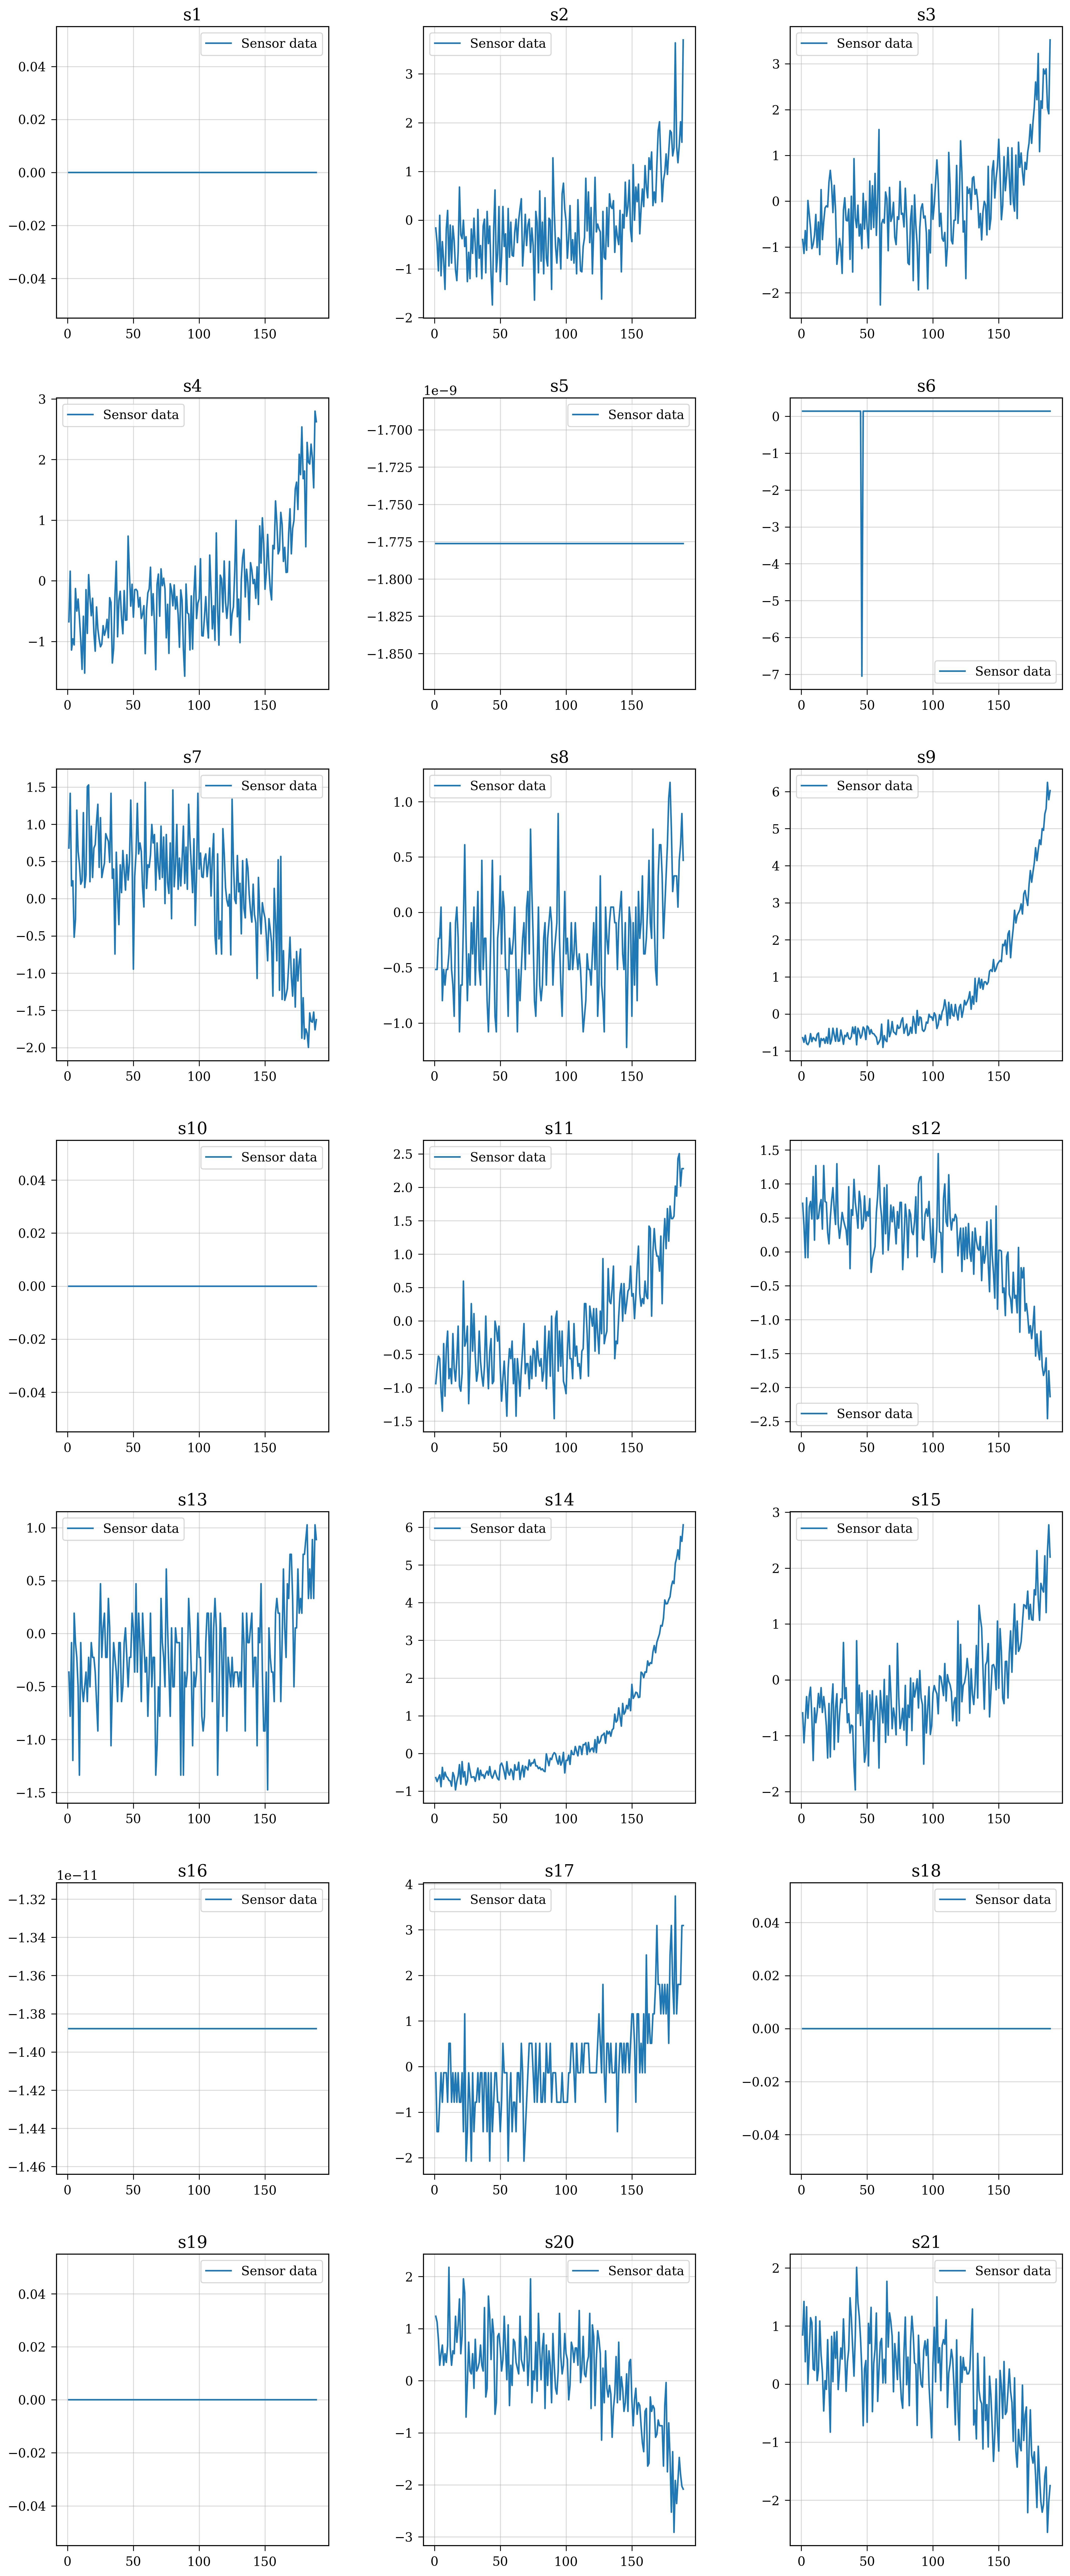

In [15]:
sample = 4
sample_df = df_train[df_train['unit'] == sample].copy()

# Select only sensor columns
n_sensors = len(sensor_colums)
rows = (n_sensors + 2) // 3  # Calculate rows for the grid

# Create subplots
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot each sensor's data
for j, c in enumerate(sensor_colums):
    axes[j].plot(sample_df['time'], sample_df[c], label='Sensor data')
    axes[j].set_title(c)
    # axes[j].set_xlabel('Time')
    # axes[j].set_ylabel('Value')
    axes[j].legend()

# Hide unused subplots
for ax in axes[n_sensors:]:
    ax.axis('off')

# Adjust layout for better spacing
fig.tight_layout(pad=3.0)
plt.savefig(f'figures\\sensor_of_engine_{sample}_for_dataset_{file_name}.png', dpi=300, bbox_inches='tight')
plt.show()


We plot the sensor data obtained from sensor 2 for 5 of the engines to show a general trend.


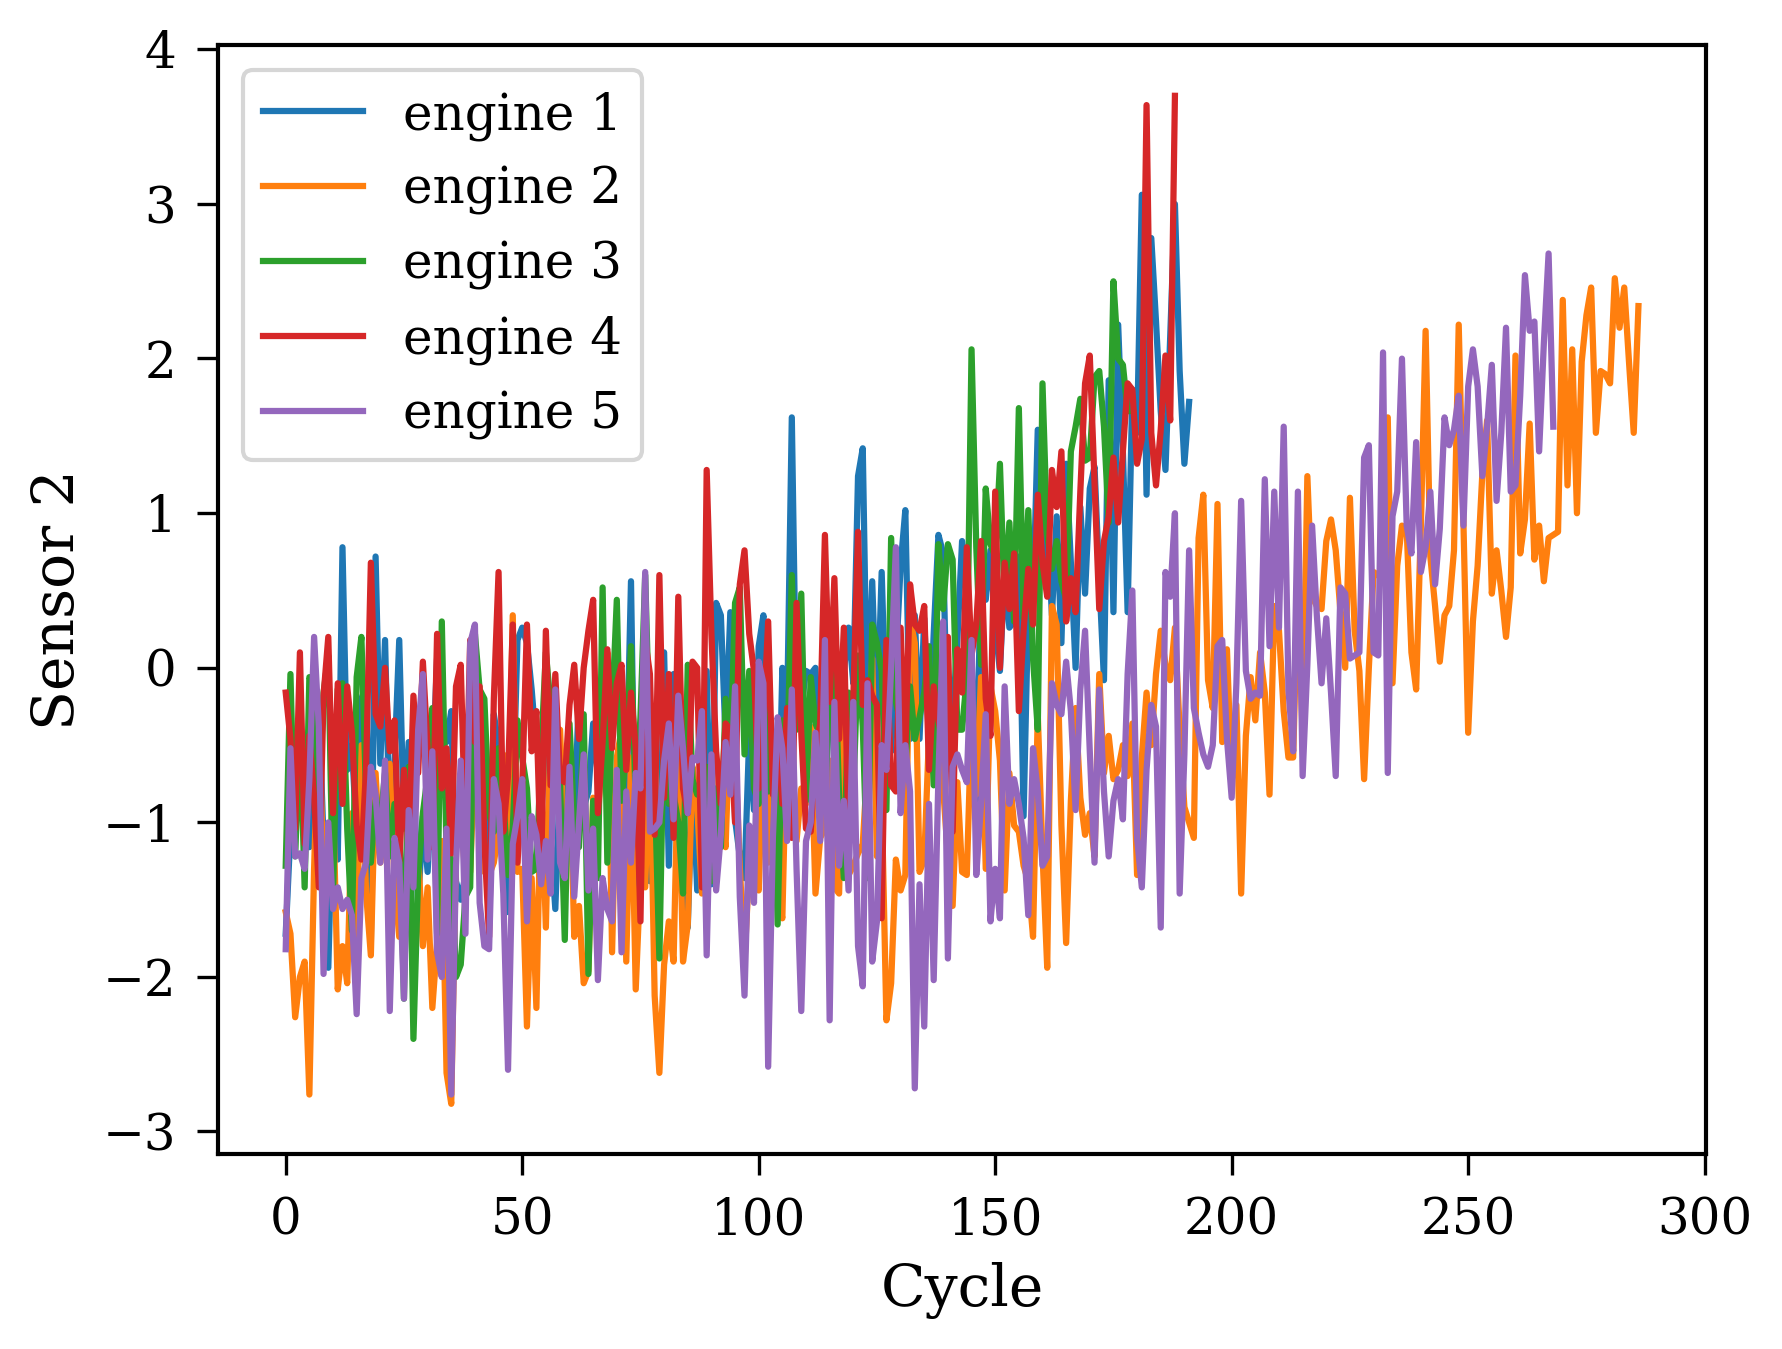

In [16]:
sensor = 's2'
for sample in range(1,6):
    sample_df = df_train[df_train['unit'] == sample].copy()
    sensordata = sample_df[sensor].to_numpy()
    plt.plot(sensordata, label = "engine "+str(sample))
plt.grid()
plt.legend()
plt.ylabel('Sensor 2')
plt.xlabel('Cycle')
plt.savefig(f'figures\\sensor_{sensor}_of_engines_for_dataset_{file_name}.png', dpi=300, bbox_inches='tight')
plt.show()


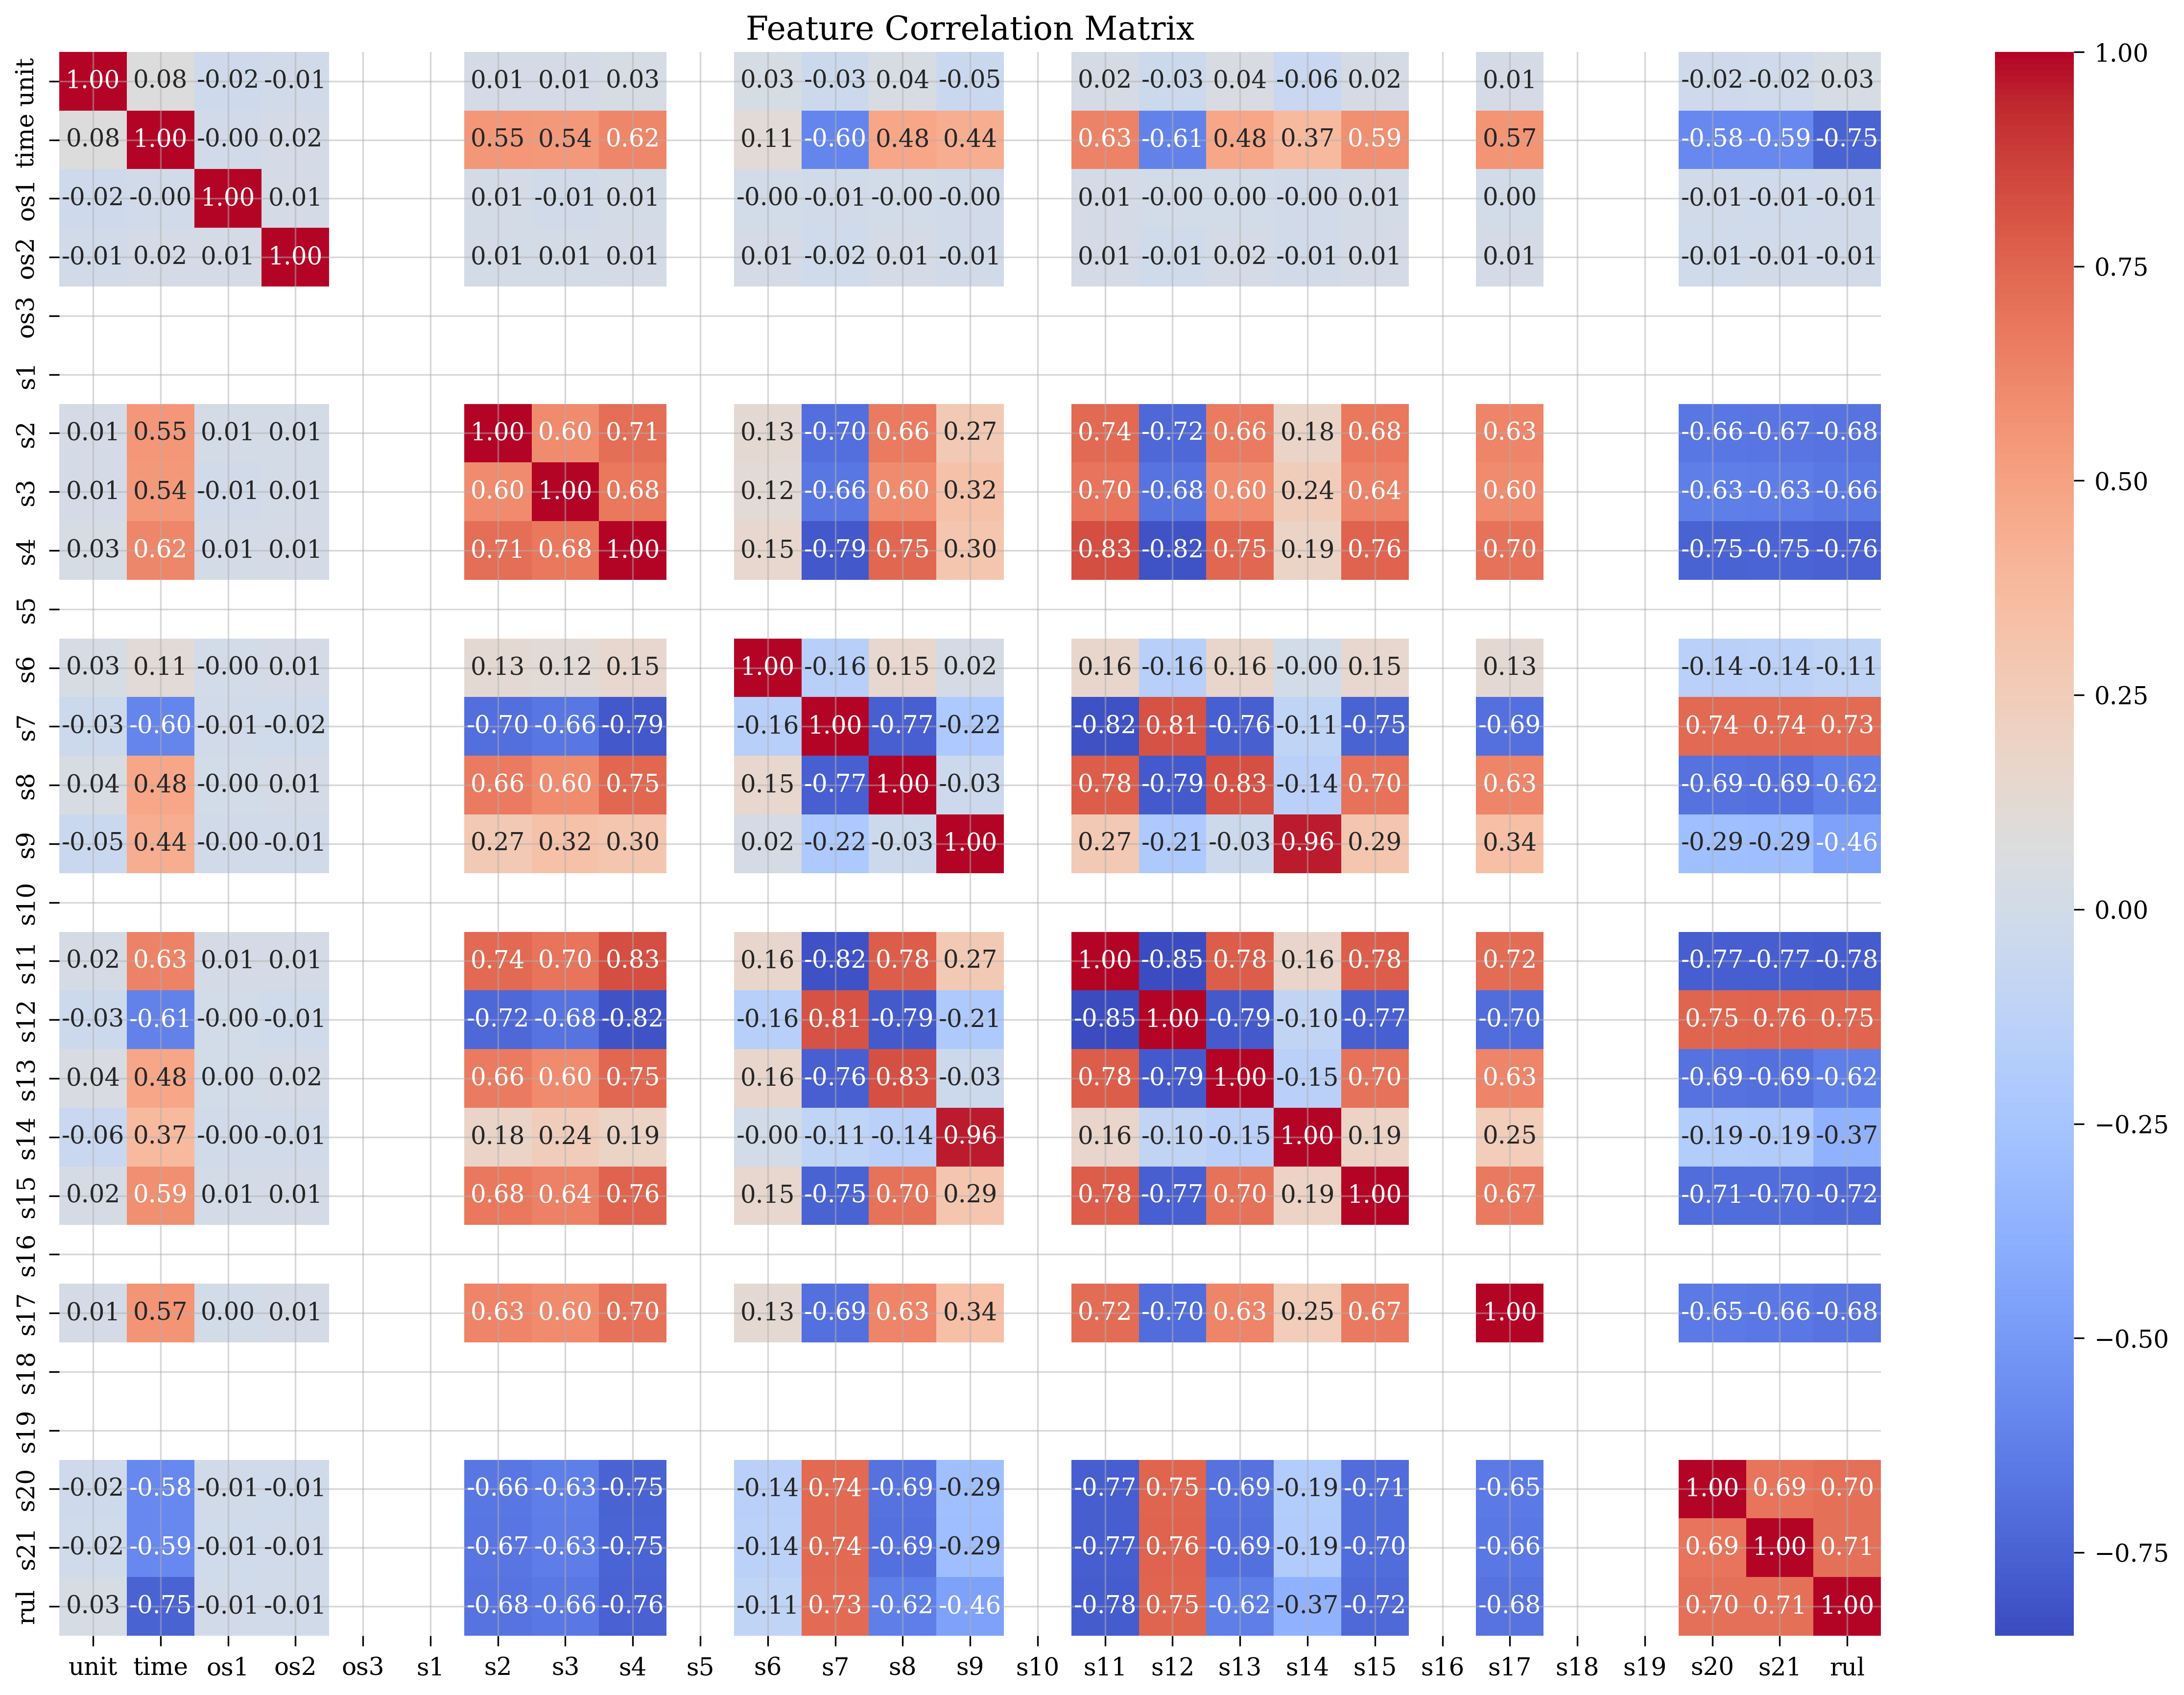

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df_train.corr()

# Plot heatmap
plt.figure(figsize=(20, 14))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.savefig(f'figures\\Feature_Correlation_Matrix_for_dataset_{file_name}.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

Xt = df_train.iloc[:,2:-1]
yt = df_train.iloc[:,-1]

rf = RandomForestRegressor()
rf.fit(Xt, yt)

# Get feature importance
importance = pd.Series(rf.feature_importances_, index=Xt.columns)
importance = importance.sort_values(ascending=False)

print("Feature Importances:\n", importance)

Feature Importances:
 s11    0.569255
s9     0.127547
s4     0.074801
s12    0.041746
s7     0.026609
s14    0.025844
s15    0.021576
s21    0.017284
s2     0.016228
s3     0.015640
s13    0.014042
s20    0.013604
os1    0.011888
s8     0.011035
os2    0.007315
s17    0.005449
s6     0.000134
s5     0.000000
s1     0.000000
s16    0.000000
s18    0.000000
s19    0.000000
os3    0.000000
s10    0.000000
dtype: float64


In [19]:
# Combine thresholding and sorting
threshold = 1e-3
low_importance_features = importance[importance < threshold].sort_values()
print("Low importance features sorted:\n", low_importance_features)

Low importance features sorted:
 s5     0.000000
s1     0.000000
s16    0.000000
s18    0.000000
s19    0.000000
os3    0.000000
s10    0.000000
s6     0.000134
dtype: float64


We can notice here, that there are multiple sensors which are not changing its value. Perhaps, they are not useful features for prediction. Would they have similar behaviors for other engine units as well? Below show that yes (standard deviation is 0, or practically 0).

In [20]:
df_train[low_importance_features.index].describe()

s5       s1           s16      s18      s19      os3  \
count  2.063100e+04  20631.0  2.063100e+04  20631.0  20631.0  20631.0   
mean  -1.776357e-09      0.0 -1.387779e-11      0.0      0.0      0.0   
std    4.136003e-25      0.0  3.231253e-27      0.0      0.0      0.0   
min   -1.776357e-09      0.0 -1.387779e-11      0.0      0.0      0.0   
25%   -1.776357e-09      0.0 -1.387779e-11      0.0      0.0      0.0   
50%   -1.776357e-09      0.0 -1.387779e-11      0.0      0.0      0.0   
75%   -1.776357e-09      0.0 -1.387779e-11      0.0      0.0      0.0   
max   -1.776357e-09      0.0 -1.387779e-11      0.0      0.0      0.0   

           s10            s6  
count  20631.0  2.063100e+04  
mean       0.0 -6.464614e-12  
std        0.0  9.992806e-01  
min        0.0 -7.052745e+00  
25%        0.0  1.415780e-01  
50%        0.0  1.415780e-01  
75%        0.0  1.415780e-01  
max        0.0  1.415780e-01

📌 Previously mentioned columns are dropped.

In [21]:
#Drop os3, s1, s5, s6, s10, s16, s18, s19 from both train and test
drop_cols1 = low_importance_features.index

df_train = df_train.drop(drop_cols1, axis = 1)
df_test = df_test.drop(drop_cols1, axis = 1)

for df in [df_train, df_test]:
    display(df.head())

unit  time       os1       os2        s2        s3        s4        s7  \
0     1     1 -0.315828 -1.368251 -1.721680 -0.134252 -0.925913  1.121112   
1     1     2  0.872302 -1.028187 -1.061752  0.211523 -0.643710  0.431919   
2     1     3 -1.960930  1.012198 -0.661795 -0.413156 -0.525940  1.008130   
3     1     4  0.323934 -0.007994 -0.661795 -1.261283 -0.784812  1.222796   
4     1     5 -0.864195 -0.688123 -0.621800 -1.251497 -0.301511  0.714375   

         s8        s9       s11       s12       s13       s14       s15  \
0 -0.516319 -0.862792 -0.266459  0.334253 -1.058850 -0.269065 -0.603785   
1 -0.798062 -0.958794 -0.191578  1.174869 -0.363632 -0.642829 -0.275838   
2 -0.234575 -0.557126 -1.015275  1.364686 -0.919806 -0.551616 -0.649111   
3  0.188041 -0.713808 -1.539446  1.961252 -0.224589 -0.520163 -1.971565   
4 -0.516319 -0.457048 -0.977834  1.052844 -0.780763 -0.521736 -0.339827   

        s17       s20       s21  rul  
0 -0.781690  1.348453  1.194387  125  
1 -0.781690  1.016498  1.236881  125  
2 -2.073043  0.739869  0.503406  125  
3 -0.781690  0.352588  0.777766  125  
4 -0.136014  0.463239  1.059516  125

unit  time       os1       os2        s2        s3        s4        s7  \
0     1     1  1.055091  1.012198  0.678059 -0.853530 -1.191451  0.601393   
1     1     2 -1.229773 -1.028187 -1.941656 -0.338129 -1.501430  1.674726   
2     1     3  0.141145  0.332070 -0.441819 -0.584412 -0.843697  0.838656   
3     1     4  1.923340 -0.007994 -0.481815 -1.044358 -0.279290  0.793463   
4     1     5  0.643816 -0.007994 -0.341830 -0.543637 -0.779257  0.895147   

         s8        s9       s11       s12       s13       s14       s15  \
0 -0.798062 -0.682562 -1.277360  0.415603 -0.919806 -0.954212 -0.985057   
1 -1.220678 -0.490105 -0.154137  1.012169 -0.502676 -0.216643 -1.648950   
2 -0.657191 -0.375084 -0.154137  0.754561 -0.919806 -0.715695  0.052109   
3 -0.938934 -0.903548 -0.977834 -0.045380 -0.641719 -0.568915 -1.344999   
4 -1.220678 -0.937058 -0.865512  0.998611 -0.919806 -0.745051 -1.041048   

        s17       s20       s21  rul  
0 -0.781690  0.241936  0.774071  125  
1 -0.136014  1.127149  0.941274  125  
2 -0.136014  1.459104  1.172217  125  
3 -1.427366  1.016498  0.775919  125  
4 -2.073043  0.961172  1.138961  125

📌 Splitting **Train and Validation** Sets: Out of the 100 engines in the training set, I will randomly take out 20 engines for validation.

In [22]:
ratio = 0.8                     #Ratio of training and validation datasets

units = np.arange(1, no_units+1)
no_selected = round(ratio * engine_numbers)
train_units = list(np.random.choice(units,no_selected, replace = False))
val_units = list(set(units) - set(train_units))
print(val_units)


train_data = df_train[df_train['unit'].isin(train_units)].copy()
val_data = df_train[df_train['unit'].isin(val_units)].copy()

[14, 15, 18, 24, 34, 40, 44, 48, 53, 62, 63, 72, 74, 78, 80, 82, 85, 87, 90, 94]


📌 The time series for sensor values were noisy. If the time-series values are $t_1, t_2, t_3, ..., t_n$, then the smoothed values $v_1, v_2, ..., v_n$ with the parameter $\beta$ follow the following formula:

$$v_0 = 0, v_{t} = \frac{\beta v_{t-1} + (1-\beta) x_{t}}{1-\beta^{t}}$$

In [23]:
#Smoothing Function: Exponentially Weighted Averages

def smooth(s, b = 0.98):

    v = np.zeros(len(s)+1) #v_0 is already 0.
    bc = np.zeros(len(s)+1)  

    for i in range(1, len(v)): #v_t = 0.95
        v[i] = (b * v[i-1] + (1-b) * s[i-1]) 
        bc[i] = 1 - b**i

    sm = v[1:] / bc[1:]
    
    return sm

# s = [1,2,3,4,5]
# print(s)
# print(f'After Smoothing: {smooth(s)}')

In [24]:
#Smoothing each time series for each engine in both training and test sets
beta = 0.98
# if file_name=='FD002' or file_name=='FD004':
#     beta = 0.8

# Verify data integrity
assert 'unit' in df_train.columns, "The 'unit' column is missing in df_train"
assert 'unit' in df_test.columns, "The 'unit' column is missing in df_test"

def smooth_series(df, beta, unit_col='unit', sensor_prefix='s'):
    """
    Smooths time series for each engine and sensor column in the dataset.
    """
    for col in df.columns:
        if sensor_prefix in col:
            sm_list = []
            for unit in df[unit_col].unique():
                # Get sensor data for the current unit
                unit_data = df[df[unit_col] == unit]
                s = np.array(unit_data[col].copy())
                sm = list(smooth(s, beta))  # Apply smoothing
                sm_list.extend(sm)  # Append smoothed data
            # Check the length match
            if len(sm_list) != len(df):
                raise ValueError(f"Length mismatch for column {col}: sm_list={len(sm_list)}, df={len(df)}")
            # Add smoothed column to DataFrame
            df[col + '_smoothed'] = sm_list
    return df

# Apply smoothing to training and test sets
df_train = smooth_series(df_train, beta)
df_test = smooth_series(df_test, beta)


Let's take a look at how smoothed values (salmon) look compared to the original series (lightblue), for a particular sensor (unit 10 from train)

In [25]:
df_train.columns

Index(['unit', 'time', 'os1', 'os2', 's2', 's3', 's4', 's7', 's8', 's9', 's11',
       's12', 's13', 's14', 's15', 's17', 's20', 's21', 'rul', 'os1_smoothed',
       'os2_smoothed', 's2_smoothed', 's3_smoothed', 's4_smoothed',
       's7_smoothed', 's8_smoothed', 's9_smoothed', 's11_smoothed',
       's12_smoothed', 's13_smoothed', 's14_smoothed', 's15_smoothed',
       's17_smoothed', 's20_smoothed', 's21_smoothed'],
      dtype='object')

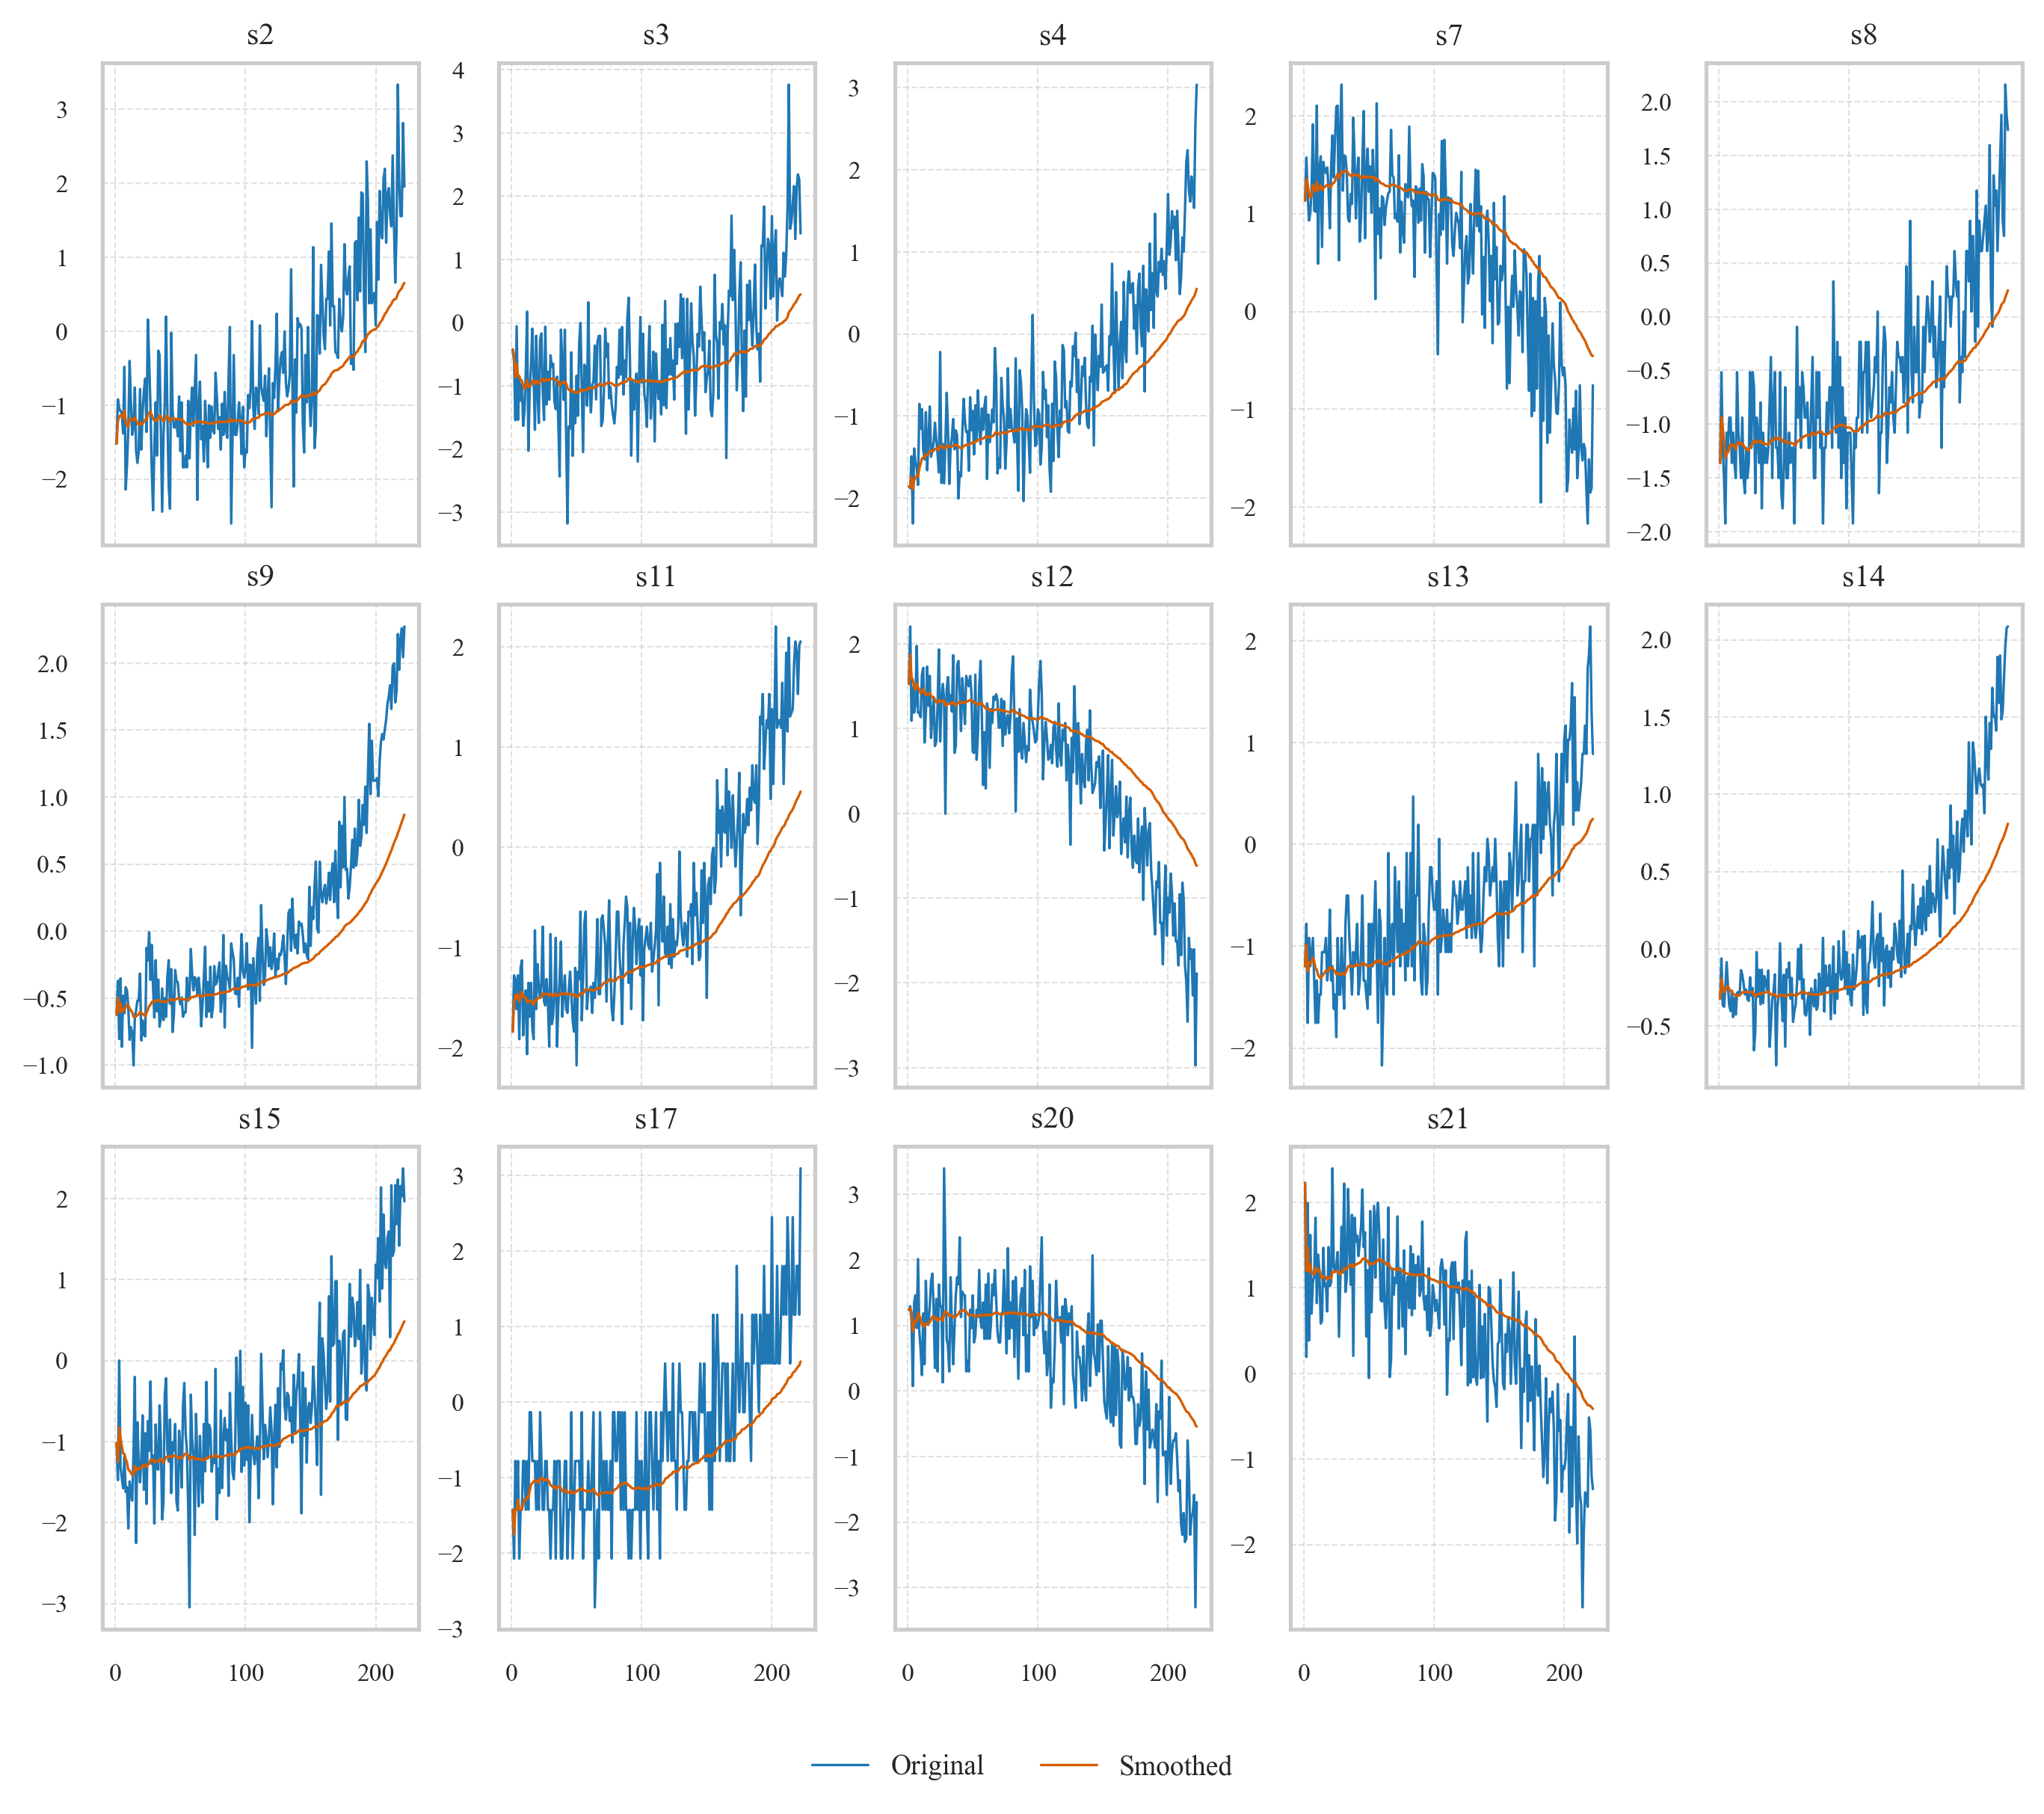

In [26]:
# Set scientific theme
sns.set_theme(style="whitegrid", font="Times New Roman")

# Select unit
sample_unit = 10
sample_df = df_train[df_train['unit'] == sample_unit].copy()

# Extract sensor columns
sensor_cols = [col for col in df_train.columns if col.startswith('s') and '_smoothed' not in col]
n_sensors = len(sensor_cols)

if n_sensors == 0:
    raise ValueError("No valid sensor columns found in the dataset.")

# Define layout for compact visualization
num_cols = 5
num_rows = -(-n_sensors // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(9, 2.5 * num_rows), sharex=True, constrained_layout=True)

# Flatten axes
axes = axes.flatten()

# Define colors
colors = {"original": "tab:blue", "smoothed": "#D55E00", "line": "black"}

for j, col in enumerate(sensor_cols):
    axes[j].plot(sample_df['time'], sample_df[col], color=colors["original"], label="Original", lw=0.8)
    
    smoothed_col = f"{col}_smoothed"
    if smoothed_col in sample_df.columns:
        axes[j].plot(sample_df['time'], sample_df[smoothed_col], color=colors["smoothed"], label="Smoothed", lw=0.8)

    # Grid and Labels
    axes[j].set_title(col, fontsize=10)
    axes[j].tick_params(axis='both', labelsize=8)
    axes[j].grid(True, linestyle="--", linewidth=0.5, alpha=0.6)

# Hide unused subplots
for ax in axes[n_sensors:]:
    ax.set_visible(False)

# Global legend for clarity
fig.legend(["Original", "Smoothed"], loc="upper center", ncol=2, bbox_to_anchor=(0.5, -0.02), fontsize=9, frameon=False)

# Save and display
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, f"Smoothing_Sensors_{file_name}.png"), dpi=600, bbox_inches="tight", pad_inches=0.05)
plt.show()

In [27]:
#Remove the original series

for c in df_train.columns:
    if ('s' in c) and ('smoothed' not in c):
        df_train[c] = df_train[c+'_smoothed']
        df_train.drop(c+'_smoothed', axis = 1, inplace = True)
        
for c in df_test.columns:
    if ('s' in c) and ('smoothed' not in c):
        df_test[c] = df_test[c+'_smoothed']
        df_test.drop(c+'_smoothed', axis = 1, inplace = True)
        
for df in [df_train, df_test]:
    display(df.head())

unit  time       os1       os2        s2        s3        s4        s7  \
0     1     1 -0.315828 -1.368251 -1.721680 -0.134252 -0.925913  1.121112   
1     1     2  0.284238 -1.196502 -1.388383  0.040382 -0.783387  0.773035   
2     1     3 -0.479321 -0.445345 -1.141278 -0.113861 -0.695832  0.852988   
3     1     4 -0.272381 -0.332672 -1.017751 -0.409467 -0.718755  0.948261   
4     1     5 -0.395574 -0.406663 -0.935329 -0.584746 -0.631901  0.899575   

         s8        s9       s11       s12       s13       s14       s15  \
0 -0.516319 -0.862792 -0.266459  0.334253 -1.058850 -0.269065 -0.603785   
1 -0.658613 -0.911278 -0.228640  0.758807 -0.707730 -0.457835 -0.438155   
2 -0.514402 -0.790835 -0.496167  0.964860 -0.779855 -0.489729 -0.509899   
3 -0.333434 -0.770991 -0.764943  1.221557 -0.636804 -0.497569 -0.886462   
4 -0.371504 -0.705640 -0.809259  1.186437 -0.666770 -0.502600 -0.772674   

        s17       s20       s21  rul  
0 -0.781690  1.348453  1.194387  125  
1 -0.781690  1.180799  1.215848  125  
2 -1.220866  1.030843  0.973554  125  
3 -1.107723  0.856107  0.923114  125  
4 -0.905450  0.774327  0.951508  125

unit  time       os1       os2        s2        s3        s4        s7  \
0     1     1  1.055091  1.012198  0.678059 -0.853530 -1.191451  0.601393   
1     1     2 -0.098881 -0.018299 -0.645029 -0.593226 -1.348006  1.143480   
2     1     3 -0.017250  0.100858 -0.575920 -0.590229 -1.176496  1.039813   
3     1     4  0.482697  0.072815 -0.551676 -0.707224 -0.945352  0.976347   
4     1     5  0.516235  0.055993 -0.507994 -0.673172 -0.910777  0.959444   

         s8        s9       s11       s12       s13       s14       s15  \
0 -0.798062 -0.682562 -1.277360  0.415603 -0.919806 -0.954212 -0.985057   
1 -1.011505 -0.585362 -0.710076  0.716899 -0.709134 -0.581703 -1.320356   
2 -0.891006 -0.513849 -0.521007  0.729708 -0.780782 -0.627272 -0.853595   
3 -0.903354 -0.614245 -0.638697  0.530025 -0.744956 -0.612238 -0.980193   
4 -0.969408 -0.681443 -0.685911  0.627567 -0.781353 -0.639884 -0.992861   

        s17       s20       s21  rul  
0 -0.781690  0.241936  0.774071  125  
1 -0.455591  0.689014  0.858517  125  
2 -0.346906  0.950914  0.965203  125  
3 -0.625261  0.967810  0.916438  125  
4 -0.926634  0.966428  0.962759  125

📌 When we look at the length of the trajectories for each unit in both the training and test sets, thus 200 engines, we see that for the training set that had the entire trajectories, have minimum length of 128. However, for the test set, we have a minimum value of 31. This means that if we were to predict the final RUL for every test engine unit, we cannot use a window size greater than 31 for training the model. Furthermore, if you take a look at the smoothed series visualization, I put a **black** vertical line for every graph, at about time step 10. This is because, when we smooth using exponentially weighted averages, seems like in the beginning, it seems a little shaky. Thus, I will be taking that part out of the training process. This will happen for test data as well. Thus, the maximum window size we can take is 31 - 10 = 21. I will go with **20**.

In [28]:
print('training set time cycles:')
display(df_train.groupby('unit')['time'].max().describe())
print('test set time cycles:')
display(df_test.groupby('unit')['time'].max().describe())

training set time cycles:


count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: time, dtype: float64

test set time cycles:


count    100.000000
mean     130.960000
std       53.593479
min       31.000000
25%       88.750000
50%      133.500000
75%      164.250000
max      303.000000
Name: time, dtype: float64

In [29]:
n_features = len([c for c in df_train.columns if 's' in c]) + 1 #plus one for time
window = 15
print(f'number of features: {n_features}, window size: {window}')

number of features: 17, window size: 15


📌 Splitting **Train and Validation** Sets: Out of the 100 engines in the training set, I will randomly take out 20 engines for validation.

In [30]:
train_indices = list(train_data[(train_data['rul'] >= (window - 1)) & (train_data['time'] > 10)].index)
val_indices = list(val_data[(val_data['rul'] >= (window - 1)) & (val_data['time'] > 10)].index)

📌 Normalize the RUL index dividing by maximum value

In [31]:
rul_max = max(df_train['rul'])
df_train['rul'] = df_train['rul'] / rul_max 
df_test['rul'] = df_test['rul'] / rul_max 
rul_max

125

📌 Z-Normalize the time index

In [32]:
# max_time = max(df_train['time'])
df_train_mean = df_train['time'].mean()
df_train_std = df_train['time'].std()
df_train['time'] = (df_train['time'] - df_train_mean) / df_train_std
df_test['time'] = (df_test['time'] - df_train_mean) / df_train_std
display(df_train)

unit      time       os1       os2        s2        s3        s4  \
0         1 -1.565132 -0.315828 -1.368251 -1.721680 -0.134252 -0.925913   
1         1 -1.550614  0.284238 -1.196502 -1.388383  0.040382 -0.783387   
2         1 -1.536097 -0.479321 -0.445345 -1.141278 -0.113861 -0.695832   
3         1 -1.521579 -0.272381 -0.332672 -1.017751 -0.409467 -0.718755   
4         1 -1.507061 -0.395574 -0.406663 -0.935329 -0.584746 -0.631901   
...     ...       ...       ...       ...       ...       ...       ...   
20626   100  1.265837 -0.046498 -0.210477  0.741544  0.749811  0.863767   
20627   100  1.280355 -0.060370 -0.241004  0.761444  0.780991  0.901971   
20628   100  1.294873 -0.055333 -0.236257  0.776042  0.804744  0.927160   
20629   100  1.309391 -0.064361 -0.210831  0.782599  0.837306  0.948092   
20630   100  1.323909 -0.092738 -0.241317  0.814261  0.852989  0.981280   

             s7        s8        s9       s11       s12       s13       s14  \
0      1.121112 -0.516319 -0.862792 -0.266459  0.334253 -1.058850 -0.269065   
1      0.773035 -0.658613 -0.911278 -0.228640  0.758807 -0.707730 -0.457835   
2      0.852988 -0.514402 -0.790835 -0.496167  0.964860 -0.779855 -0.489729   
3      0.948261 -0.333434 -0.770991 -0.764943  1.221557 -0.636804 -0.497569   
4      0.899575 -0.371504 -0.705640 -0.809259  1.186437 -0.666770 -0.502600   
...         ...       ...       ...       ...       ...       ...       ...   
20626 -0.958110  0.800718  0.029403  0.972035 -0.890115  0.865243 -0.071742   
20627 -0.996327  0.822684  0.028681  0.990289 -0.919875  0.882705 -0.078029   
20628 -1.031910  0.847064  0.028703  1.011978 -0.939902  0.905470 -0.079325   
20629 -1.072738  0.873808  0.035936  1.056092 -0.968901  0.924931 -0.082474   
20630 -1.110189  0.902865  0.031735  1.084810 -1.007512  0.952481 -0.087650   

            s15       s17       s20       s21    rul  
0     -0.603785 -0.781690  1.348453  1.194387  1.000  
1     -0.438155 -0.781690  1.180799  1.215848  1.000  
2     -0.509899 -1.220866  1.030843  0.973554  1.000  
3     -0.886462 -1.107723  0.856107  0.923114  1.000  
4     -0.772674 -0.905450  0.774327  0.951508  1.000  
...         ...       ...       ...       ...    ...  
20626  0.831937  0.832314 -0.925512 -0.849195  0.032  
20627  0.853973  0.838898 -0.964863 -0.856421  0.024  
20628  0.903091  0.884808 -0.987618 -0.906049  0.016  
20629  0.937236  0.890317 -1.026801 -0.930059  0.008  
20630  0.951513  0.908857 -1.056162 -0.955790  0.000  

[20631 rows x 19 columns]

📌 Prepare Training, Validation and Test Dataloaders.

For training process, I will take batches of 128.  
For the validation process, I will take the entire validation set (all the windows avaiable).
For the test process, I will take the LAST window of each engine's given trajectory, thus it will have exactly 100 X(size 20 window)s and 100 y(RUL)s.

In [33]:
class data(Dataset):
    
    def __init__(self, list_indices, df_train):
        
        self.indices = list_indices
        self.df_train = df_train
        
    def __len__(self):
        
        return len(self.indices)
    
    def __getitem__(self, idx):
        
        ind = self.indices[idx]
        X_ = self.df_train.iloc[ind : ind + window, :].drop(['unit','rul'], axis = 1).copy().to_numpy()
        y_ = self.df_train.iloc[ind + window - 1]['rul']
        
        return X_, y_
    
train = data(train_indices, df_train)
val = data(val_indices, df_train)

trainloader = DataLoader(train, batch_size = 256, shuffle = True)
valloader = DataLoader(val, batch_size = 128, shuffle = True)

units = np.arange(1, no_units+1)

class test(Dataset):
    
    def __init__(self, units, df_test):
        
        self.units = units
        self.df_test = df_test
        
    def __len__(self):
        
        return len(self.units)
    
    def __getitem__(self, idx):
        
        n = self.units[idx]
        U = self.df_test[self.df_test['unit'] == n].copy()
        X_ = U.reset_index().iloc[-window:,:].drop(['index', 'unit','rul'], axis = 1).copy().to_numpy()
        y_ = U['rul'].min()
        
        return X_, y_
    
test = test(units, df_test)
testloader = DataLoader(test, batch_size = 100)

In [34]:
dataiter = iter(trainloader)
x,y = next(dataiter)
x.shape

torch.Size([256, 15, 17])

## 2. Model Building and Training ##

📌 I will be using a Model incoprorating Attention Mechanism with pairwise interactions and positional awareness layers before the final output.

In [35]:
def anderson(f, x0, m=5, lam=1e-4, max_iter=50, tol=1e-2, beta=1.0, verbose=False):
    """Improved Anderson acceleration for fixed-point iteration."""
    # Shape parameters
    batch, channels, dim = x0.shape
    
    # Storage for historical X and F
    X = torch.zeros(batch, m, channels * dim, dtype=x0.dtype, device=x0.device)
    F = torch.zeros(batch, m, channels * dim, dtype=x0.dtype, device=x0.device)

    # Initialize X and F with the first two iterations
    X[:, 0], F[:, 0] = x0.view(batch, -1), f(x0).view(batch, -1)
    X[:, 1], F[:, 1] = F[:, 0], f(F[:, 0].view(batch, channels, dim)).view(batch, -1)

    # Prepare the H matrix and y vector for Anderson acceleration
    H = torch.zeros(batch, m + 1, m + 1, dtype=x0.dtype, device=x0.device)
    H[:, 0, 1:] = H[:, 1:, 0] = 1  # First row and column for normalization
    y = torch.zeros(batch, m + 1, 1, dtype=x0.dtype, device=x0.device)
    y[:, 0, 0] = 1  # y vector for the Anderson step

    res = []  # To store residuals

    for k in range(2, max_iter):
        n = min(k, m)  # Number of iterations to consider

        # Compute residual matrix G
        G = F[:, :n] - X[:, :n]

        # Compute the H matrix (Gramian + regularization)
        GTG = torch.bmm(G, G.transpose(1, 2))
        H[:, 1:n+1, 1:n+1] = GTG + lam * torch.eye(n, dtype=x0.dtype, device=x0.device)[None]

        # Solve for alpha using least squares
        try:
            alpha = torch.linalg.solve(H[:, :n+1, :n+1], y[:, :n+1])[:, 1:n+1, 0]  # (batch x n)
        except RuntimeError as e:
            if verbose:
                print(f"Solver failed at iteration {k}: {e}")
            break

        # Update X and F
        X_update = beta * (alpha[:, None] @ F[:, :n])[:, 0] + (1 - beta) * (alpha[:, None] @ X[:, :n])[:, 0]
        idx = k % m
        X[:, idx] = X_update
        F[:, idx] = f(X[:, idx].view(batch, channels, dim)).view(batch, -1)

        # Compute residuals
        residual = (F[:, idx] - X[:, idx]).norm(dim=1) / (1e-5 + X[:, idx].norm(dim=1).clamp(min=1e-5))
        res.append(residual.mean().item())  # Mean residual across batch

        if verbose:
            print(f"Iteration {k}, residual: {res[-1]:.6f}")

        # Check for convergence
        if res[-1] < tol:
            if verbose:
                print(f"Converged at iteration {k}, residual: {res[-1]:.6f}")
            break

    return X[:, idx].view(batch, channels, dim), (res, k)

In [36]:
import torch.autograd as autograd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

class DEQFixedPoint(nn.Module):
    def __init__(self, f, solver, **kwargs):
        super().__init__()
        self.f = f
        self.solver = solver
        self.kwargs = kwargs

    def forward(self, x):
        # Compute forward pass and re-engage autograd tape
        b, c, f = x.shape
        with torch.no_grad():  # Ensure no gradients for intermediate calculations
            z, self.stats = self.solver(lambda z: self.f(z, x), torch.zeros((b, 4 * c, f), device=device), **self.kwargs)

        z = self.f(z, x)

        # Set z to require gradients before the hook
        z = z.requires_grad_()  # Ensure z requires gradients

        # Set up Jacobian vector product (without additional forward calls)
        z0 = z.clone().detach().requires_grad_()  # Ensure z0 requires gradients
        f0 = self.f(z0, x)

        def backward_hook(grad):
            # Perform the backward pass using the solver
            g, self.backward_res = self.solver(
                lambda y: autograd.grad(f0, z0, y, retain_graph=True)[0] + grad,
                grad, **self.kwargs)
            return g

        # Register the backward hook
        z.register_hook(backward_hook)
        return z, self.stats

Using device: cuda


In [37]:
import torch.optim.lr_scheduler as lr_scheduler

# class ScaledLeakyReLU(nn.Module):
#     def __init__(self, negative_slope=0.1, scaled_slope=0.9):
#         super(ScaledLeakyReLU, self).__init__()
#         self.negative_slope = negative_slope
#         self.scaled_slope = scaled_slope

#     def forward(self, x):
#         return torch.where(x > 0, self.scaled_slope * x, self.negative_slope * x)

class DualInputAttention(nn.Module):
    def __init__(self, channels, feature_size):
        super(DualInputAttention, self).__init__()
        self.feature_size = feature_size
        self.query_proj = nn.Linear(self.feature_size, self.feature_size)
        self.key_proj = nn.Linear(self.feature_size, self.feature_size)
        self.value_proj = nn.Linear(self.feature_size, self.feature_size)
        self.output_proj = nn.Linear(self.feature_size, self.feature_size)
        self.query_proj.weight.data.normal_(0, 0.01)
        self.key_proj.weight.data.normal_(0, 0.01)
        self.value_proj.weight.data.normal_(0, 0.01)
        self.output_proj.weight.data.normal_(0, 0.01)
        
    def forward(self, input1, input2):
        """
        Args:
            input1: Tensor of shape (batch, channels, feature_size)
            input2: Tensor of shape (batch, channels, feature_size)
        
        Returns:
            Tensor of shape (batch, channels, feature_size), attended features.
        """
        # Project inputs
        query = self.query_proj(input1)  # (batch, channels, feature_size)
        key = self.key_proj(input2)     # (batch, channels, feature_size)
        value = self.value_proj(input2) # (batch, channels, feature_size)
        
        # Compute similarity (scaled dot product)
        scores = torch.einsum('bci,bcj->bcij', query, key)  # (batch, channels, feature_size, feature_size)
        scores = scores / (self.feature_size ** 0.5)
        
        # Compute attention weights
        attention_weights = F.softmax(scores, dim=-1)  # (batch, channels, feature_size, feature_size)
        
        # Compute attended values
        attended = torch.einsum('bcij,bcj->bci', attention_weights, value)  # (batch, channels, feature_size)
        
        # Combine with input1
        output = self.output_proj(attended + input1)  # (batch, channels, feature_size)
        
        return output


class DELayer(nn.Module):
    def __init__(self, n_channels, feature_size, kernel_size=3):
        super().__init__()
        num_groups = 4
        self.conv0 = nn.Conv1d(n_channels, 2 * n_channels, kernel_size=1, padding='same', bias=False)
        self.conv1 = nn.Conv1d(2 * n_channels, 2 * n_channels, kernel_size=kernel_size, padding='same', bias=False)
        self.conv2 = nn.Conv1d(2 * n_channels, 2 * n_channels, kernel_size=kernel_size, padding='same', bias=False)
        self.norm1 = nn.GroupNorm(num_groups, 4 * n_channels)
        self.norm2 = nn.GroupNorm(num_groups, 4 * n_channels)
        # self.norm3 = nn.GroupNorm(num_groups, 2 * n_channels)
        # self.scaled_leaky_relu = ScaledLeakyReLU(negative_slope=0.1, scaled_slope=0.9)
        self.attention = DualInputAttention(4 * n_channels, feature_size)
        self.conv0.weight.data.normal_(0, 0.01)
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)

    def forward(self, z0, x):
        # z = self.conv2(self.norm1(F.relu(self.conv1(z0))))
        # out = self.attention (self.norm2(z),self.norm3(x))
        # z = self.norm4(F.relu(out))
        x = F.relu(self.conv0(x))
        x_conv1 = F.relu(self.conv1(x))
        x_conv2 = F.relu(self.conv2(x_conv1))
        x_concat = torch.cat([x_conv1, x_conv2], dim=1)
        x = self.norm1(x_concat)
        # z = self.norm2(z0)
        z = self.norm2(F.relu(self.attention(z0, x)))
        return z

# Define the Bayesian Neural Network with Dropout 
class BNN(nn.Module):
    def __init__(self, initial_channels, hidden_dim, dropout):
        super(BNN, self).__init__()
        self.dropout_value = dropout
        self.fc1 = nn.Linear(4 * initial_channels, 8* hidden_dim)
        self.dropout1 = nn.Dropout(self.dropout_value)  # Dropout for Monte Carlo Dropout
        self.fc2 = nn.Linear(8 * hidden_dim, 4 * hidden_dim)
        self.dropout2 = nn.Dropout(self.dropout_value)
        self.fc3 = nn.Linear(4 * hidden_dim, 1)

    def forward(self, x, training=True):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x) if training else x   # Apply dropout during training and inference
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x) if training else x   # Apply dropout during training and inference
        return self.fc3(x)

class RegressorModel(nn.Module):
    def __init__(self, initial_channels, feature_size, hidden_dim, dropout):
        super(RegressorModel, self).__init__()

        # Layers
        # self.conv =nn.Conv1d(initial_channels, 2 * initial_channels, kernel_size=1, bias=False)
        # self.norm = nn.GroupNorm(4, 2 * initial_channels)
        self.f = DELayer(n_channels= initial_channels, feature_size=feature_size )
        self.DEQ = DEQFixedPoint(self.f, anderson, tol=1e-4, max_iter=200, beta=1.0)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.feedforward = BNN(initial_channels, hidden_dim, dropout)

    def forward(self, x, training=True):
        # x = self.norm(F.relu(self.conv(x)))
        x = self.DEQ(x)
        x = self.pool(x[0]).squeeze(-1)             # Apply Deep Equilibrium Model
        # x = torch.flatten(x, start_dim=1)
        output = self.feedforward(x, training)            # Apply feedforward Model for regression
  
        return output

    
learning_rate = 1e-3 
init_channels = window
inner_channels = window
n_hidden_units =  window
set_dropout = 0.4

model = RegressorModel(initial_channels=init_channels, feature_size=n_features, hidden_dim=n_hidden_units, dropout=set_dropout ).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [38]:
X= torch.randn((64, window, n_features), device=device)
f = DELayer(n_channels=init_channels, feature_size= n_features).to(device)
DEQ = DEQFixedPoint(f, anderson, tol=1e-4, max_iter=100, beta=0.9).to(device)
out = DEQ(X)[0]
print(out.shape)
out2 = nn.AdaptiveAvgPool1d(1)(out).squeeze(-1)
print(out2.shape)
out3 = model(X)[0]
print(out3.shape)

torch.Size([64, 60, 17])
torch.Size([64, 60])
torch.Size([1])


📌 Validation and Test Functions

In [39]:
# def validation(loss_fn, num_samples=100):
#     model.train()  # Enable stochastic behavior (dropout during inference)
#     total_loss = 0.0
#     total_samples = 0

#     with torch.no_grad():
#         for X, y in valloader:
#             X, y = X.to(device).float(), y.to(device).float()

#             stochastic_predictions = []

#             # Perform stochastic forward passes
#             for _ in range(num_samples):
#                 y_pred = model(X, training=True).squeeze()
#                 stochastic_predictions.append(y_pred.cpu().numpy())

#             # Convert to NumPy array
#             stochastic_predictions = np.array(stochastic_predictions)  # Shape: (num_samples, batch_size)

#             # Calculate mean prediction
#             mean_pred = torch.tensor(np.mean(stochastic_predictions, axis=0)).to(device)

#             # Compute batch loss
#             loss = loss_fn(mean_pred, y)
#             total_loss += loss.item() * X.size(0)  # Accumulate the weighted batch loss
#             total_samples += X.size(0)

#     avg_val_loss = total_loss / total_samples  # Calculate average loss
#     return avg_val_loss

def validation(loss_fn):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for X, y in valloader:  # Iterate over all batches in the validation loader
            X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
            
            # Use enable_grad for specific models if required
            if isinstance(model, RegressorModel):  # Replace with the DEQ model class
                with torch.enable_grad():
                    y_pred = model(X).squeeze()
            else:
                y_pred = model(X).squeeze()
            
            y = y.squeeze()
            loss = loss_fn(y_pred, y)
            total_loss += loss.item() * X.size(0)  # Accumulate the weighted batch loss
            total_samples += X.size(0)  # Count the total samples processed

    avg_val_loss = total_loss / total_samples  # Calculate average loss
    return avg_val_loss

loss_L1 = nn.L1Loss()
    
def test():
    model.train()  # Enable stochastic behavior (dropout during inference)
    
    total_loss_MSE = 0.0
    total_loss_L1 = 0.0
    total_ASUE = 0.0
    all_stochastic_predictions = []
    all_pred_values = []
    all_true_values = []
    all_uncertainties = []  # Collect uncertainties
    num_samples = 100

    with torch.no_grad():
        for X, y in testloader:
            X, y = X.to(device).float(), y.to(device).float()

            stochastic_predictions = []

            # Perform stochastic forward passes
            for _ in range(num_samples):
                y_pred = model(X, training=True).squeeze()
                stochastic_predictions.append(y_pred.cpu().numpy())
            
            # Convert to NumPy array
            stochastic_predictions = np.array(stochastic_predictions)  # Shape: (num_samples, batch_size)

            # Calculate mean and uncertainty
            mean_pred = torch.tensor(np.mean(stochastic_predictions, axis=0)).to(device)
            uncertainty_batch = np.var(stochastic_predictions, axis=0)  # Variance as uncertainty

            # Compute batch losses
            loss_MSE = torch.mean((mean_pred - y) ** 2).item()
            loss_L1_val = loss_L1(mean_pred, y).item()
            ASUE = torch.mean(torch.relu(y - mean_pred)).item()

            # Aggregate results
            total_loss_MSE += loss_MSE * X.size(0)
            total_loss_L1 += loss_L1_val * X.size(0)
            total_ASUE += ASUE * X.size(0)

            # Collect predictions, true values, and uncertainties
            all_stochastic_predictions.append(stochastic_predictions)
            all_pred_values.append(mean_pred.cpu().numpy())
            all_true_values.append(y.cpu().numpy())
            all_uncertainties.append(uncertainty_batch)
        
    # Average metrics
    total_samples = len(testloader.dataset)
    avg_loss_MSE = total_loss_MSE / total_samples
    avg_loss_L1 = total_loss_L1 / total_samples
    avg_ASUE = total_ASUE / total_samples

    # Concatenate all predictions, uncertainties, and true values
    all_pred_values = np.concatenate([x.flatten() for x in all_pred_values], axis=0)
    all_stochastic_predictions = np.concatenate(all_stochastic_predictions, axis=1)
    all_true_values = np.concatenate(all_true_values, axis=0)
    all_uncertainties = np.concatenate(all_uncertainties, axis=0)  # Ensure consistency

    return avg_loss_MSE, avg_loss_L1, avg_ASUE, all_uncertainties, all_stochastic_predictions, all_pred_values, all_true_values


📌 Training Loop: I have trained using Adam Optimizer for 35 epochs with learning rate = 0.01 and scheduler with degration 0.5 after 8 epochs

In [ ]:
# Initialize lists for tracking losses
T, V = [], []
epochs = 35

loss_fn = nn.MSELoss()
siterations, sresiduals = [], []
stats = {}

# Define forward hook for DEQ statistics
def forward_hook(module, input, output):
    stats[module] = output

# Register forward hook
hook_handle = model.DEQ.register_forward_hook(forward_hook)

best_val_loss = float('inf')  # Track best validation loss

pbar = tqdm(range(epochs), desc="Training Progress", dynamic_ncols=True)
for epoch in pbar:
    model.train()
    epoch_loss = 0
    sresiduals_list, siterations_list = [], []

    for X, y in trainloader:
        X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)

        # Forward pass
        y_pred = model(X).squeeze()
        y = y.squeeze()
        loss = loss_fn(y_pred, y)
        epoch_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Collect DEQ statistics  
        iterations = stats.get(model.DEQ, (None, [0, 0]))[1] 
        if iterations and len(iterations) >= 2:
            sresiduals_list.append(iterations[0][-1])
            siterations_list.append(iterations[1])

    # Step the scheduler
    scheduler.step()

    # Validation loss
    val_loss = validation(loss_fn)
    T.append(epoch_loss / len(trainloader))
    V.append(val_loss)
 
    # Update tqdm bar
    pbar.set_postfix({'Train Loss': T[-1], 'Val Loss': val_loss})

    # Track DEQ statistics
    sresiduals.append(np.mean(sresiduals_list) if sresiduals_list else 0)
    siterations.append(np.mean(siterations_list) if siterations_list else 0)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch + 1}/{epochs} - Train Loss: {T[-1]:.4f}, Val Loss: {V[-1]:.4f}')

# Clean up hook handle
hook_handle.remove()


In [ ]:
print(sresiduals)
print(siterations)

In [ ]:
torch.save(model.state_dict(), f'saved_models\\DEM_{file_name}')

In [ ]:
# Perform testing with Monte Carlo Dropout
mse, l1, asue, uncertainty, all_y_pred, y_pred, y = test()

# Calculate RMSE and scale by RUL max value
rmse = rul_max * np.sqrt(mse)

# Print results
print(f"Test Results:\n"
      f"RMSE: {round(rmse, 2)}\n"
      f"L1 Loss: {round(l1, 2)}\n"
      f"ASUE: {round(asue, 2)}")

# Mean uncertainty
mean_uncertainty = np.mean(uncertainty)
print(f"Mean Uncertainty: {round(mean_uncertainty, 4)}")

# Optional: Visualize predictions, true values, and uncertainties
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# True vs predicted RUL
plt.plot(range(len(y)), y, label="True Values", c="lightseagreen", marker=".", alpha=0.7)
plt.plot(range(len(y_pred)), y_pred, label="Predicted Values", c="salmon", marker=".", alpha=0.7)

# Uncertainty as error bars
plt.fill_between(
    range(len(y_pred)),
    y_pred - np.sqrt(uncertainty),
    y_pred + np.sqrt(uncertainty),
    color="salmon", alpha=0.2, label="Uncertainty"
)

# Add labels and legend
plt.xlabel("Sample Index", fontsize=14)
plt.ylabel("RUL", fontsize=14)
plt.title("True vs Predicted RUL with Uncertainty", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig(f'figures\\Responses_with_Uncertainty_for_dataset_{file_name}.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
print(y)
print(y_pred)
print(1*(y_pred>y))
print(all_y_pred.shape)

In [ ]:
print(all_y_pred)

In [ ]:
# Create a figure and axes
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Plot predictions
ax.plot(np.arange(1, y_pred.shape[0] + 1), y_pred, label='Predictions', color='salmon', marker='.')

# Plot true values
ax.plot(np.arange(1, y.shape[0] + 1), y, label='True Values', color='lightseagreen', marker='.')

# Set limits, labels, grid, and legend
ax.set_ylim([0, 1])
ax.set_xlabel('Test Engine Units', fontsize=16)
ax.set_ylabel('RUL', fontsize=16)
ax.grid(True)
ax.legend()
plt.savefig(f'figures\\Responses_without_Uncertainty_for_dataset_{file_name}.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

In [ ]:
plt.plot(np.arange(1,len(T)+1), T, label= 'Train loss')
plt.plot(np.arange(1,len(V)+1), V, label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.savefig(f'figures\\Training_for_dataset_{file_name}.png', dpi=300, bbox_inches='tight')
plt.show

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))

def animate(i):
    ax.clear()
    line1, = ax.plot(np.arange(1,i+1), T[:i], label = 'train_loss')
    line2, = ax.plot(np.arange(1,i+1), V[:i], label = 'val_loss')
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0,101)
    ax.set_ylim(0,4000)
    ax.set_xlabel('epochs')
    ax.set_ylabel('MSE')
                     
    return line1, line2
                     
    
animation = FA(fig, animate, np.arange(1,len(T)+1), interval = 50)

%time animation.save('animation3.gif', writer='imagemagick', fps=20)

plt.close(fig)

In [ ]:
# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

# Count trainable parameters only
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

In [ ]:
from torchinfo import summary
summary(model, input_size=(64, window, n_features))

## 3. Prediction on Test Set ##

In [ ]:
model.load_state_dict(torch.load(f'saved_models\\DEM_{file_name}', map_location=torch.device(device)))

Phm08 Score Metric

In [ ]:
def calculate_phm08_score(true_rul, predicted_rul, alpha=13, beta=10):
    """
    Calculate the PHM08 score metric for RUL prediction.

    Parameters:
        true_rul (array-like): Array of true RUL values.
        predicted_rul (array-like): Array of predicted RUL values.
        alpha (float): Scaling factor for early predictions (default=13).
        beta (float): Scaling factor for late predictions (default=10).

    Returns:
        float: Total PHM08 score.
    """
    true_rul = np.array(true_rul)
    predicted_rul = np.array(predicted_rul)

    if true_rul.shape != predicted_rul.shape:
        raise ValueError("Shape mismatch between true and predicted RUL arrays")

    d = (predicted_rul - true_rul) * MAX_RUL

    score = np.where(d < 0, np.exp(-d / alpha) - 1, np.exp(d / beta) - 1)
    return np.sum(score)

In [ ]:
num_samples = 100

def test(num_samples=num_samples):
    model.train()  # Enable stochastic behavior (dropout during inference)
    
    total_loss_MSE = 0.0
    total_loss_L1 = 0.0
    total_ASUE = 0.0
    total_phm08_score = 0.0
    all_stochastic_predictions = []
    all_pred_values = []
    all_true_values = []
    all_uncertainties = []  # Collect uncertainties

    with torch.no_grad():
        for X, y in testloader:
            X, y = X.to(device).float(), y.to(device).float()

            stochastic_predictions = []

            # Perform stochastic forward passes
            for _ in range(num_samples):
                y_pred = model(X, training=True).squeeze()
                stochastic_predictions.append(y_pred.cpu().numpy())
            
            # Convert to NumPy array
            stochastic_predictions = np.array(stochastic_predictions)  # Shape: (num_samples, batch_size)

            # Calculate mean and uncertainty with std
            mean_pred = torch.tensor(np.mean(stochastic_predictions, axis=0)).to(device)
            uncertainty_batch = np.std(stochastic_predictions, axis=0)  # Variance as uncertainty

            # Compute batch losses
            loss_MSE = torch.mean((mean_pred - y) ** 2).item()
            loss_L1_val = loss_L1(mean_pred, y).item()
            ASUE = torch.mean(torch.relu(y - mean_pred)).item()

            # Compute PHM08 score
            phm08_score = calculate_phm08_score(y.cpu().numpy(), mean_pred.cpu().numpy())

            # Aggregate results
            total_loss_MSE += loss_MSE * X.size(0)
            total_loss_L1 += loss_L1_val * X.size(0)
            total_ASUE += ASUE * X.size(0)
            total_phm08_score += phm08_score

            # Collect predictions, true values, and uncertainties
            all_stochastic_predictions.append(stochastic_predictions)
            all_pred_values.append(mean_pred.cpu().numpy())
            all_true_values.append(y.cpu().numpy())
            all_uncertainties.append(uncertainty_batch)
        
    # Average metrics
    total_samples = len(testloader.dataset)
    avg_loss_MSE = total_loss_MSE / total_samples
    avg_loss_L1 = total_loss_L1 / total_samples
    avg_ASUE = total_ASUE / total_samples
    avg_phm08_score = total_phm08_score

    # Concatenate all predictions, uncertainties, and true values
    all_pred_values = np.concatenate([x.flatten() for x in all_pred_values], axis=0)
    all_stochastic_predictions = np.concatenate(all_stochastic_predictions, axis=1)
    all_true_values = np.concatenate(all_true_values, axis=0)
    all_uncertainties = np.concatenate(all_uncertainties, axis=0)  # Ensure consistency

    return avg_loss_MSE, avg_loss_L1, avg_ASUE, avg_phm08_score, all_uncertainties, all_stochastic_predictions, all_pred_values, all_true_values

In [ ]:
# Perform testing with Monte Carlo Dropout
mse, l1, asue, score, uncertainty, all_y_pred, y_pred, y = test()

# Calculate RMSE and scale by RUL max value
rmse = rul_max * np.sqrt(mse)

# Print results
print(f"Test Results:\n"
      f"RMSE: {round(rmse, 2)}\n"
      f"Score: {round(score, 2)}\n"
      f"L1 Loss: {round(l1, 2)}\n"
      f"ASUE: {round(asue, 2)}")

# Mean uncertainty
mean_uncertainty = np.mean(uncertainty)
print(f"Mean Uncertainty: {round(mean_uncertainty, 4)}")

# Optional: Visualize predictions, true values, and uncertainties
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# True vs predicted RUL
plt.plot(range(len(y)), y, label="True Values", c="lightseagreen", marker=".", alpha=0.7)
plt.plot(range(len(y_pred)), y_pred, label="Predicted Values", c="salmon", marker=".", alpha=0.7)

# Uncertainty as error bars
plt.fill_between(
    range(len(y_pred)),
    y_pred - uncertainty,
    y_pred + uncertainty,
    color="salmon", alpha=0.2, label="Uncertainty"
)

# Add labels and legend
plt.xlabel("Sample Index", fontsize=14)
plt.ylabel("RUL", fontsize=14)
plt.title("True vs Predicted RUL with Uncertainty", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig(f'figures\\Responses_with_Uncertainty_for_dataset_{file_name}.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
values = np.array([y, y_pred, uncertainty]).T
df_values = pd.DataFrame(values)
values = df_values.sort_values(0, ascending=False).to_numpy()

y, y_pred, uncertainty = np.array(values).T

# y, y_pred, uncertainty = MAX_RUL * np.array(values).T
# uncertainty = MAX_RUL * uncertainty


In [ ]:
plt.hist(uncertainty, bins=50, color="blue", alpha=0.7, label="Uncertainty Distribution")
plt.xlabel("Uncertainty")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Uncertainty")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# confidence = 0.99  # Confidence level
# zeta = 2.576

# # Calculate confidence interval
# standard_error = uncertainty / np.sqrt(num_samples)  # Standard error of the mean
# margin_of_error = zeta * standard_error  # Margin of error

confidence = 0.95  # Confidence level
margin_of_error = confidence * uncertainty  # Margin of error

In [ ]:
plt.figure(figsize=(8, 6)) # Adjust figure size for publication

# True Values (more prominent line)
plt.plot(range(len(y)), y, label="True RUL", c="lightseagreen", linewidth=2)

# Predicted Values (smaller scatter points)
plt.scatter(range(len(y_pred)), y_pred, label="Predicted RUL", c="salmon", edgecolor="black", alpha=0.7, zorder=3, s=15) # reduced scatter point size to 15

# Vertical Lines (improved clarity)
for i in range(len(y)):
    plt.plot([i, i], [y_pred[i], y[i]], c="gray", linestyle="--", linewidth=0.8, alpha=0.7)

# Confidence Interval (adjusted opacity, more descriptive label)
plt.fill_between(
    range(len(y_pred)),
    y_pred - margin_of_error,
    y_pred + margin_of_error,
    color="salmon",
    alpha=0.3,  # Reduced opacity
    label=f"{int(confidence * 100)}% Prediction Interval"  # More accurate label
)

# Labels and Title (improved clarity)
dataset_name = file_name[:-4]
plt.xlabel("Testing Sample Index") # Removed unnecessary context from label
plt.ylabel("Remaining Useful Life (RUL)") # Removed unnecessary context from label
plt.title(f"Comparison of True and Predicted RUL for {dataset_name}") # Removed unnecessary context from title

# Legend and Grid
plt.legend()

# Save and Show
plt.savefig(f'figures/True_vs_PredictedRUL_{file_name}.png')
plt.show()

In [ ]:
# Calculate errors and mean predictions
errors = np.abs(y_pred - y)

# Scatter plot with enhancements
plt.figure(figsize=(8, 6))
sc = plt.scatter(uncertainty, errors, c=errors, cmap='viridis', alpha=0.7, edgecolor='k')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Error Magnitude')

# Add grid and labels
plt.grid(alpha=0.3)
plt.xlabel('Uncertainty', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.title('Uncertainty vs. Error', fontsize=14)

# Polynomial fit (degree 2 or higher)
degree = 1  # try 3, 4, etc. for more complex trends
z = np.polyfit(uncertainty, errors, degree)
p = np.poly1d(z)

# Sort for smooth plotting
sorted_idx = np.argsort(uncertainty)
plt.plot(uncertainty[sorted_idx], p(uncertainty[sorted_idx]),
         color='red', linestyle='--', label=f'Polynomial Regression (deg {degree})')

# plt.plot(uncertainty, p(uncertainty), color='red', linestyle='--', label='Trend Line')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig(f'figures\\UncertaintyVSError_{file_name}.png', dpi=300, bbox_inches='tight')
plt.show()


# Compute statistics
correlation = np.corrcoef(uncertainty, errors)[0, 1]
print(f"Correlation between uncertainty and error: {correlation:.2f}")

# Evaluate performance in high/low uncertainty regions
threshold = np.percentile(uncertainty, 75)  # Upper 25% uncertainty
high_uncertainty_mask = uncertainty > threshold
low_uncertainty_mask = uncertainty <= threshold

high_uncertainty_error = errors[high_uncertainty_mask].mean()
low_uncertainty_error = errors[low_uncertainty_mask].mean()

print(f"Mean error in high uncertainty regions: {high_uncertainty_error:.2f}")
print(f"Mean error in low uncertainty regions: {low_uncertainty_error:.2f}")

In [ ]:
# Calculate absolute error
errors = np.abs(y_pred - y)

# Plot
plt.figure(figsize=(8, 6))
sc = plt.scatter(y, errors, c=errors, cmap='magma', alpha=0.7, edgecolor='k')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Error Magnitude')

# Add labels and title
plt.xlabel('True Values', fontsize=12)
plt.ylabel('Absolute Error', fontsize=12)
plt.title('True Values vs. Prediction Error', fontsize=14)
plt.grid(alpha=0.3)

# Optional trend line
z = np.polyfit(y, errors, 2)
p = np.poly1d(z)
sorted_idx = np.argsort(y)
plt.plot(y[sorted_idx], p(y[sorted_idx]), color='red', linestyle='--', label='Trend (deg 2)')

# Add legend
plt.legend()

# Save and show
plt.tight_layout()
plt.savefig(f'figures\\TrueValueVsError_{file_name}.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Prediction on Test Set Without Dropout in the Inference

In [ ]:
model.load_state_dict(torch.load(f'saved_models\\DEM_{file_name}', map_location=torch.device(device)))

In [ ]:
def calculate_phm08_score(true_rul, predicted_rul, alpha=13, beta=10):
    """
    Calculate the PHM08 score metric for RUL prediction.

    Parameters:
        true_rul (array-like): Array of true RUL values.
        predicted_rul (array-like): Array of predicted RUL values.
        alpha (float): Scaling factor for early predictions (default=13).
        beta (float): Scaling factor for late predictions (default=10).

    Returns:
        float: Total PHM08 score.
    """
    true_rul = np.array(true_rul)
    predicted_rul = np.array(predicted_rul)

    if true_rul.shape != predicted_rul.shape:
        raise ValueError("Shape mismatch between true and predicted RUL arrays")

    d = (predicted_rul - true_rul) * MAX_RUL

    score = np.where(d < 0, np.exp(-d / alpha) - 1, np.exp(d / beta) - 1)
    return np.sum(score)

In [ ]:
def test_without_dropout():
    model.eval()  # Disable stochastic behavior (dropout during inference)

    total_loss_MSE = 0.0
    total_loss_L1 = 0.0
    total_ASUE = 0.0
    total_phm08_score = 0.0
    all_pred_values = []
    all_true_values = []

    with torch.no_grad():
        for X, y in testloader:
            X, y = X.to(device).float(), y.to(device).float()

            # Perform a single deterministic forward pass
            y_pred = model(X).squeeze()

            # Compute batch losses
            loss_MSE = torch.mean((y_pred - y) ** 2).item()
            loss_L1_val = loss_L1(y_pred, y).item()
            ASUE = torch.mean(torch.relu(y - y_pred)).item()

            # Compute PHM08 score
            phm08_score = calculate_phm08_score(y.cpu().numpy(), y_pred.cpu().numpy())

            # Aggregate results
            total_loss_MSE += loss_MSE * X.size(0)
            total_loss_L1 += loss_L1_val * X.size(0)
            total_ASUE += ASUE * X.size(0)
            total_phm08_score += phm08_score

            # Collect predictions and true values
            all_pred_values.append(y_pred.cpu().numpy())
            all_true_values.append(y.cpu().numpy())

    # Average metrics
    total_samples = len(testloader.dataset)
    avg_loss_MSE = total_loss_MSE / total_samples
    avg_loss_L1 = total_loss_L1 / total_samples
    avg_ASUE = total_ASUE / total_samples
    avg_phm08_score = total_phm08_score

    # Concatenate all predictions and true values
    all_pred_values = np.concatenate([x.flatten() for x in all_pred_values], axis=0)
    all_true_values = np.concatenate(all_true_values, axis=0)

    return avg_loss_MSE, avg_loss_L1, avg_ASUE, avg_phm08_score, all_pred_values, all_true_values


In [ ]:
# Perform testing without Monte Carlo Dropout
mse, l1, asue, score, y_pred, y = test_without_dropout()

# Calculate RMSE and scale by RUL max value
rmse = rul_max * np.sqrt(mse)

# Print results
print(f"Test Results:\n"
      f"RMSE: {rmse:.2f}\n"
      f"Score: {score:.2f}\n"
      f"L1 Loss: {l1:.2f}\n"
      f"ASUE: {asue:.3f}")

## 5. Methods for Weighting Predictions by Uncertainty


In [ ]:
# Perform testing with Monte Carlo Dropout
mse, l1, asue, score, uncertainty, all_y_pred, y_pred, y = test()

In [ ]:
loss_MSE = np.mean((y_pred - y) ** 2).item()
rmse = rul_max * np.sqrt(mse)
print(f'RMSE:{rmse:.2f}')

In [ ]:
all_y_pred_mean = all_y_pred.mean(axis=0)
weights = abs(all_y_pred - all_y_pred_mean)
weights = np.exp(-weights)
# weights = 1 / weights
weights /= weights.sum(axis=0)
weighted_predictions = np.sum(weights * all_y_pred, axis=0)

In [ ]:
mse = np.mean((weighted_predictions - y) ** 2).item()
rmse = rul_max * np.sqrt(mse)
print(f'RMSE:{rmse:.2f}')

Threshold In Uncertainty

In [ ]:
# Define a threshold based on deviations (e.g., 1.5x the mean deviation)
threshold = 1.5 * weights.mean(axis=0)

# Mask predictions with deviations exceeding the threshold
valid_predictions = np.where(weights <= threshold, all_y_pred, np.nan)

# Compute predictions as the mean of valid predictions
weighted_predictions = np.nanmean(valid_predictions, axis=0)

mse = np.mean((weighted_predictions - y) ** 2).item()
rmse = rul_max * np.sqrt(mse)
print(f'RMSE:{rmse:.2f}')

## 4. Temperature Scaling - Calibration on Uncertaintity

In [40]:
model.load_state_dict(torch.load(f'saved_models\\DEM_{file_name}', map_location=torch.device(device)))

C:\Users\spiro\AppData\Local\Temp\ipykernel_6120\4004060783.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'saved_models\\DEM_{file_na

<All keys matched successfully>

In [41]:
def calculate_phm08_score(true_rul, predicted_rul, alpha=13, beta=10):
    """
    Calculate the PHM08 score metric for RUL prediction.

    Parameters:
        true_rul (array-like): Array of true RUL values.
        predicted_rul (array-like): Array of predicted RUL values.
        alpha (float): Scaling factor for early predictions (default=13).
        beta (float): Scaling factor for late predictions (default=10).

    Returns:
        float: Total PHM08 score.
    """
    true_rul = np.array(true_rul)
    predicted_rul = np.array(predicted_rul)

    if true_rul.shape != predicted_rul.shape:
        raise ValueError("Shape mismatch between true and predicted RUL arrays")

    d = (predicted_rul - true_rul) * MAX_RUL

    score = np.where(d < 0, np.exp(-d / alpha) - 1, np.exp(d / beta) - 1)
    return np.sum(score)

In [42]:
num_samples = 100

def test(num_samples=num_samples):
    model.train()  # Enable stochastic behavior (dropout during inference)
    
    total_loss_MSE = 0.0
    total_loss_L1 = 0.0
    total_ASUE = 0.0
    total_phm08_score = 0.0
    all_stochastic_predictions = []
    all_pred_values = []
    all_true_values = []
    all_uncertainties = []  # Collect uncertainties

    with torch.no_grad():
        for X, y in testloader:
            X, y = X.to(device).float(), y.to(device).float()

            stochastic_predictions = []

            # Perform stochastic forward passes
            for _ in range(num_samples):
                y_pred = model(X, training=True).squeeze()
                stochastic_predictions.append(y_pred.cpu().numpy())
            
            # Convert to NumPy array
            stochastic_predictions = np.array(stochastic_predictions)  # Shape: (num_samples, batch_size)

            # Calculate mean and uncertainty with std
            mean_pred = torch.tensor(np.mean(stochastic_predictions, axis=0)).to(device)
            uncertainty_batch = np.std(stochastic_predictions, axis=0)  # Variance as uncertainty

            # Compute batch losses
            loss_MSE = torch.mean((mean_pred - y) ** 2).item()
            loss_L1_val = loss_L1(mean_pred, y).item()
            ASUE = torch.mean(torch.relu(y - mean_pred)).item()

            # Compute PHM08 score
            phm08_score = calculate_phm08_score(y.cpu().numpy(), mean_pred.cpu().numpy())

            # Aggregate results
            total_loss_MSE += loss_MSE * X.size(0)
            total_loss_L1 += loss_L1_val * X.size(0)
            total_ASUE += ASUE * X.size(0)
            total_phm08_score += phm08_score

            # Collect predictions, true values, and uncertainties
            all_stochastic_predictions.append(stochastic_predictions)
            all_pred_values.append(mean_pred.cpu().numpy())
            all_true_values.append(y.cpu().numpy())
            all_uncertainties.append(uncertainty_batch)
        
    # Average metrics
    total_samples = len(testloader.dataset)
    avg_loss_MSE = total_loss_MSE / total_samples
    avg_loss_L1 = total_loss_L1 / total_samples
    avg_ASUE = total_ASUE / total_samples
    avg_phm08_score = total_phm08_score

    # Concatenate all predictions, uncertainties, and true values
    all_pred_values = np.concatenate([x.flatten() for x in all_pred_values], axis=0)
    all_stochastic_predictions = np.concatenate(all_stochastic_predictions, axis=1)
    all_true_values = np.concatenate(all_true_values, axis=0)
    all_uncertainties = np.concatenate(all_uncertainties, axis=0)  # Ensure consistency

    return avg_loss_MSE, avg_loss_L1, avg_ASUE, avg_phm08_score, all_uncertainties, all_stochastic_predictions, all_pred_values, all_true_values

In [43]:
def validate_4_calibrate(num_samples=100):
    model.train()  # Dropout needs to stay on
    
    all_pred_values = []
    all_uncertainties = []
    all_true_values = []

    with torch.no_grad():
        for X, y in valloader:
            X, y = X.to(device).float(), y.to(device).float()

            stochastic_predictions = []

            for _ in range(num_samples):
                y_pred = model(X, training=True).squeeze()
                stochastic_predictions.append(y_pred.cpu().numpy())

            stochastic_predictions = np.array(stochastic_predictions)  # (num_samples, batch_size)
            mean_pred = np.mean(stochastic_predictions, axis=0)
            uncertainty = np.std(stochastic_predictions, axis=0)

            all_pred_values.append(mean_pred)
            all_uncertainties.append(uncertainty)
            all_true_values.append(y.cpu().numpy())

    # Flatten
    val_pred_means = np.concatenate(all_pred_values)
    val_pred_stds = np.concatenate(all_uncertainties)
    val_targets = np.concatenate(all_true_values)

    return val_pred_means, val_pred_stds, val_targets



val_pred_means, val_pred_stds, val_targets = validate_4_calibrate(num_samples=100)


In [44]:
mse, l1, asue, score, uncertainty, all_y_pred, y_pred, y = test()

In [45]:
def compute_coverage(y_true, y_pred, scaled_stds):
    """
    Computes the empirical coverage: the fraction of samples where
    the true value is inside the predicted confidence interval.
    
    Parameters:
    - y_true : np.array, ground truth values
    - y_pred : np.array, predicted means
    - scaled_stds : np.array, calibrated standard deviations (after applying k-scaling)

    Returns:
    - coverage : float, percentage of samples inside the confidence interval
    """
    lower_bounds = y_pred - scaled_stds
    upper_bounds = y_pred + scaled_stds

    # Check if the true value lies inside the interval
    inside = (y_true >= lower_bounds) & (y_true <= upper_bounds)

    # Calculate coverage as a percentage
    coverage = np.mean(inside) * 100.0
    return coverage


coverage = compute_coverage(y, y_pred, uncertainty)
print(f"Ratio of coverage:{coverage}%")

Ratio of coverage:73.0%


In [46]:
values = np.array([y, y_pred, uncertainty]).T
df_values = pd.DataFrame(values)
values = df_values.sort_values(0, ascending=False).to_numpy()

y, y_pred, uncertainty = np.array(values).T

# y, y_pred, uncertainty = MAX_RUL * np.array(values).T
# uncertainty = MAX_RUL * uncertainty

<b>Simple scaling-based calibration method</b>

In [47]:
import scipy.stats as st

import scipy.optimize as optim

def calibrate_scaling(val_pred_means, val_stds, val_targets, alpha=0.05):
    def coverage_diff(k):
        lower = val_pred_means - k * val_stds
        upper = val_pred_means + k * val_stds
        coverage = np.mean((val_targets >= lower) & (val_targets <= upper))
        return abs((1 - alpha) - coverage)

    result = optim.minimize_scalar(coverage_diff, bounds=(0.1, 5.0), method='bounded')  # Adjust bounds
    return result.x

k_opt = calibrate_scaling(val_pred_means, val_pred_stds, val_targets, alpha=0.05)
display(k_opt)

1.5811167589374255

In [48]:
calibrated_lower = y_pred - k_opt * uncertainty
calibrated_upper = y_pred + k_opt * uncertainty

test_coverage = np.mean((y >= calibrated_lower) & (y <= calibrated_upper))
display(f'Coverage {test_coverage*100}%')


'Coverage 93.0%'

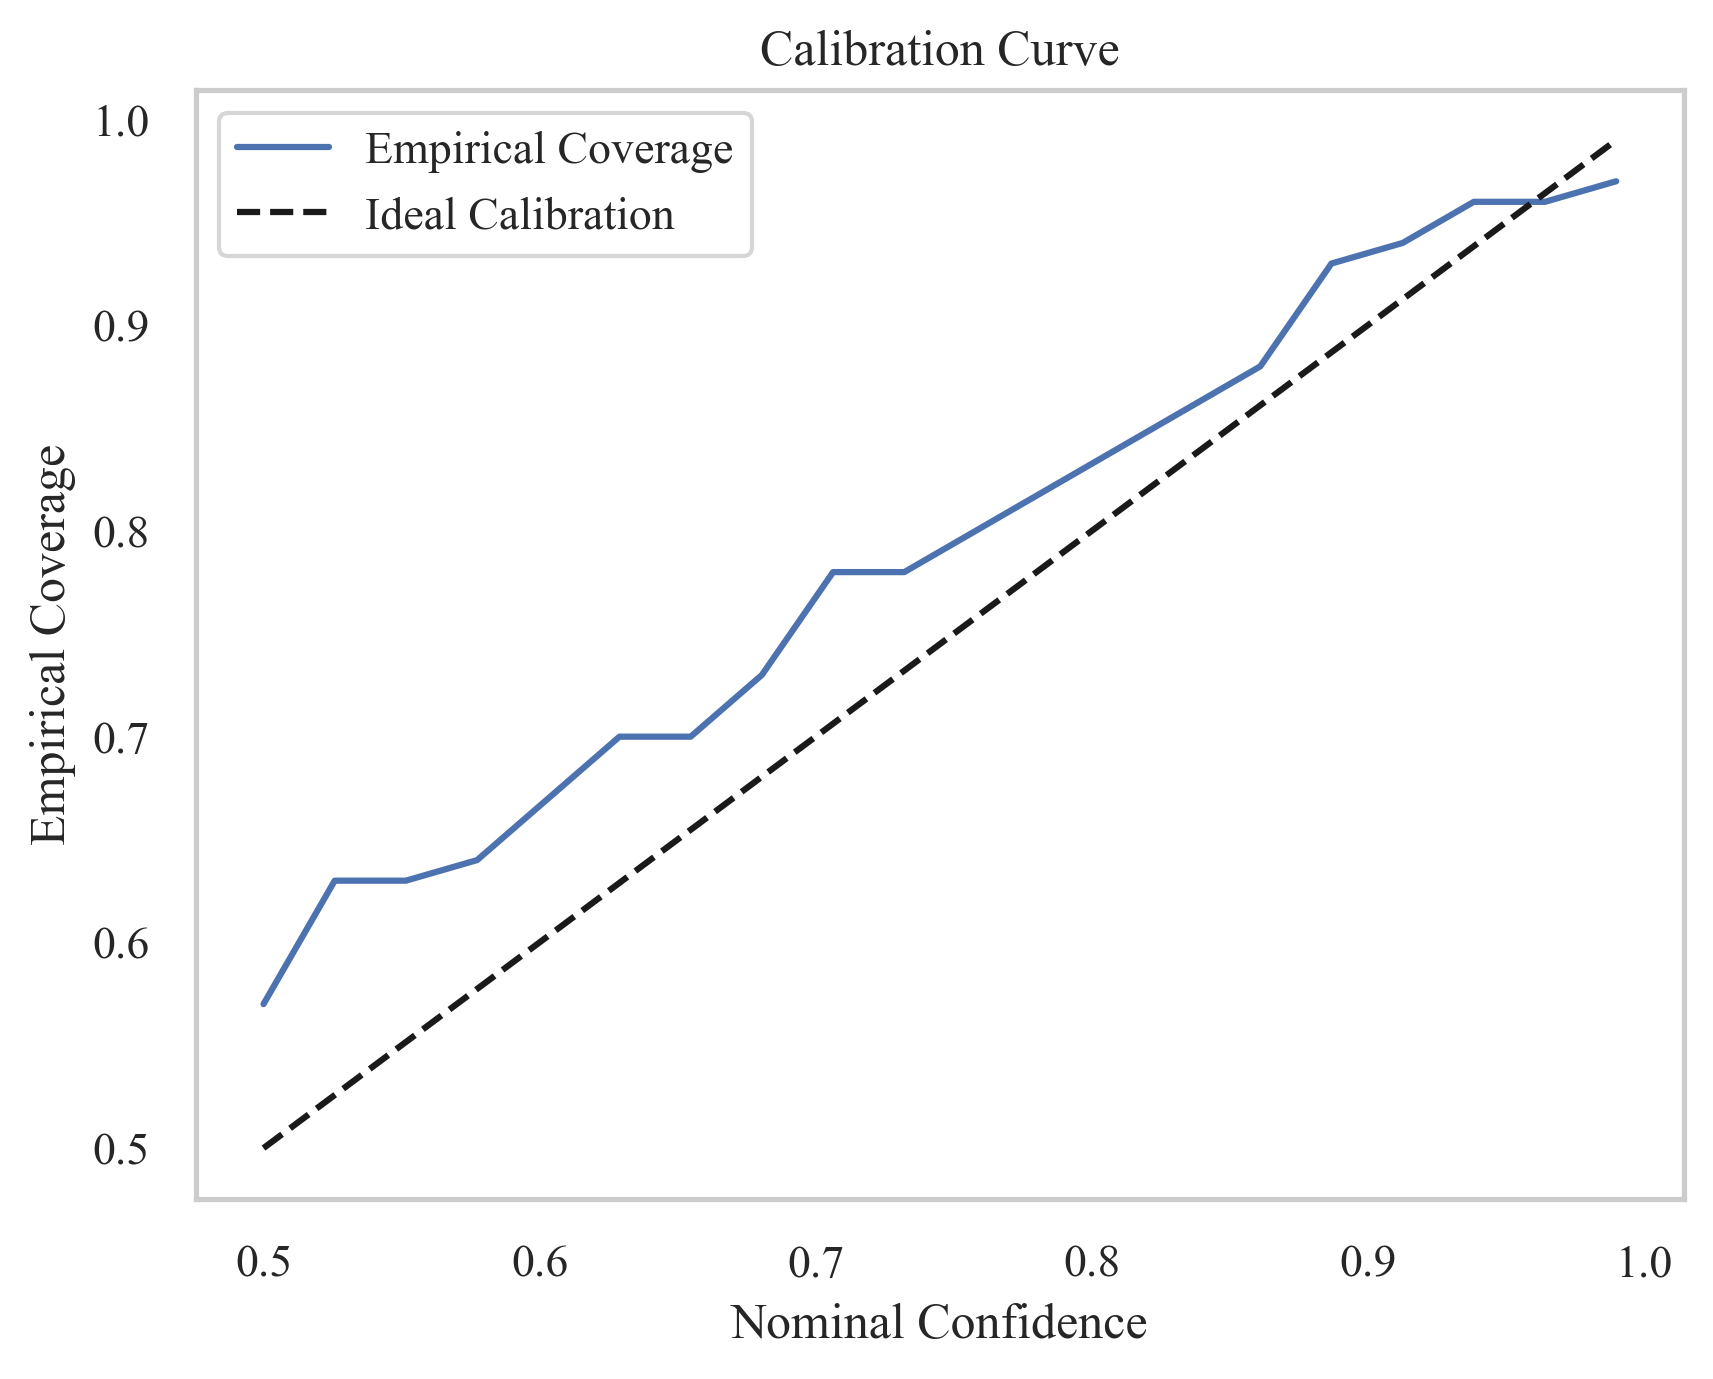

In [49]:
def plot_reliability(pred_means, pred_stds, targets):
    confidences = np.linspace(0.5, 0.99, 20)
    coverages = []

    for conf in confidences:
        z = st.norm.ppf(1 - (1 - conf)/2)
        lower = pred_means - z * pred_stds
        upper = pred_means + z * pred_stds
        coverage = np.mean((targets >= lower) & (targets <= upper))
        coverages.append(coverage)

    plt.plot(confidences, coverages, label='Empirical Coverage')
    plt.plot([0.5, 0.99], [0.5, 0.99], 'k--', label='Ideal Calibration')
    plt.xlabel("Nominal Confidence")
    plt.ylabel("Empirical Coverage")
    plt.legend()
    plt.grid()
    plt.title("Calibration Curve")
    plt.show()

plot_reliability(y_pred, uncertainty, y)

In [50]:
# confidence = 0.99  # Confidence level
# zeta = 2.576

# # Calculate confidence interval
# standard_error = uncertainty / np.sqrt(num_samples)  # Standard error of the mean
# margin_of_error = zeta * standard_error  # Margin of error

confidence = 0.95  # Confidence level
margin_of_error = k_opt * uncertainty  # Margin of error
margin_of_error = confidence * margin_of_error   # Margin of error

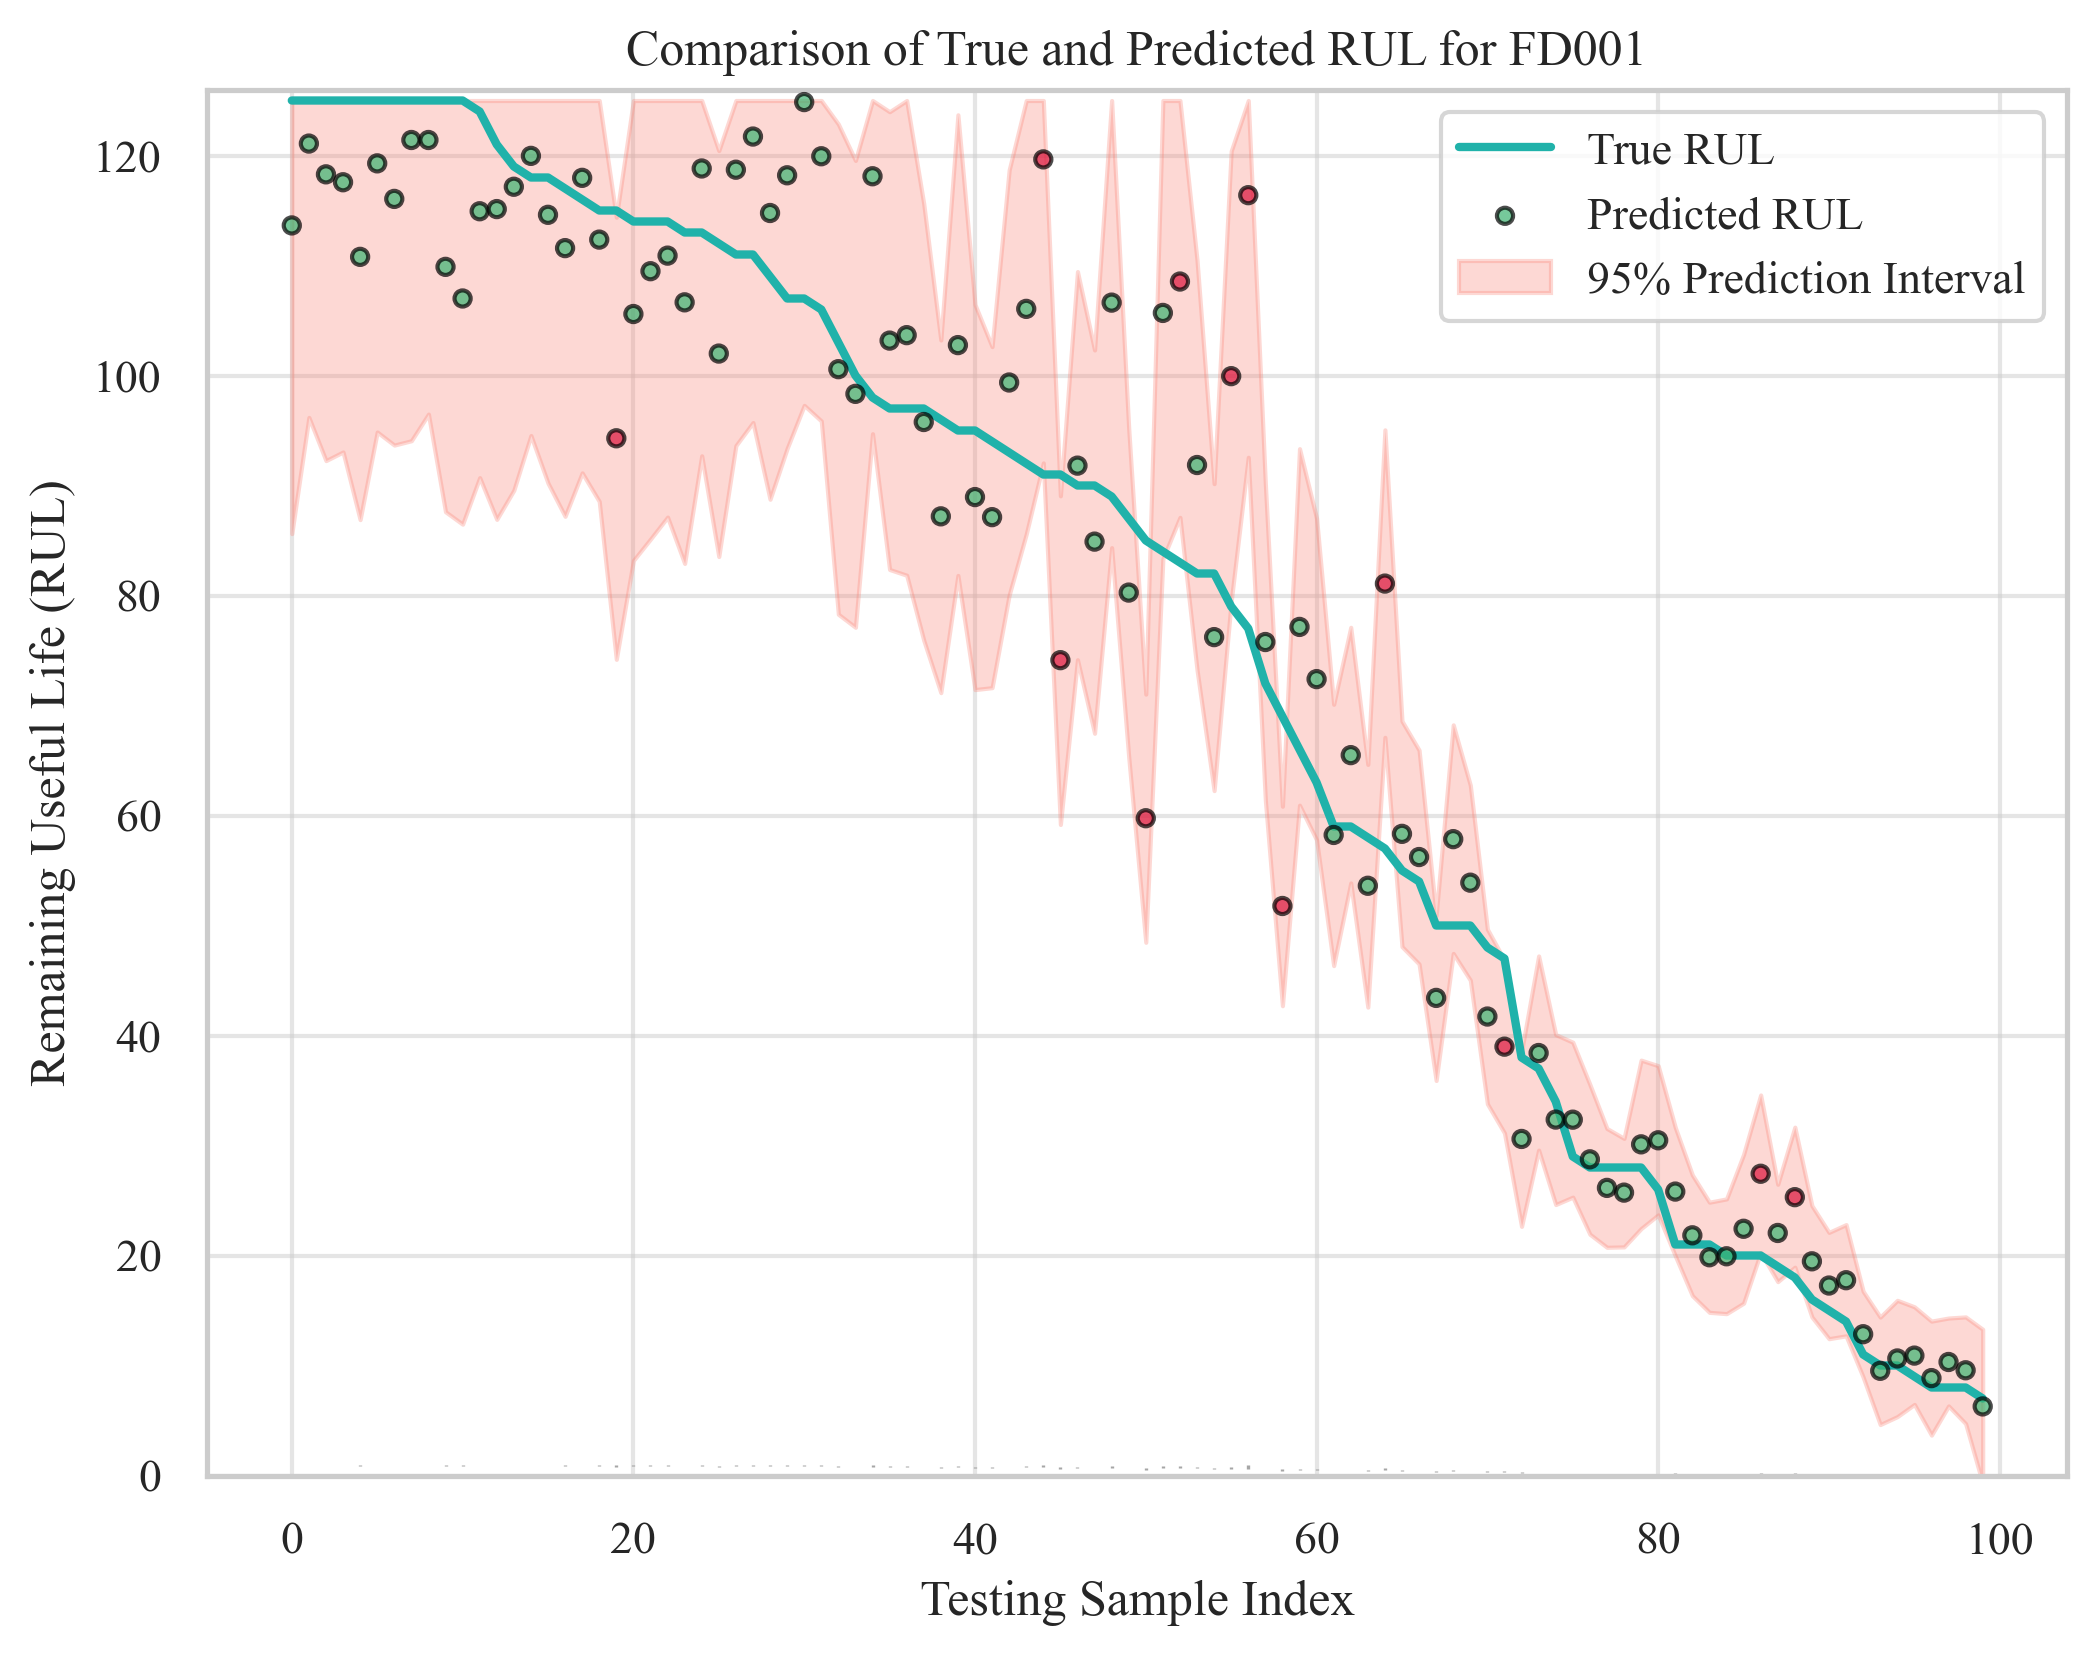

In [51]:
# Boolean mask: True if point is inside the confidence interval
inside_interval = (y >= y_pred - margin_of_error) & (y <= y_pred + margin_of_error)

# Assign colors: green if inside, red if outside
colors_interval = np.where(inside_interval, 'mediumseagreen', 'crimson')

plt.figure(figsize=(8, 6)) # Adjust figure size for publication
plt.ylim(0, MAX_RUL+1)

# True Values (more prominent line)
plt.plot(range(len(y)), y * MAX_RUL, label="True RUL", c="lightseagreen", linewidth=2)

# Predicted Values (smaller scatter points)
plt.scatter(range(len(y_pred)), y_pred * MAX_RUL, label="Predicted RUL", c=colors_interval, edgecolor="black", alpha=0.7, zorder=3, s=15) # reduced scatter point size to 15

# Vertical Lines (improved clarity)
for i in range(len(y)):
    plt.plot([i, i], [y_pred[i], y[i]], c="gray", linestyle="--", linewidth=0.8, alpha=0.7)

# Confidence Interval (adjusted opacity, more descriptive label)
plt.fill_between(
    range(len(y_pred)),
    (y_pred - margin_of_error)* MAX_RUL,
    np.minimum(y_pred + margin_of_error, 1) * MAX_RUL,
    color="salmon",
    alpha=0.3,  # Reduced opacity
    label=f"{int(confidence * 100)}% Prediction Interval"  # More accurate label
)

# Labels and Title (improved clarity)
dataset_name = file_name[:-4]
plt.xlabel("Testing Sample Index") # Removed unnecessary context from label
plt.ylabel("Remaining Useful Life (RUL)") # Removed unnecessary context from label
plt.title(f"Comparison of True and Predicted RUL for {dataset_name}") # Removed unnecessary context from title

# Legend and Grid
plt.legend()

# Save and Show
plt.savefig(f'figures/True_vs_PredictedRUL_simple_calibration_{file_name}.png')
plt.show()

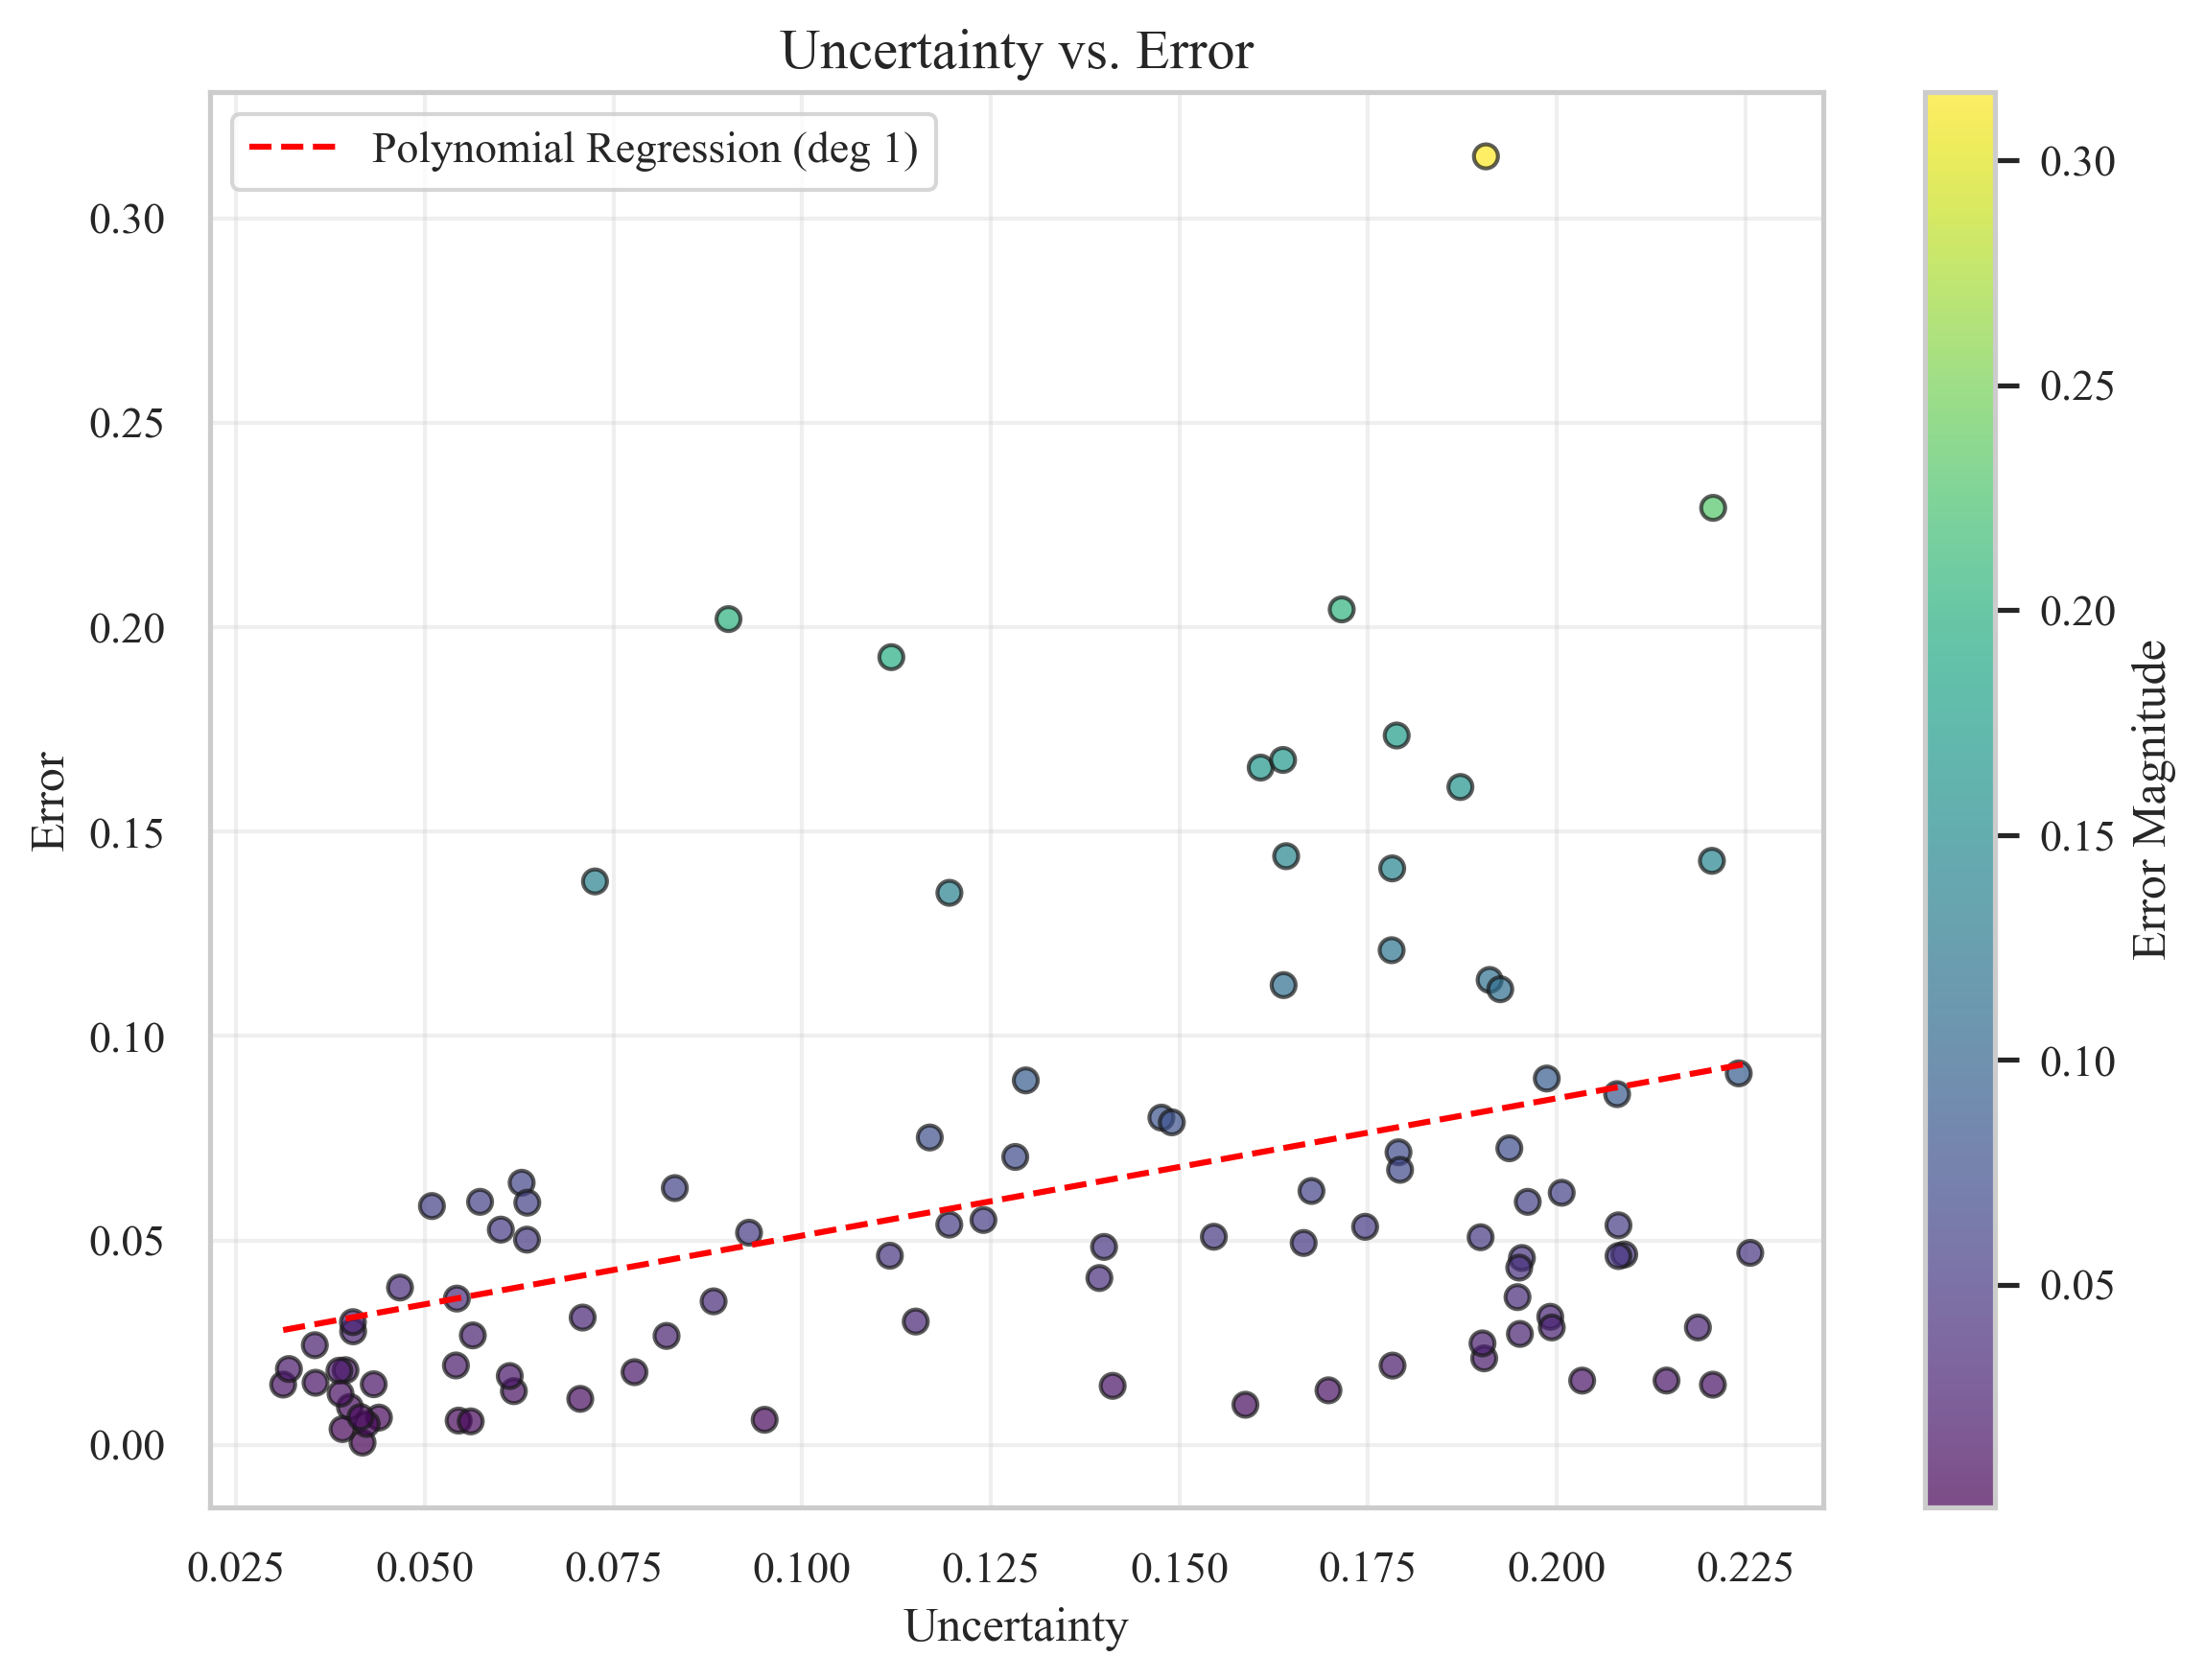

Correlation between uncertainty and error: 0.38
Mean error in high uncertainty regions: 0.07
Mean error in low uncertainty regions: 0.06


In [52]:
# Calculate errors and mean predictions
errors = np.abs(y_pred - y)

# Scatter plot with enhancements
plt.figure(figsize=(8, 6))
sc = plt.scatter(margin_of_error, errors, c=errors, cmap='viridis', alpha=0.7, edgecolor='k')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Error Magnitude')

# Add grid and labels
plt.grid(alpha=0.3)
plt.xlabel('Uncertainty', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.title('Uncertainty vs. Error', fontsize=14)

# Polynomial fit (degree 2 or higher)
degree = 1  # try 3, 4, etc. for more complex trends
z = np.polyfit(margin_of_error, errors, degree)
p = np.poly1d(z)

# Sort for smooth plotting
sorted_idx = np.argsort(margin_of_error)
plt.plot(margin_of_error[sorted_idx], p(margin_of_error[sorted_idx]),
         color='red', linestyle='--', label=f'Polynomial Regression (deg {degree})')

# plt.plot(uncertainty, p(uncertainty), color='red', linestyle='--', label='Trend Line')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig(f'figures\\UncertaintyVSError_simple_calibration_{file_name}.png', dpi=300, bbox_inches='tight')
plt.show()


# Compute statistics
correlation = np.corrcoef(margin_of_error, errors)[0, 1]
print(f"Correlation between uncertainty and error: {correlation:.2f}")

# Evaluate performance in high/low uncertainty regions
threshold = np.percentile(margin_of_error, 75)  # Upper 25% uncertainty
high_uncertainty_mask = margin_of_error > threshold
low_uncertainty_mask = margin_of_error <= threshold

high_uncertainty_error = errors[high_uncertainty_mask].mean()
low_uncertainty_error = errors[low_uncertainty_mask].mean()

print(f"Mean error in high uncertainty regions: {high_uncertainty_error:.2f}")
print(f"Mean error in low uncertainty regions: {low_uncertainty_error:.2f}")

In [53]:
def compute_coverage(y_true, y_pred, scaled_stds):
    """
    Computes the empirical coverage: the fraction of samples where
    the true value is inside the predicted confidence interval.
    
    Parameters:
    - y_true : np.array, ground truth values
    - y_pred : np.array, predicted means
    - scaled_stds : np.array, calibrated standard deviations (after applying k-scaling)

    Returns:
    - coverage : float, percentage of samples inside the confidence interval
    """
    lower_bounds = y_pred - scaled_stds
    upper_bounds = y_pred + scaled_stds

    # Check if the true value lies inside the interval
    inside = (y_true >= lower_bounds) & (y_true <= upper_bounds)

    # Calculate coverage as a percentage
    coverage = np.mean(inside) * 100.0
    return coverage


coverage = compute_coverage(y, y_pred, k_opt * uncertainty)
print(f"Ratio of coverage:{coverage}%")

Ratio of coverage:93.0%


<b>Binning by Mean Predictions</b>

In [54]:
# def calibrate_scaling_adaptive_by_mean(val_pred_means, val_stds, val_targets, num_bins=10, alpha=0.05):
#     """
#     Calibrates uncertainty scaling adaptively based on predicted mean value bins.
#     """
#     # Define bins based on predicted means, not errors.
#     mean_bins = np.linspace(np.min(val_pred_means), np.max(val_pred_means), num_bins + 1)
#     k_values = []

#     for i in range(num_bins):
#         bin_indices = np.where((val_pred_means >= mean_bins[i]) & (val_pred_means < mean_bins[i + 1]))[0]
#         if len(bin_indices) == 0:
#             k_values.append(1.0)  # Default if bin is empty.
#             continue

#         bin_means = val_pred_means[bin_indices]
#         bin_stds = val_stds[bin_indices]
#         bin_targets = val_targets[bin_indices]

#         def coverage_diff(k):
#             lower = bin_means - k * bin_stds
#             upper = bin_means + k * bin_stds
#             coverage = np.mean((bin_targets >= lower) & (bin_targets <= upper))
#             return abs((1 - alpha) - coverage)

#         result = optim.minimize_scalar(coverage_diff, bounds=(0.1, 5.0), method='bounded')
#         k_values.append(result.x)

#     return k_values, mean_bins


# def apply_adaptive_scaling_by_mean(pred_means, pred_stds, k_values, mean_bins):
#     """
#     Applies adaptive scaling based on predicted mean bins.
#     """
#     scaled_stds = np.zeros_like(pred_stds)
#     for i in range(len(k_values)):
#         bin_indices = np.where((pred_means >= mean_bins[i]) & (pred_means < mean_bins[i + 1]))[0]
#         scaled_stds[bin_indices] = pred_stds[bin_indices] * k_values[i]
#     return scaled_stds


# # === Example Usage ===

# # Fit k-values using validation data:
# k_values, mean_bins = calibrate_scaling_adaptive_by_mean(val_pred_means, val_pred_stds, val_targets, num_bins=5, alpha=0.05)

# # Apply learned k-values to a new (or same) dataset:
# scaled_stds = apply_adaptive_scaling_by_mean(val_pred_means, val_pred_stds, k_values, mean_bins)

# print("K values per predicted mean bin:", k_values)

In [55]:
# bin_midpoints = 0.5 * (mean_bins[:-1] + mean_bins[1:])
# plt.plot(bin_midpoints, k_values, marker='o')
# plt.xlabel('Predicted Mean (μ̂)')
# plt.ylabel('Learned Scaling Factor (k)')
# plt.title('Adaptive Scaling Factor per Predicted Mean Bin')
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.show()

In [56]:
# plt.figure(figsize=(8, 6)) # Adjust figure size for publication

# plt.ylim(0, MAX_RUL+1)
# # True Values (more prominent line)
# plt.plot(range(len(y)), y * MAX_RUL, label="True RUL", c="lightseagreen", linewidth=2)

# # Boolean mask: True if point is inside the confidence interval
# inside_interval = (y >= y_pred - scaled_uncertaintity) & (y <= y_pred + scaled_uncertaintity)

# # Assign colors: green if inside, red if outside
# colors_interval = np.where(inside_interval, 'mediumseagreen', 'crimson')

# # Predicted Values (smaller scatter points)
# plt.scatter(range(len(y_pred)), y_pred * MAX_RUL, label="Predicted RUL", c=colors_interval, edgecolor="black", alpha=0.7, zorder=3, s=15) # reduced scatter point size to 15

# # Vertical Lines (improved clarity)
# for i in range(len(y)):
#     plt.plot([i, i], [y_pred[i]*MAX_RUL, y[i]*MAX_RUL], c="gray", linestyle="--", linewidth=0.8, alpha=0.7)

# # Confidence Interval (adjusted opacity, more descriptive label)
# plt.fill_between(
#     range(len(y_pred)),
#     (y_pred - scaled_uncertaintity) * MAX_RUL,
#     np.minimum(y_pred + scaled_uncertaintity, 1) * MAX_RUL,
#     color="salmon",
#     alpha=0.3,  # Reduced opacity
#     label=f"{int(confidence * 100)}% Prediction Interval"  # More accurate label
# )

# # Labels and Title (improved clarity)
# dataset_name = file_name[:-4]
# plt.xlabel("Testing Sample Index") # Removed unnecessary context from label
# plt.ylabel("Remaining Useful Life (RUL)") # Removed unnecessary context from label
# plt.title(f"Comparison of True and Predicted RUL for {dataset_name}") # Removed unnecessary context from title

# # Legend and Grid
# plt.legend()

# # Save and Show
# plt.savefig(f'figures/True_vs_PredictedRUL_simple_calibration_with_bins_{file_name}.png')
# plt.show()

In [57]:
# # Scatter plot with enhancements
# plt.figure(figsize=(8, 6))
# sc = plt.scatter(scaled_uncertaintity, test_errors, c=test_errors, cmap='viridis', alpha=0.7, edgecolor='k')

# # Add colorbar
# cbar = plt.colorbar(sc)
# cbar.set_label('Error Magnitude')

# # Add grid and labels
# plt.grid(alpha=0.3)
# plt.xlabel('Uncertainty', fontsize=12)
# plt.ylabel('Error', fontsize=12)
# plt.title('Uncertainty vs. Error', fontsize=14)

# # Polynomial fit (degree 2 or higher)
# degree = 1  # try 3, 4, etc. for more complex trends
# z = np.polyfit(scaled_uncertaintity, test_errors, degree)
# p = np.poly1d(z)

# # Sort for smooth plotting
# # sorted_idx = np.argsort(scaled_uncertaintity)
# plt.plot(scaled_uncertaintity, p(scaled_uncertaintity),
#           color='red', linestyle='--', label=f'Polynomial Regression (deg {degree})')

# # plt.plot(uncertainty, p(uncertainty), color='red', linestyle='--', label='Trend Line')

# # Add legend
# plt.legend()

# # Show the plot
# plt.tight_layout()
# plt.savefig(f'figures\\UncertaintyVSError_simple_calibration_with_bins_{file_name}.png', dpi=300, bbox_inches='tight')
# plt.show()


# # Compute statistics
# correlation = np.corrcoef(scaled_uncertaintity, test_errors)[0, 1]
# print(f"Correlation between uncertainty and error: {correlation:.2f}")

# # Evaluate performance in high/low uncertainty regions
# threshold = np.percentile(scaled_uncertaintity, 75)  # Upper 25% uncertainty
# high_uncertainty_mask = scaled_uncertaintity > threshold
# low_uncertainty_mask = scaled_uncertaintity <= threshold

# high_uncertainty_error = test_errors[high_uncertainty_mask].mean()
# low_uncertainty_error = test_errors[low_uncertainty_mask].mean()

# print(f"Mean error in high uncertainty regions: {high_uncertainty_error:.2f}")
# print(f"Mean error in low uncertainty regions: {low_uncertainty_error:.2f}")

<b> Callibration with Clustering Algorithm <b>

In [58]:
from scipy import optimize as optim
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

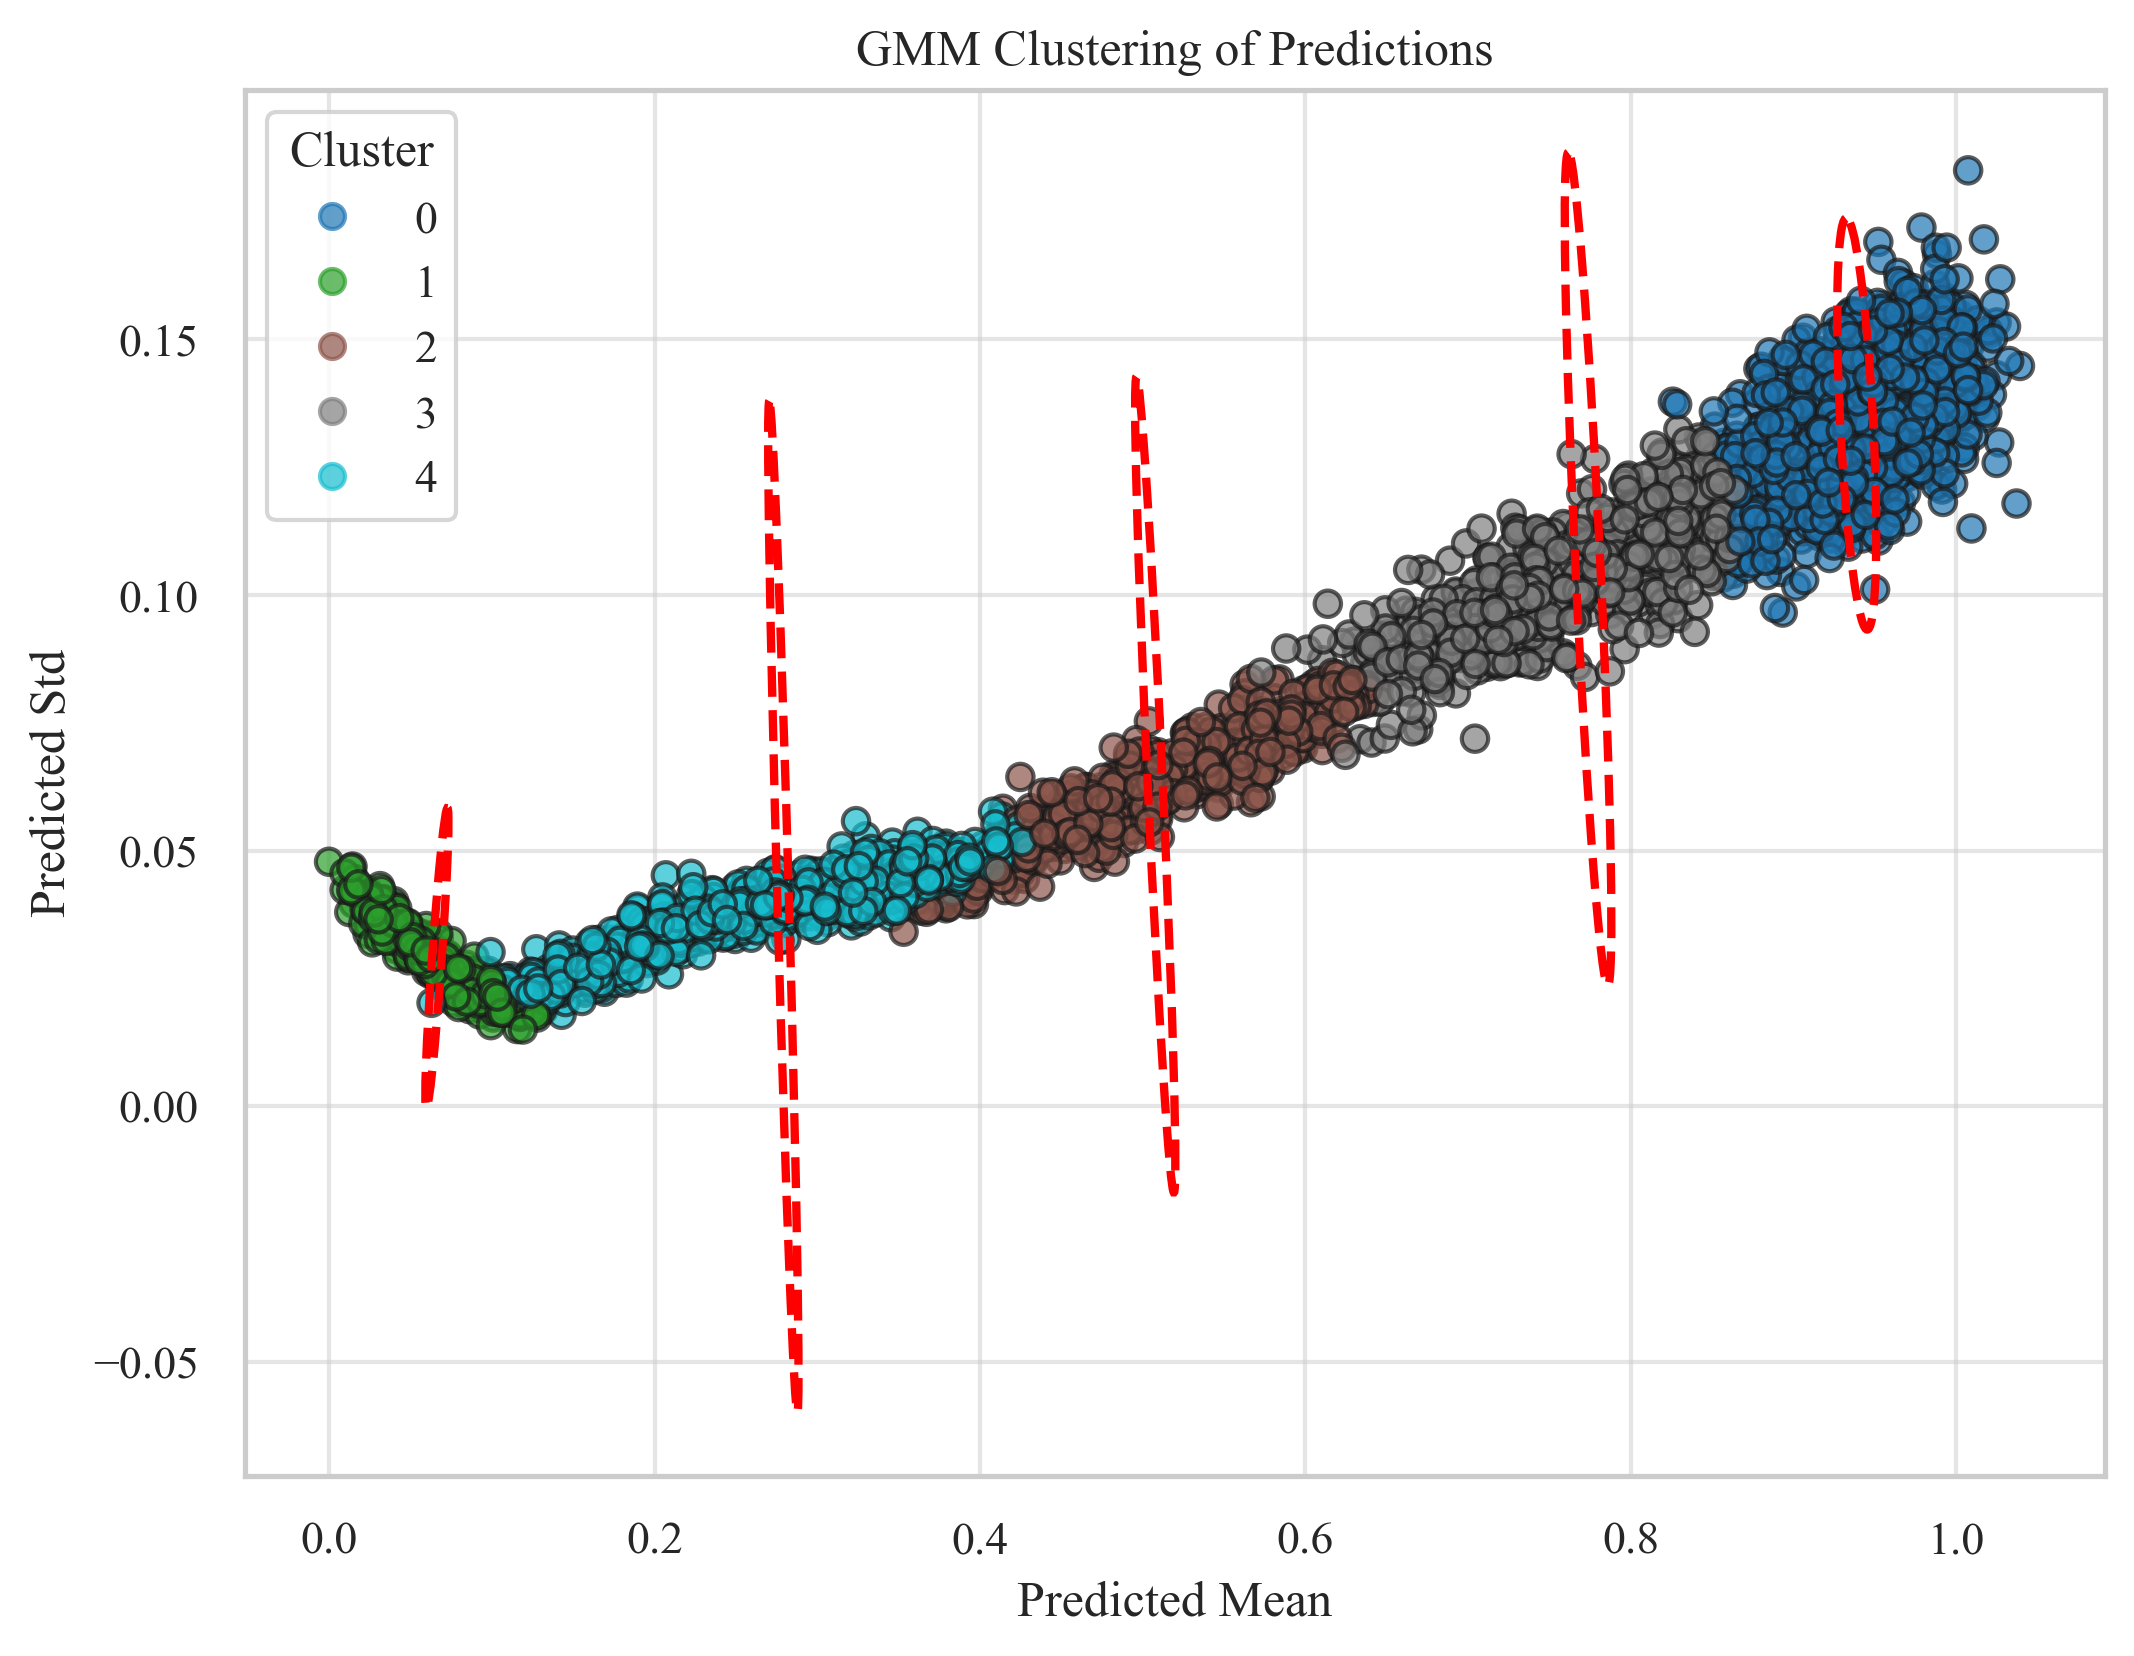

In [60]:
from matplotlib.patches import Ellipse

X = np.vstack([val_pred_means, val_pred_stds]).T

# Fit Gaussian Mixture Model
num_components = 5
gmm = GaussianMixture(n_components=num_components, random_state=42).fit(X)
cluster_ids = gmm.predict(X)

# Plot clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(val_pred_means, val_pred_stds, c=cluster_ids, cmap='tab10', s=40, edgecolor='k', alpha=0.7)

# Plot Gaussian ellipses
def plot_gmm_ellipses(gmm, ax):
    for n in range(gmm.n_components):
        mean = gmm.means_[n]
        cov = gmm.covariances_[n]

        if cov.shape == (2, 2):  # Full covariance matrix
            eigvals, eigvecs = np.linalg.eigh(cov)
            angle = np.degrees(np.arctan2(*eigvecs[:, 1][::-1]))
            width, height = 2 * np.sqrt(eigvals)  # 1-sigma contour
        else:  # Diagonal or spherical covariance
            width, height = 2 * np.sqrt(cov.ravel())
            angle = 0

        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                          edgecolor='red', facecolor='none', linestyle='--', lw=2)
        ax.add_patch(ellipse)

ax = plt.gca()
plot_gmm_ellipses(gmm, ax)

plt.xlabel("Predicted Mean")
plt.ylabel("Predicted Std")
plt.title("GMM Clustering of Predictions")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.grid(True)
plt.show()

In [61]:
def calibrate_scaling_by_clustering(val_pred_means, val_stds, val_targets, num_clusters=3, alpha=0.05):
    """
    Clusters predictions by (mean, std) and calibrates a scaling factor k for each cluster.
    """
    X = np.vstack([val_pred_means, val_stds]).T
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(X)
    cluster_ids = kmeans.predict(X)

    k_values = []

    for cluster in range(num_clusters):
        bin_indices = np.where(cluster_ids == cluster)[0]
        if len(bin_indices) == 0:
            k_values.append(1.0)  # Default scaling if no samples fall here
            continue

        bin_means = val_pred_means[bin_indices]
        bin_stds = val_stds[bin_indices]
        bin_targets = val_targets[bin_indices]

        def coverage_diff(k):
            lower = bin_means - k * bin_stds
            upper = bin_means + k * bin_stds
            coverage = np.mean((bin_targets >= lower) & (bin_targets <= upper))
            return abs((1 - alpha) - coverage)

        result = optim.minimize_scalar(coverage_diff, bounds=(0.1, 5.0), method='bounded')
        k_values.append(result.x)

    return kmeans, k_values

def calibrate_scaling_by_gmm(val_pred_means, val_stds, val_targets, num_components=5, alpha=0.05):
    """
    Calibrates scaling factors k using Gaussian Mixture Model clustering on predicted mean and std.
    """
    X = np.vstack([val_pred_means, val_stds]).T
    gmm = GaussianMixture(n_components=num_components, random_state=42).fit(X)
    cluster_ids = gmm.predict(X)

    k_values = []
    for cluster in range(num_components):
        bin_indices = np.where(cluster_ids == cluster)[0]
        if len(bin_indices) == 0:
            k_values.append(1.0)  # Default scaling for empty clusters
            continue

        bin_means = val_pred_means[bin_indices]
        bin_stds = val_stds[bin_indices]
        bin_targets = val_targets[bin_indices]

        def coverage_diff(k):
            lower = bin_means - k * bin_stds
            upper = bin_means + k * bin_stds
            coverage = np.mean((bin_targets >= lower) & (bin_targets <= upper))
            return abs((1 - alpha) - coverage)

        result = optim.minimize_scalar(coverage_diff, bounds=(0.1, 5.0), method='bounded')
        k_values.append(result.x)

    return gmm, k_values

def calibrate_scaling_by_dbscan(val_pred_means, val_stds, val_targets, eps=0.1, min_samples=10, alpha=0.05):
    """
    Calibrates scaling factors k using DBSCAN clustering on predicted mean and std.
    """
    X = np.vstack([val_pred_means, val_stds]).T
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    cluster_ids = dbscan.labels_  # -1 means outlier

    unique_clusters = np.unique(cluster_ids)
    k_values = {}

    for cluster in unique_clusters:
        bin_indices = np.where(cluster_ids == cluster)[0]
        if len(bin_indices) == 0:
            continue  # Shouldn't happen

        bin_means = val_pred_means[bin_indices]
        bin_stds = val_stds[bin_indices]
        bin_targets = val_targets[bin_indices]

        def coverage_diff(k):
            lower = bin_means - k * bin_stds
            upper = bin_means + k * bin_stds
            coverage = np.mean((bin_targets >= lower) & (bin_targets <= upper))
            return abs((1 - alpha) - coverage)

        result = optim.minimize_scalar(coverage_diff, bounds=(0.1, 5.0), method='bounded')
        k_values[cluster] = result.x

    return dbscan, k_values


def apply_scaling_by_clustering(pred_means, pred_stds, kmeans, k_values):
    """
    Applies cluster-based scaling using learned k values.
    """
    X = np.vstack([pred_means, pred_stds]).T
    cluster_ids = kmeans.predict(X)

    scaled_stds = np.zeros_like(pred_stds)
    for i, cluster_id in enumerate(cluster_ids):
        scaled_stds[i] = pred_stds[i] * k_values[cluster_id]

    return scaled_stds

def apply_scaling_by_gmm(pred_means, pred_stds, gmm, k_values):
    """
    Applies scaling using GMM-clustered k values.
    """
    X = np.vstack([pred_means, pred_stds]).T
    cluster_ids = gmm.predict(X)

    scaled_stds = np.zeros_like(pred_stds)
    for i, cluster_id in enumerate(cluster_ids):
        scaled_stds[i] = pred_stds[i] * k_values[cluster_id]

    return scaled_stds

def apply_scaling_by_dbscan(pred_means, pred_stds, dbscan, k_values):
    """
    Applies scaling using DBSCAN-clustered k values. Assigns k=1.0 to outliers.
    """
    X = np.vstack([pred_means, pred_stds]).T
    cluster_ids = dbscan.fit_predict(X)  # Predict via re-fit for DBSCAN.

    scaled_stds = np.zeros_like(pred_stds)
    for i, cluster_id in enumerate(cluster_ids):
        k = k_values.get(cluster_id, 1.0)  # Outliers get k=1.0
        scaled_stds[i] = pred_stds[i] * k

    return scaled_stds


# === Example Usage ===

# Fit k-values on validation data:
# kmeans_model, k_values = calibrate_scaling_by_clustering(val_pred_means, val_pred_stds, val_targets, num_clusters=3, alpha=0.05)
gmm_model, k_values = calibrate_scaling_by_gmm(val_pred_means, val_pred_stds, val_targets, num_components=5, alpha=0.05)
# dbscan_model, k_values = calibrate_scaling_by_dbscan(val_pred_means, val_pred_stds, val_targets, eps=0.1, min_samples=10, alpha=0.05)

# Apply to test data:
# scaled_stds = apply_scaling_by_clustering(y_pred, uncertainty, kmeans_model, k_values)
scaled_stds =  apply_scaling_by_gmm(y_pred, uncertainty, gmm_model, k_values)
# scaled_stds =  apply_scaling_by_dbscan(y_pred, uncertainty, dbscan_model, k_values)

print("Cluster-wise learned k values:", k_values)


Cluster-wise learned k values: [1.1917236919736829, 1.3892839005870878, 1.6849092284948128, 1.9716384170519674, 1.5714765976005327]


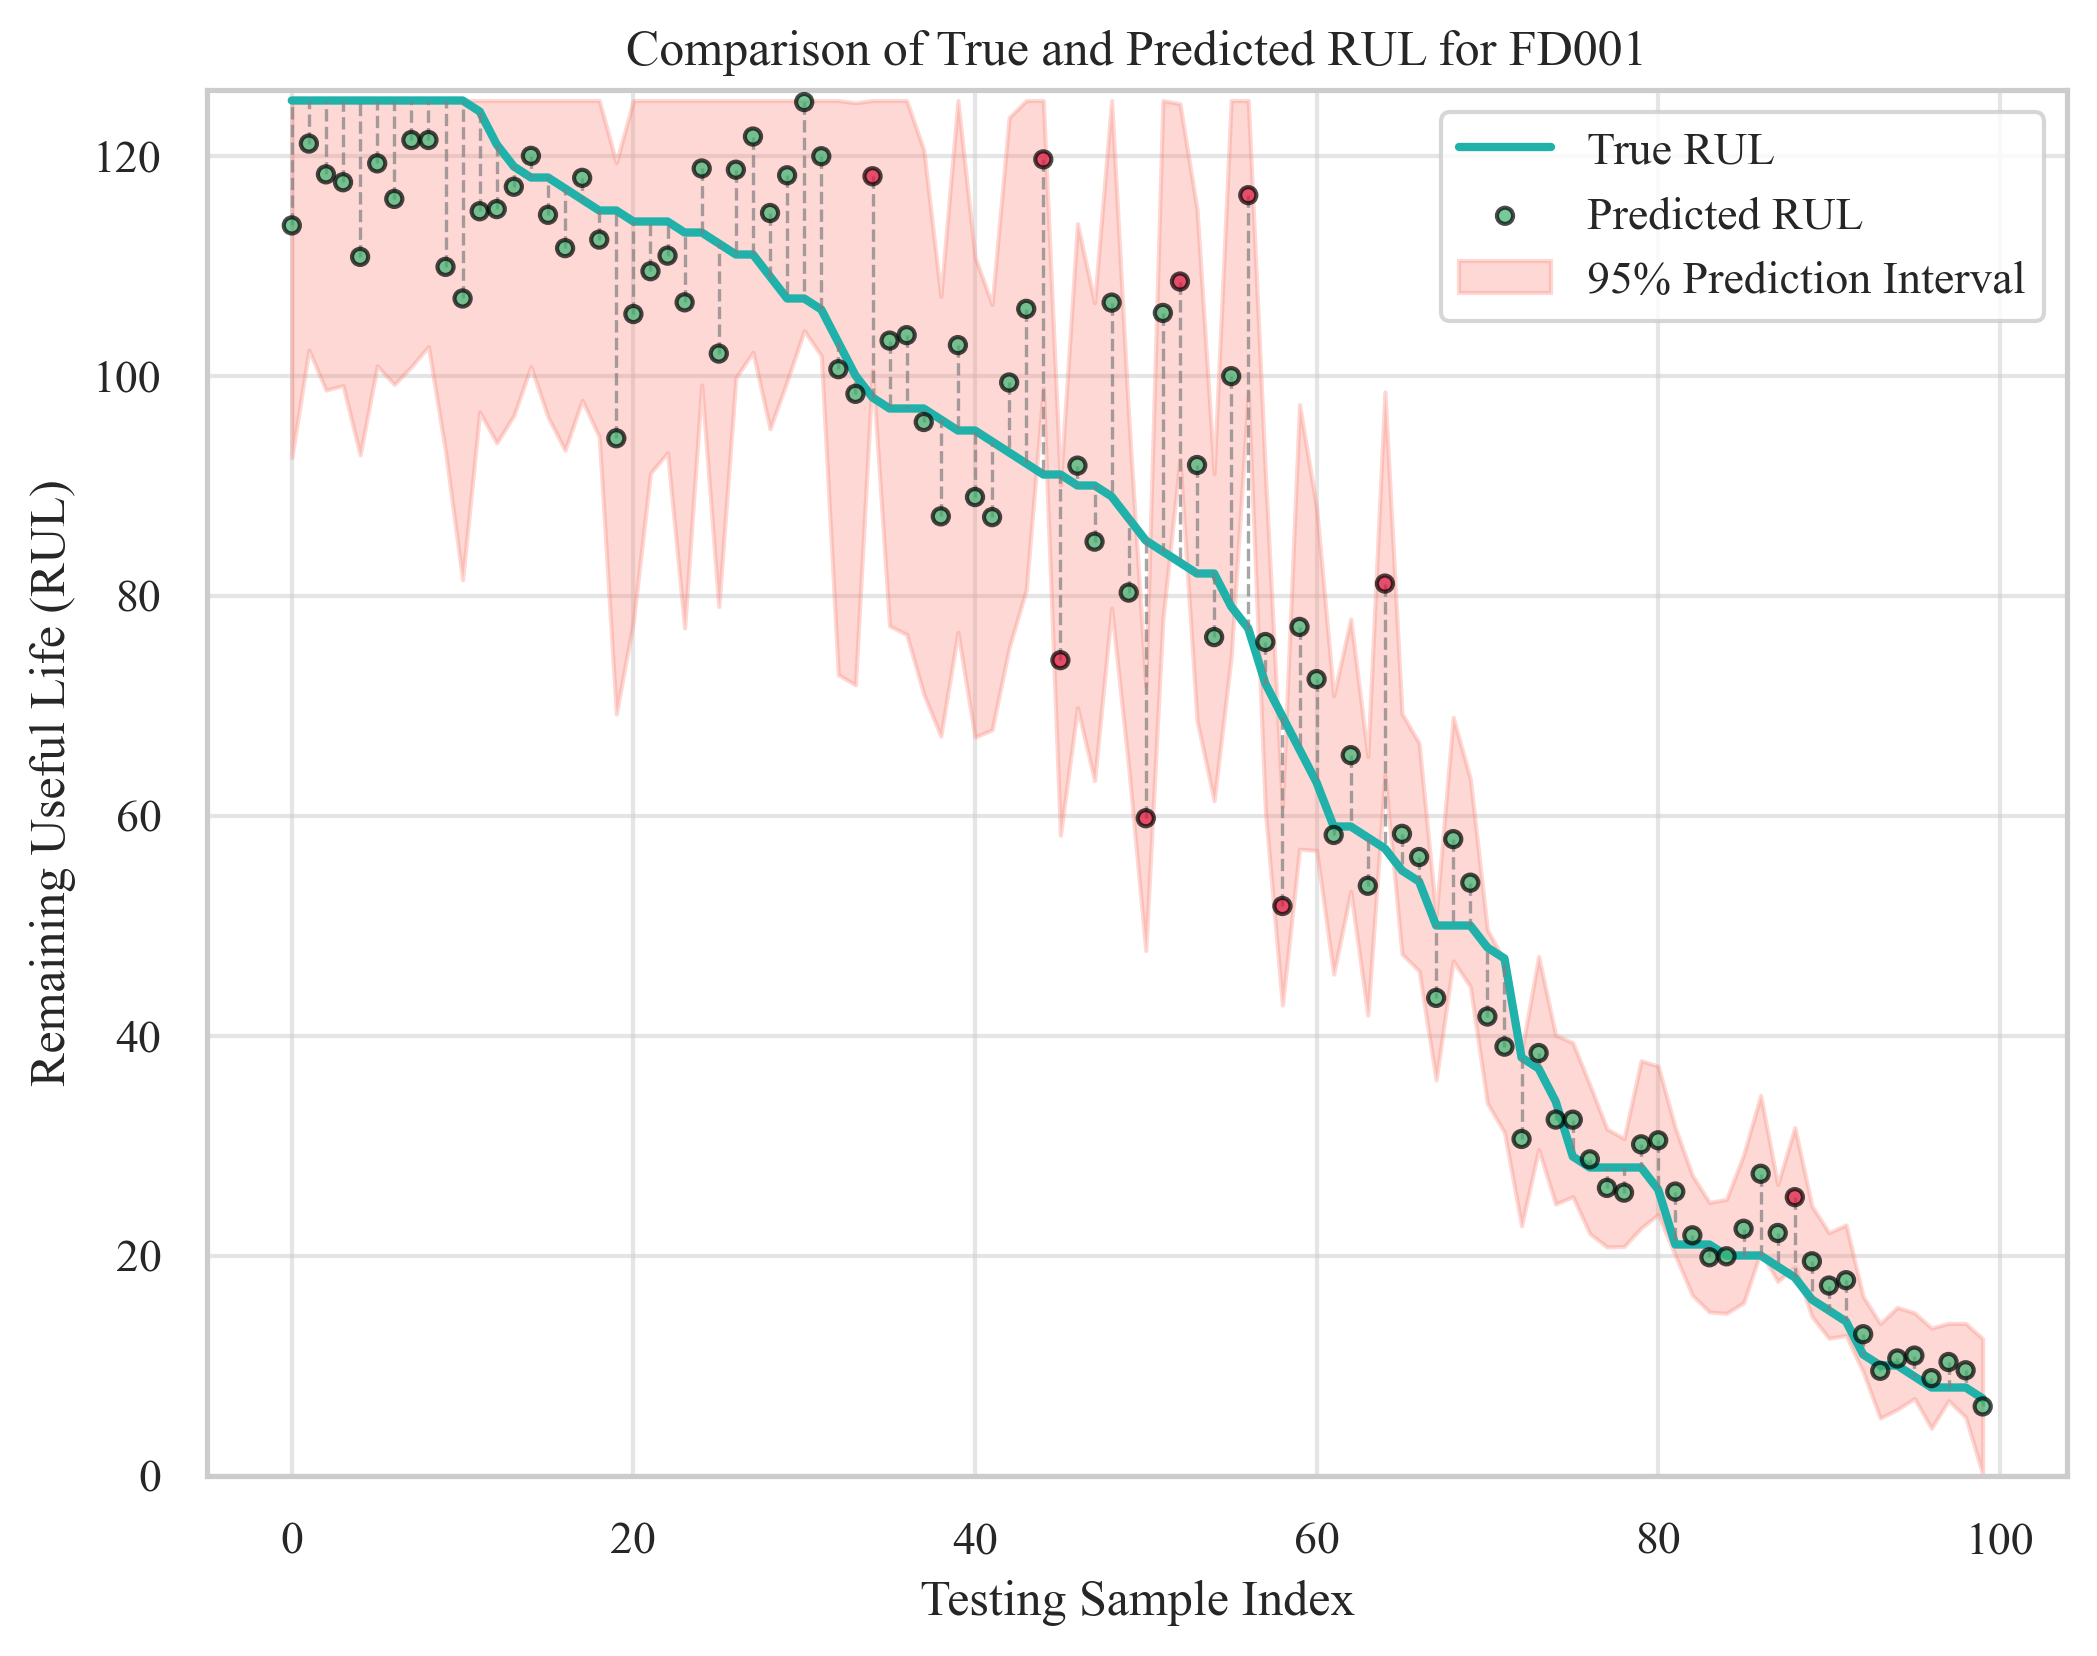

In [62]:
plt.figure(figsize=(8, 6)) # Adjust figure size for publication

plt.ylim(0, MAX_RUL+1)
# True Values (more prominent line)
plt.plot(range(len(y)), y * MAX_RUL, label="True RUL", c="lightseagreen", linewidth=2)

# Boolean mask: True if point is inside the confidence interval
inside_interval = (y >= y_pred - scaled_stds) & (y <= y_pred + scaled_stds)

# Assign colors: green if inside, red if outside
colors_interval = np.where(inside_interval, 'mediumseagreen', 'crimson')

# Predicted Values (smaller scatter points)
plt.scatter(range(len(y_pred)), y_pred * MAX_RUL, label="Predicted RUL", c=colors_interval, edgecolor="black", alpha=0.7, zorder=3, s=15) # reduced scatter point size to 15

# Vertical Lines (improved clarity)
for i in range(len(y)):
    plt.plot([i, i], [y_pred[i]*MAX_RUL, y[i]*MAX_RUL], c="gray", linestyle="--", linewidth=0.8, alpha=0.7)

# Confidence Interval (adjusted opacity, more descriptive label)
plt.fill_between(
    range(len(y_pred)),
    (y_pred - 0.95*scaled_stds) * MAX_RUL,
    np.minimum(y_pred + 0.95*scaled_stds, 1) * MAX_RUL,
    color="salmon",
    alpha=0.3,  # Reduced opacity
    label=f"{int(confidence * 100)}% Prediction Interval"  # More accurate label
)

# Labels and Title (improved clarity)
dataset_name = file_name[:-4]
plt.xlabel("Testing Sample Index") # Removed unnecessary context from label
plt.ylabel("Remaining Useful Life (RUL)") # Removed unnecessary context from label
plt.title(f"Comparison of True and Predicted RUL for {dataset_name}") # Removed unnecessary context from title

# Legend and Grid
plt.legend()

# Save and Show
plt.savefig(f'figures/True_vs_PredictedRUL_calibration_with_clustering_bins_{file_name}.png')
plt.show()

In [63]:
def compute_coverage(y_true, y_pred, scaled_stds):
    """
    Computes the empirical coverage: the fraction of samples where
    the true value is inside the predicted confidence interval.
    
    Parameters:
    - y_true : np.array, ground truth values
    - y_pred : np.array, predicted means
    - scaled_stds : np.array, calibrated standard deviations (after applying k-scaling)

    Returns:
    - coverage : float, percentage of samples inside the confidence interval
    """
    lower_bounds = y_pred - scaled_stds
    upper_bounds = y_pred + scaled_stds

    # Check if the true value lies inside the interval
    inside = (y_true >= lower_bounds) & (y_true <= upper_bounds)

    # Calculate coverage as a percentage
    coverage = np.mean(inside) * 100.0
    return coverage


coverage = compute_coverage(y, y_pred, scaled_stds)
print(f"Ratio of coverage:{coverage}%")

Ratio of coverage:91.0%


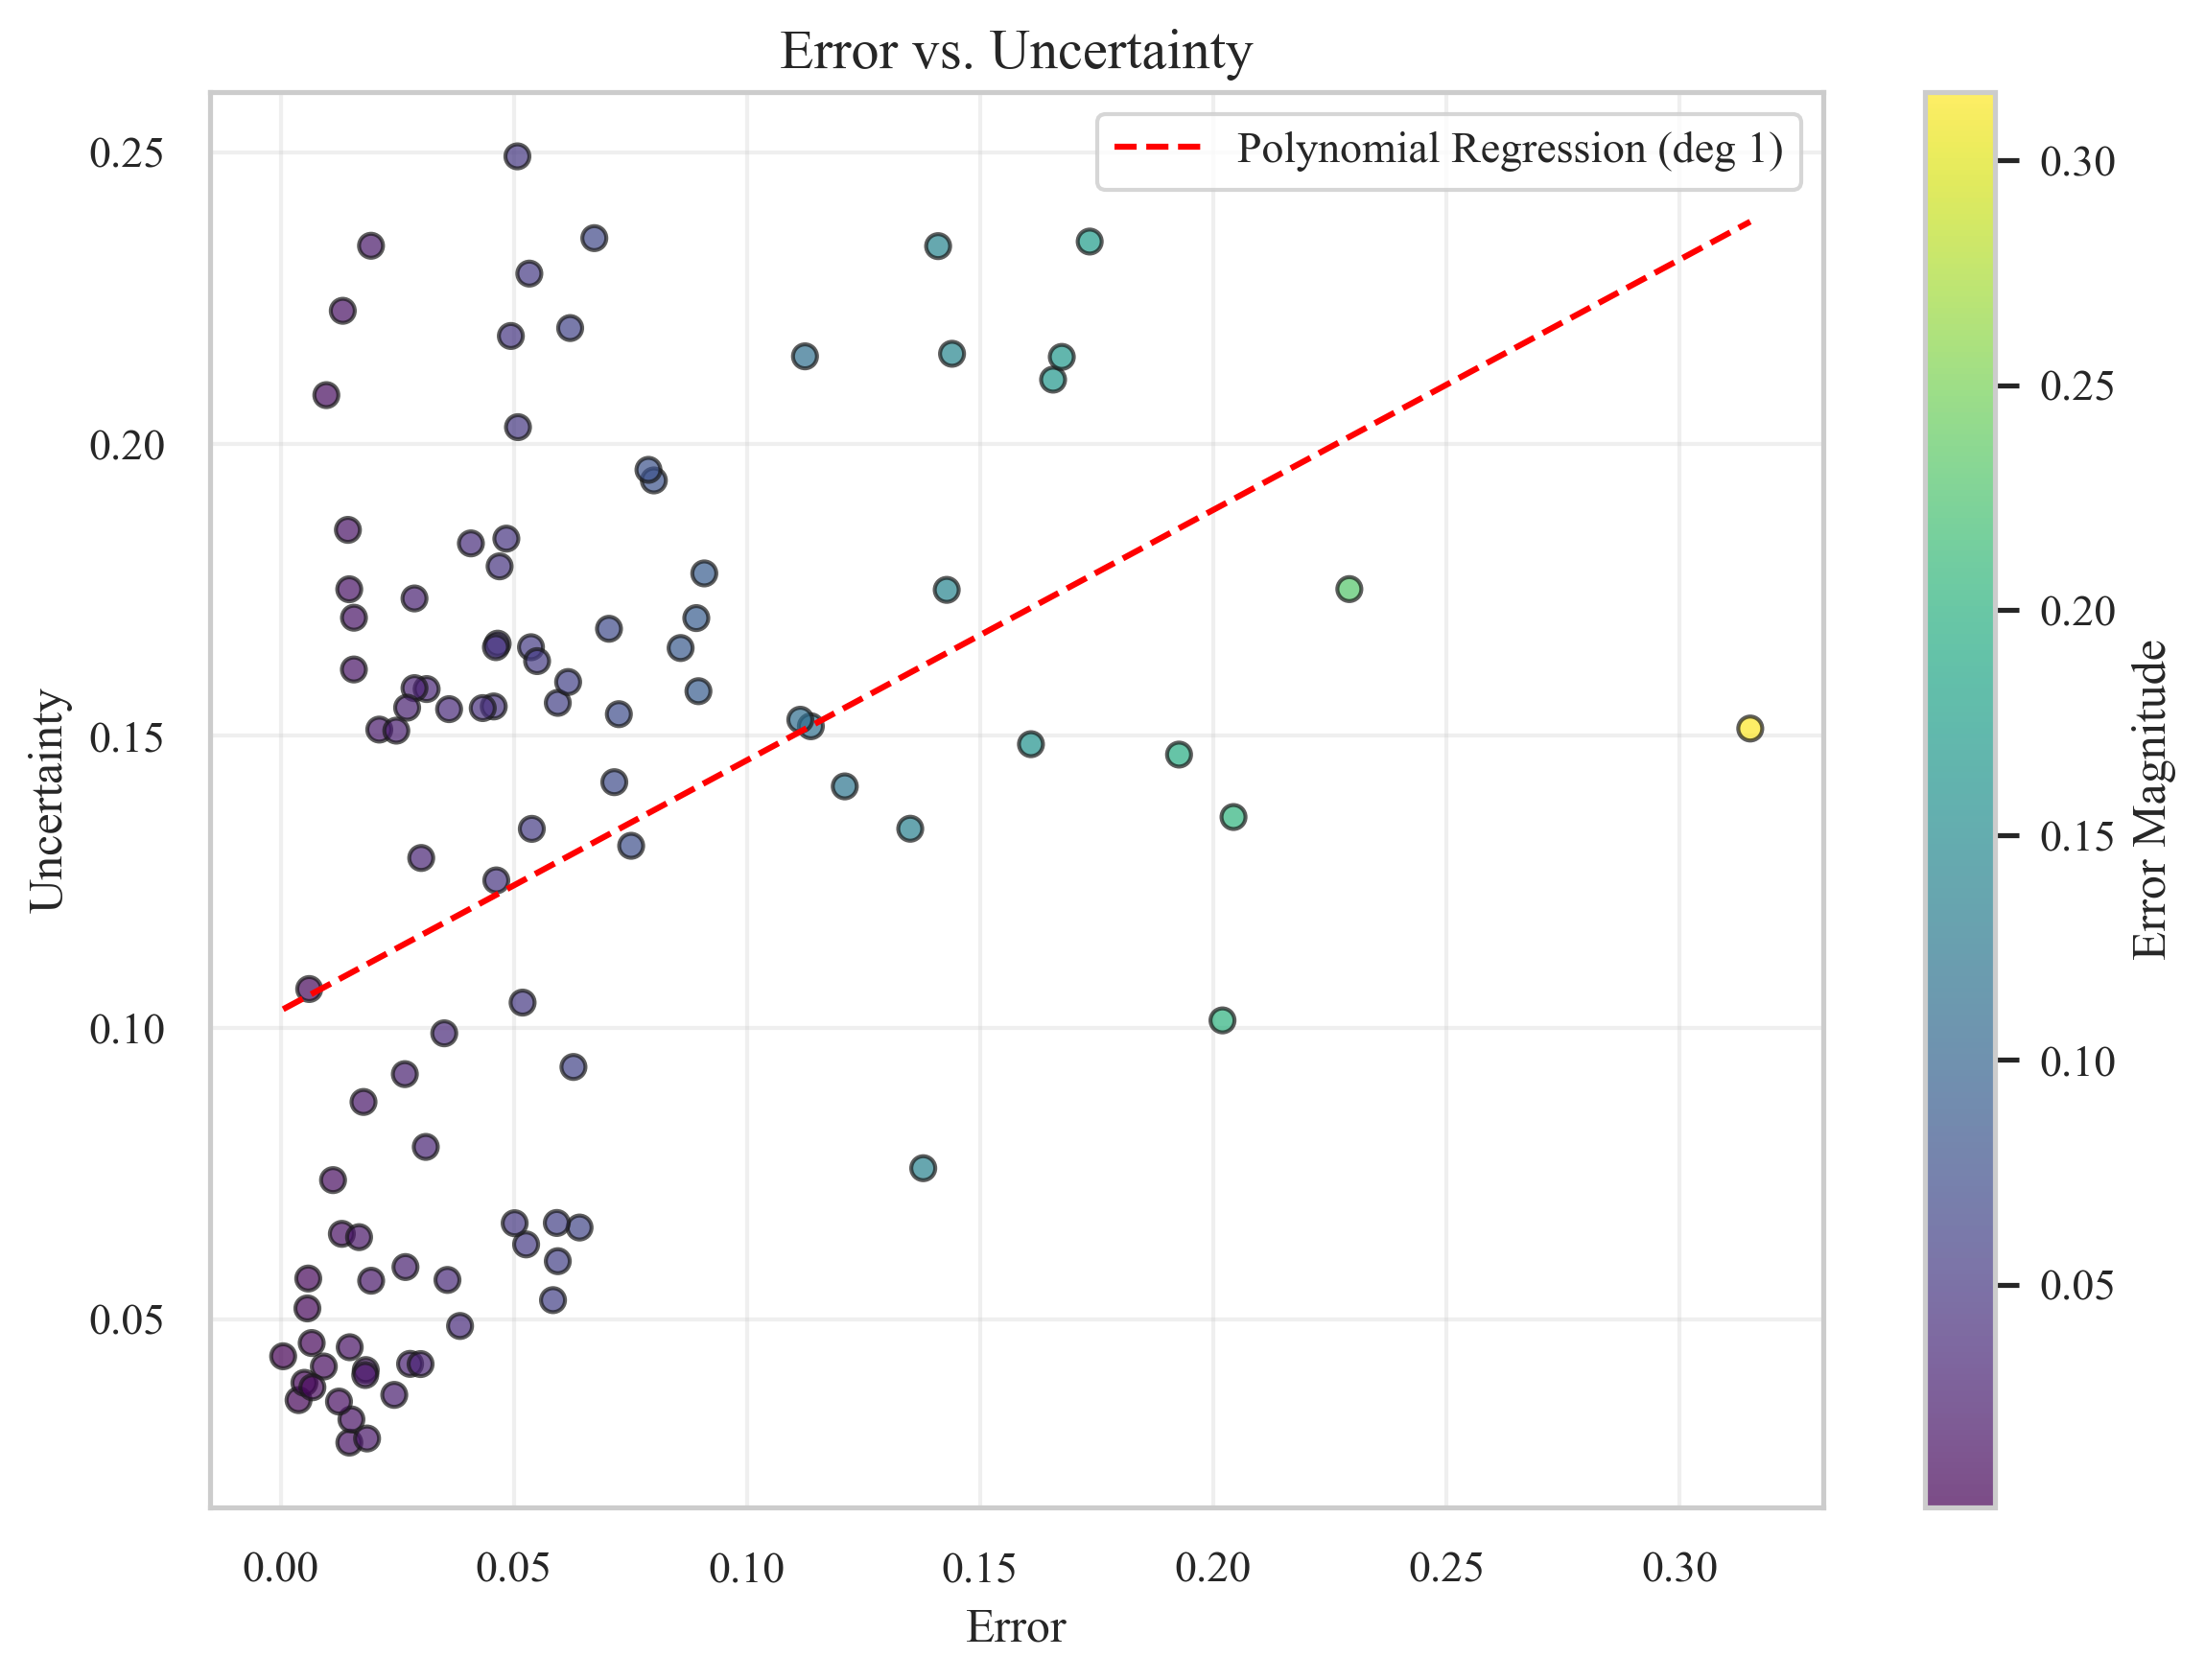

Correlation between error and uncertainty: 0.39
Mean uncertainty in high error regions: 0.17
Mean uncertainty in low error regions: 0.12


In [65]:
# Calculate errors and mean predictions
test_errors = np.abs(y_pred - y)

# Scatter plot with swapped axes
plt.figure(figsize=(8, 6))
sc = plt.scatter(test_errors, scaled_stds, c=test_errors, cmap='viridis', alpha=0.7, edgecolor='k')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Error Magnitude')

# Add grid and labels
plt.grid(alpha=0.3)
plt.xlabel('Error', fontsize=12)        # Swapped
plt.ylabel('Uncertainty', fontsize=12)  # Swapped
plt.title('Error vs. Uncertainty', fontsize=14)

# Polynomial fit (degree 2 or higher)
degree = 1  # try 3, 4, etc. for more complex trends
z = np.polyfit(test_errors, scaled_stds, degree)  # Swapped
p = np.poly1d(z)

# Sort for smooth plotting
sorted_idx = np.argsort(test_errors)  # Sort by x-axis
plt.plot(test_errors[sorted_idx], p(test_errors[sorted_idx]),
         color='red', linestyle='--', label=f'Polynomial Regression (deg {degree})')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig(f'figures\\ErrorVsUncertainty_calibration_with_clustering_bins_{file_name}.png', dpi=300, bbox_inches='tight')
plt.show()

# Compute statistics
correlation = np.corrcoef(test_errors, scaled_stds)[0, 1]  # Swapped
print(f"Correlation between error and uncertainty: {correlation:.2f}")

# Evaluate performance in high/low error regions
threshold = np.percentile(test_errors, 75)  # Upper 25% error
high_error_mask = test_errors > threshold
low_error_mask = test_errors <= threshold

high_error_uncertainty = scaled_stds[high_error_mask].mean()
low_error_uncertainty = scaled_stds[low_error_mask].mean()

print(f"Mean uncertainty in high error regions: {high_error_uncertainty:.2f}")
print(f"Mean uncertainty in low error regions: {low_error_uncertainty:.2f}")


In [ ]:
from scipy.stats import norm

def compute_coverage_at_confidence(y_true, y_pred, scaled_stds, confidence_level):
    """
    Computes the empirical coverage for a given confidence level.
    """
    alpha = 1 - confidence_level
    z = norm.ppf(1 - alpha / 2)  # two-tailed z-score

    lower_bounds = y_pred - z * scaled_stds
    upper_bounds = y_pred + z * scaled_stds

    inside = (y_true >= lower_bounds) & (y_true <= upper_bounds)
    return np.mean(inside)


def compute_ece(conf_levels, emp_coverages):
    """
    Computes Expected Calibration Error (ECE) — L1 distance between confidence and empirical coverage.
    """
    return np.mean(np.abs(np.array(emp_coverages) - np.array(conf_levels)))


def plot_calibration_curve_and_ece(y_true, y_pred, scaled_stds, num_points=20):
    """
    Plots the calibration curve and computes ECE.
    
    y_true: ground truth values
    y_pred: predicted means
    scaled_stds: scaled std deviations (after calibration)
    num_points: number of confidence levels to check between 50% and 99%
    """
    confidence_levels = np.linspace(0.5, 0.99, num_points)
    empirical_coverages = []

    for c in confidence_levels:
        coverage = compute_coverage_at_confidence(y_true, y_pred, scaled_stds, c)
        empirical_coverages.append(coverage)

    # Compute ECE
    ece = compute_ece(confidence_levels, empirical_coverages)

    # Plot
    plt.figure(figsize=(7, 7))
    plt.plot(confidence_levels, empirical_coverages, marker='o', label='Model Calibration')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')

    plt.xlabel('Expected Confidence Level')
    plt.ylabel('Empirical Coverage')
    plt.title(f'Calibration Curve (ECE = {ece:.4f})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return ece

ece = plot_calibration_curve_and_ece(y, y_pred, scaled_stds)
print(f"Expected Calibration Error (ECE): {ece:.4f}")

<b>Binning by Error Magnitude</b>

In [ ]:
# def calibrate_scaling_adaptive(val_pred_means, val_stds, val_targets, num_bins=10, alpha=0.05):
#     """
#     Calibrates uncertainty scaling adaptively based on error magnitude.
#     """
#     errors = np.abs(val_targets - val_pred_means)
#     error_bins = np.linspace(np.min(errors), np.max(errors), num_bins + 1)
#     k_values = []

#     for i in range(num_bins):
#         bin_indices = np.where((errors >= error_bins[i]) & (errors < error_bins[i + 1]))[0]
#         if len(bin_indices) == 0:
#             k_values.append(1.0) #Default value if bin is empty.
#             continue
#         bin_means = val_pred_means[bin_indices]
#         bin_stds = val_stds[bin_indices]
#         bin_targets = val_targets[bin_indices]

#         def coverage_diff(k):
#             lower = bin_means - k * bin_stds
#             upper = bin_means + k * bin_stds
#             coverage = np.mean((bin_targets >= lower) & (bin_targets <= upper))
#             return abs((1 - alpha) - coverage)

#         result = optim.minimize_scalar(coverage_diff, bounds=(0.1, 5.0), method='bounded')
#         k_values.append(result.x)

#     return k_values, error_bins

# def apply_adaptive_scaling(pred_means, pred_stds, errors, k_values, error_bins):
#     """
#     Applies adaptive scaling based on error magnitude.
#     """
#     scaled_stds = np.zeros_like(pred_stds)
#     for i in range(len(k_values)):
#         bin_indices = np.where((errors >= error_bins[i]) & (errors < error_bins[i + 1]))[0]
#         scaled_stds[bin_indices] = pred_stds[bin_indices] * k_values[i]
#     return scaled_stds

# # Example usage:
# k_values, error_bins = calibrate_scaling_adaptive(val_pred_means, val_pred_stds, val_targets, num_bins=10, alpha=0.05)
# val_errors = np.abs(val_targets - val_pred_means)
# scaled_val_stds = apply_adaptive_scaling(val_pred_means, val_pred_stds, errors, k_values, error_bins)

# print("K values per error bin:", k_values)

In [ ]:
# # Example usage:
# test_errors = np.abs(y - y_pred)
# scaled_uncertaintity = apply_adaptive_scaling(y, uncertainty, test_errors, k_values, error_bins)

In [ ]:
# plt.figure(figsize=(8, 6)) # Adjust figure size for publication

# plt.ylim(0, MAX_RUL+1)
# # True Values (more prominent line)
# plt.plot(range(len(y)), y * MAX_RUL, label="True RUL", c="lightseagreen", linewidth=2)

# # Boolean mask: True if point is inside the confidence interval
# inside_interval = (y >= y_pred - scaled_uncertaintity) & (y <= y_pred + scaled_uncertaintity)

# # Assign colors: green if inside, red if outside
# colors_interval = np.where(inside_interval, 'mediumseagreen', 'crimson')

# # Predicted Values (smaller scatter points)
# plt.scatter(range(len(y_pred)), y_pred * MAX_RUL, label="Predicted RUL", c=colors_interval, edgecolor="black", alpha=0.7, zorder=3, s=15) # reduced scatter point size to 15

# # Vertical Lines (improved clarity)
# for i in range(len(y)):
#     plt.plot([i, i], [y_pred[i]*MAX_RUL, y[i]*MAX_RUL], c="gray", linestyle="--", linewidth=0.8, alpha=0.7)

# # Confidence Interval (adjusted opacity, more descriptive label)
# plt.fill_between(
#     range(len(y_pred)),
#     (y_pred - scaled_uncertaintity) * MAX_RUL,
#     np.minimum(y_pred + scaled_uncertaintity, 1) * MAX_RUL,
#     color="salmon",
#     alpha=0.3,  # Reduced opacity
#     label=f"{int(confidence * 100)}% Prediction Interval"  # More accurate label
# )

# # Labels and Title (improved clarity)
# dataset_name = file_name[:-4]
# plt.xlabel("Testing Sample Index") # Removed unnecessary context from label
# plt.ylabel("Remaining Useful Life (RUL)") # Removed unnecessary context from label
# plt.title(f"Comparison of True and Predicted RUL for {dataset_name}") # Removed unnecessary context from title

# # Legend and Grid
# plt.legend()

# # Save and Show
# plt.savefig(f'figures/True_vs_PredictedRUL_simple_calibration_with_bins_{file_name}.png')
# plt.show()

In [ ]:
# # Scatter plot with enhancements
# plt.figure(figsize=(8, 6))
# sc = plt.scatter(scaled_uncertaintity, test_errors, c=test_errors, cmap='viridis', alpha=0.7, edgecolor='k')

# # Add colorbar
# cbar = plt.colorbar(sc)
# cbar.set_label('Error Magnitude')

# # Add grid and labels
# plt.grid(alpha=0.3)
# plt.xlabel('Uncertainty', fontsize=12)
# plt.ylabel('Error', fontsize=12)
# plt.title('Uncertainty vs. Error', fontsize=14)

# # Polynomial fit (degree 2 or higher)
# degree = 1  # try 3, 4, etc. for more complex trends
# z = np.polyfit(scaled_uncertaintity, test_errors, degree)
# p = np.poly1d(z)

# # Sort for smooth plotting
# # sorted_idx = np.argsort(scaled_uncertaintity)
# plt.plot(scaled_uncertaintity, p(scaled_uncertaintity),
#           color='red', linestyle='--', label=f'Polynomial Regression (deg {degree})')

# # plt.plot(uncertainty, p(uncertainty), color='red', linestyle='--', label='Trend Line')

# # Add legend
# plt.legend()

# # Show the plot
# plt.tight_layout()
# plt.savefig(f'figures\\UncertaintyVSError_simple_calibration_with_bins_{file_name}.png', dpi=300, bbox_inches='tight')
# plt.show()


# # Compute statistics
# correlation = np.corrcoef(scaled_uncertaintity, test_errors)[0, 1]
# print(f"Correlation between uncertainty and error: {correlation:.2f}")

# # Evaluate performance in high/low uncertainty regions
# threshold = np.percentile(scaled_uncertaintity, 75)  # Upper 25% uncertainty
# high_uncertainty_mask = scaled_uncertaintity > threshold
# low_uncertainty_mask = scaled_uncertaintity <= threshold

# high_uncertainty_error = test_errors[high_uncertainty_mask].mean()
# low_uncertainty_error = test_errors[low_uncertainty_mask].mean()

# print(f"Mean error in high uncertainty regions: {high_uncertainty_error:.2f}")
# print(f"Mean error in low uncertainty regions: {low_uncertainty_error:.2f}")

<b>Using a Function of Predicted Values to calibrate Uncertaintity</b>

In [ ]:
# import scipy.stats as st
# import scipy.optimize as optim

# def calibrate_scaling_by_prediction(val_pred_means, val_stds, val_targets, alpha=0.05, func_type='linear'):
#     """
#     Calibrates uncertainty scaling using a function of the predicted mean (μ).
#     Learns parameters such that the prediction intervals cover (1 - alpha) of the targets.
#     """

#     def compute_coverage(k_values):
#         lower = val_pred_means - k_values * val_stds
#         upper = val_pred_means + k_values * val_stds
#         return np.mean((val_targets >= lower) & (val_targets <= upper))

#     def coverage_diff_linear(params):
#         a, b = params
#         k_values = np.clip(a * val_pred_means + b, 0.01, 10.0)  # prevent negative scaling
#         return abs((1 - alpha) - compute_coverage(k_values))

#     def coverage_diff_quadratic(params):
#         a, b, c = params
#         k_values = np.clip(a * val_pred_means**2 + b * val_pred_means + c, 0.01, 10.0)
#         return abs((1 - alpha) - compute_coverage(k_values))

#     if func_type == 'linear':
#         initial_params = [0.0, 1.0]  # Start from identity scaling
#         result = optim.minimize(
#             coverage_diff_linear,
#             initial_params,
#             method='L-BFGS-B',
#             bounds=[(None, None), (0.1, 5.0)]
#         )
#         optimal_params = result.x
#         print(f"Optimal parameters (linear): {optimal_params}")
#         return lambda pred: np.clip(optimal_params[0] * pred + optimal_params[1], 0.01, 10.0)

#     elif func_type == 'quadratic':
#         initial_params = [0.0, 0.0, 1.0]  # Start from no correction
#         result = optim.minimize(
#             coverage_diff_quadratic,
#             initial_params,
#             method='L-BFGS-B',
#             bounds=[(None, None), (None, None), (0.1, 5.0)]
#         )
#         optimal_params = result.x
#         print(f"Optimal parameters (quadratic): {optimal_params}")
#         return lambda pred: np.clip(optimal_params[0] * pred**2 + optimal_params[1] * pred + optimal_params[2], 0.01, 10.0)

#     else:
#         raise ValueError(f"Unknown func_type: {func_type}")


# def apply_prediction_based_scaling(pred_means, pred_stds, k_function):
#     """
#     Applies the learned scaling function at inference time.
#     """
#     k_values = k_function(pred_means)  # Vectorized, no loop needed
#     scaled_stds = pred_stds * k_values
#     return scaled_stds

# # === EXAMPLE USAGE ===

# # During validation: learn the scaling function
# k_function_pred = calibrate_scaling_by_prediction(
#     val_pred_means, val_stds=val_pred_stds, val_targets=val_targets,
#     alpha=0.05, func_type='quadratic'  #  'linear' or 'quadratic'
# )

# # During inference: apply the learned calibration function
# scaled_test_stds = apply_prediction_based_scaling(y_pred, uncertainty, k_function_pred)

# # Your prediction intervals are now:
# # lower_bound = y_pred - scaled_test_stds
# # upper_bound = y_pred + scaled_test_stds

# print("✅ Calibration function learned and applied.")


In [ ]:
# plt.figure(figsize=(8, 6)) # Adjust figure size for publication

# # True Values (more prominent line)
# plt.plot(range(len(y)), y, label="True RUL", c="lightseagreen", linewidth=2)

# # Boolean mask: True if point is inside the confidence interval
# inside_interval = (y >= y_pred - scaled_uncertaintity) & (y <= y_pred + scaled_uncertaintity)

# # Assign colors: green if inside, red if outside
# colors_interval = np.where(inside_interval, 'mediumseagreen', 'crimson')

# # Predicted Values (smaller scatter points)
# plt.scatter(range(len(y_pred)), y_pred, label="Predicted RUL", c=colors_interval, edgecolor="black", alpha=0.7, zorder=3, s=15) # reduced scatter point size to 15

# # Vertical Lines (improved clarity)
# for i in range(len(y)):
#     plt.plot([i, i], [y_pred[i], y[i]], c="gray", linestyle="--", linewidth=0.8, alpha=0.7)

# # Confidence Interval (adjusted opacity, more descriptive label)
# plt.fill_between(
#     range(len(y_pred)),
#     y_pred - scaled_uncertaintity,
#     y_pred + scaled_uncertaintity,
#     color="salmon",
#     alpha=0.3,  # Reduced opacity
#     label=f"{int(confidence * 100)}% Prediction Interval"  # More accurate label
# )

# # Labels and Title (improved clarity)
# dataset_name = file_name[:-4]
# plt.xlabel("Testing Sample Index") # Removed unnecessary context from label
# plt.ylabel("Remaining Useful Life (RUL)") # Removed unnecessary context from label
# plt.title(f"Comparison of True and Predicted RUL for {dataset_name}") # Removed unnecessary context from title

# # Legend and Grid
# plt.legend()

# # Save and Show
# # plt.savefig(f'figures/True_vs_PredictedRUL_{file_name}.png')
# plt.show()

In [ ]:
# # Scatter plot with enhancements
# plt.figure(figsize=(8, 6))
# sc = plt.scatter(scaled_uncertaintity, test_errors, c=test_errors, cmap='viridis', alpha=0.7, edgecolor='k')

# # Add colorbar
# cbar = plt.colorbar(sc)
# cbar.set_label('Error Magnitude')

# # Add grid and labels
# plt.grid(alpha=0.3)
# plt.xlabel('Uncertainty', fontsize=12)
# plt.ylabel('Error', fontsize=12)
# plt.title('Uncertainty vs. Error', fontsize=14)

# # Polynomial fit (degree 2 or higher)
# degree = 1  # try 3, 4, etc. for more complex trends
# z = np.polyfit(scaled_uncertaintity, test_errors, degree)
# p = np.poly1d(z)

# # Sort for smooth plotting
# # sorted_idx = np.argsort(scaled_uncertaintity)
# plt.plot(scaled_uncertaintity, p(scaled_uncertaintity),
#           color='red', linestyle='--', label=f'Polynomial Regression (deg {degree})')

# # plt.plot(uncertainty, p(uncertainty), color='red', linestyle='--', label='Trend Line')

# # Add legend
# plt.legend()

# # Show the plot
# plt.tight_layout()
# # plt.savefig(f'figures\\UncertaintyVSError_{file_name}.png', dpi=300, bbox_inches='tight')
# plt.show()


# # Compute statistics
# correlation = np.corrcoef(scaled_uncertaintity, test_errors)[0, 1]
# print(f"Correlation between uncertainty and error: {correlation:.2f}")

# # Evaluate performance in high/low uncertainty regions
# threshold = np.percentile(scaled_uncertaintity, 75)  # Upper 25% uncertainty
# high_uncertainty_mask = scaled_uncertaintity > threshold
# low_uncertainty_mask = scaled_uncertaintity <= threshold

# high_uncertainty_error = test_errors[high_uncertainty_mask].mean()
# low_uncertainty_error = test_errors[low_uncertainty_mask].mean()

# print(f"Mean error in high uncertainty regions: {high_uncertainty_error:.2f}")
# print(f"Mean error in low uncertainty regions: {low_uncertainty_error:.2f}")

In [ ]:
# def plot_k_function(k_function, val_pred_means, title="Learned Calibration Function: k(μ)"):
#     """
#     Plots the learned scaling function k(μ) over the range of predicted means.
#     """
#     mu_min = np.min(val_pred_means) - 0.1 * abs(np.min(val_pred_means))
#     mu_max = np.max(val_pred_means) + 0.1 * abs(np.max(val_pred_means))
#     mu_range = np.linspace(mu_min, mu_max, 500)

#     k_values = k_function(mu_range)

#     plt.figure(figsize=(8, 5))
#     plt.plot(mu_range, k_values, label='$k(\\hat{\\mu})$', color='royalblue', linewidth=2)
#     plt.xlabel('Predicted Mean $\\hat{\\mu}$', fontsize=12)
#     plt.ylabel('Scaling Factor $k$', fontsize=12)
#     plt.title(title, fontsize=14)
#     plt.grid(True, linestyle='--', alpha=0.6)
#     plt.legend()
#     plt.show()

# # === Example usage ===

# # Assuming you already ran:
# # k_function_pred = calibrate_scaling_by_prediction(val_pred_means, val_pred_stds, val_targets, alpha=0.05, func_type='quadratic')

# plot_k_function(k_function_pred, val_pred_means)

## Intepredability Of the Model

<b>SHAP (SHapley Additive exPlanations) </b>

In [ ]:
# import shap

# X_list, y_list = [], []

# for batch in valloader:
#     inputs, targets = batch
#     inputs, targets = inputs.to(device).float(), targets.to(device).float()
#     X_list.append(inputs)
#     y_list.append(targets)

# X_np = torch.cat(X_list).cpu().numpy()
# y_np = torch.cat(y_list).cpu().numpy()

# model.eval()

# def model_predict(x_numpy_flat):
#     # Reshape back to original shape before passing to model
#     x_numpy = x_numpy_flat.reshape(-1, 15, 17)
#     x_tensor = torch.from_numpy(x_numpy).float()
#     with torch.no_grad():
#         output = model(x_tensor)
#     return output.view(-1).cpu().numpy()

# # Background subset
# background = X_np[np.random.choice(X_np.shape[0], 100, replace=False)]

# X_flat = X_np.reshape(X_np.shape[0], -1)  # shape: (n_samples, 255)
# background_flat = background.reshape(background.shape[0], -1)  # same here


# # Create explainer
# explainer =  shap.DeepExplainer(model_predict, background_flat)

# # Compute SHAP values for a few samples
# shap_values = explainer.shap_values(X_flat[:10])

# # Plot
# shap.summary_plot(shap_values, X_flat[:10])

<b>Surrogate Model</b>

In [ ]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import mean_squared_error

# X_list, y_list, ypred_list =  [], [], []

# for batch in valloader:
#     inputs, targets = batch
#     inputs, targets = inputs.to(device).float(), targets.to(device).float()
#     X_list.append(inputs)
#     y_list.append(targets)
#     ypred_list.append(model(inputs).squeeze())

# X_np = torch.cat(X_list).cpu().numpy()
# y_np = torch.cat(y_list).cpu().numpy()
# ypred_np = torch.cat(ypred_list).detach().cpu().numpy()
# seq, fea = X_np.shape[1], X_np.shape[2]

# X_np = X_np.reshape(X_np.shape[0], -1)

# print(X_np.shape)
# print(y_np.shape)
# print(ypred_np.shape)


# surrogate_model = DecisionTreeRegressor(random_state=42)
# surrogate_model.fit(X_np, ypred_np)
# ypred_surrogate = surrogate_model.predict(X_np)

# mse = mean_squared_error(ypred_surrogate, ypred_np)
# print(f"Mean Squared Error of Surrogate Model: {mse:.4f}")
# feature_importance = surrogate_model.feature_importances_

# # Reshape feature importance back to (time, features)
# importance_matrix = feature_importance.reshape(seq, fea)  # (seq_len, num_features)
# log_importance = np.log10(importance_matrix + 1e-6)

# # Plot heatmap
# plt.figure(figsize=(8, 5))
# sns.heatmap(log_importance.T, cmap="viridis", annot=True, fmt=".2f", cbar=True,
#             xticklabels=[f"T{i+1}" for i in range(30)],
#             yticklabels=[f"F{j+1}" for j in range(4)])

# plt.title("Log-Scaled Feature Importance (Time × Feature)", fontsize=13, weight='bold')
# plt.xlabel("Time Step")
# plt.ylabel("Input Feature")
# plt.tight_layout()
# plt.show()
